# source - http://data.gdeltproject.org/gkg/index.html

## Downloading The files from the URL

In [ ]:
import requests
import os
from urllib.parse import urljoin
import re
from bs4 import BeautifulSoup
import time
import hashlib

def calculate_md5(file_path):
    """Calculate MD5 hash of a file"""
    md5_hash = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            md5_hash.update(chunk)
    return md5_hash.hexdigest()

def get_file_list(url):
    """Scrape the file list from the website"""
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find all links and text in the page
        content = soup.get_text()
        
        # Parse files and MD5 hashes
        pattern = r'(\d+\.gkg\.csv\.zip).*?\((\d+\.?\d*MB)\).*?\(MD5: ([a-f0-9]{32})\)'
        matches = re.finditer(pattern, content)
        
        files = []
        for match in matches:
            filename = match.group(1)
            size = match.group(2)
            md5 = match.group(3)
            
            # Only include files without 'counts' in the name
            if 'counts' not in filename:
                files.append({
                    'filename': filename,
                    'size': size,
                    'md5': md5
                })
        
        return files
    
    except Exception as e:
        print(f"Error fetching file list: {str(e)}")
        return []

def download_file(url, filename, expected_md5, output_dir):
    """Download a single file and verify its MD5 hash"""
    filepath = os.path.join(output_dir, filename)
    
    # Skip if file already exists and has correct MD5
    if os.path.exists(filepath):
        if calculate_md5(filepath) == expected_md5:
            print(f"File {filename} already exists with correct MD5 - skipping")
            return True
    
    try:
        start_time = time.time()
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        print(f"Downloading {filename}...")
        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        
        # Verify MD5
        if calculate_md5(filepath) != expected_md5:
            print(f"MD5 verification failed for {filename}")
            os.remove(filepath)
            return False
        
        download_time = time.time() - start_time
        print(f"Successfully downloaded {filename} in {download_time:.2f} seconds")
        return True
        
    except Exception as e:
        print(f"Error downloading {filename}: {str(e)}")
        if os.path.exists(filepath):
            os.remove(filepath)
        return False

def main():
    # Create output directory
    output_dir = "gdelt_files"
    os.makedirs(output_dir, exist_ok=True)
    
    # Base URL
    base_url = "http://data.gdeltproject.org/gkg/"
    
    # Get file list from website
    print("Fetching file list...")
    files = get_file_list(base_url + "index.html")
    
    if not files:
        print("No files found to download")
        return
    
    print(f"Found {len(files)} files to download")
    
    # Download files with delay between each
    delay_between_downloads = 5  # seconds
    for file_info in files:
        filename = file_info['filename']
        md5 = file_info['md5']
        url = urljoin(base_url, filename)
        
        print(f"\nProcessing {filename} ({file_info['size']})")
        success = download_file(url, filename, md5, output_dir)
        
        if success and files.index(file_info) < len(files) - 1:
            print(f"Waiting {delay_between_downloads} seconds before next download...")
            time.sleep(delay_between_downloads)

if __name__ == "__main__":
    main()

## Unzip downloaded files and store them into a folder named "gdelt_unzipped"

In [40]:
import os
import zipfile
import shutil
from pathlib import Path

def unzip_files(source_dir, output_dir):
    """
    Unzip all .zip files from source directory to output directory
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all zip files in the source directory
    zip_files = list(Path(source_dir).glob('*.zip'))
    
    print(f"Found {len(zip_files)} zip files to process")
    
    for zip_path in zip_files:
        try:
            print(f"\nProcessing {zip_path.name}...")
            
            # Create zipfile object
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                # Get the name of the file inside the zip
                csv_name = zip_ref.namelist()[0]
                
                # Extract the file to the output directory
                zip_ref.extract(csv_name, output_dir)
                
                print(f"Successfully extracted {csv_name}")
                
        except Exception as e:
            print(f"Error processing {zip_path.name}: {str(e)}")

def main():
    # Source directory containing zip files
    source_dir = r"C:\Users\pc\Desktop\Github\GDELT\gdelt_files"
    
    # Create output directory name (parallel to source directory)
    source_path = Path(source_dir)
    output_dir = source_path.parent / "gdelt_unzipped"
    
    print(f"Source directory: {source_dir}")
    print(f"Output directory: {output_dir}")
    
    # Unzip files
    unzip_files(source_dir, output_dir)
    
    print("\nUnzipping process completed!")
    print(f"Unzipped files can be found in: {output_dir}")

if __name__ == "__main__":
    main()

Source directory: C:\Users\pc\Desktop\Github\GDELT\gdelt_files
Output directory: C:\Users\pc\Desktop\Github\GDELT\gdelt_unzipped
Found 373 zip files to process

Processing 20231202.gkg.csv.zip...
Error processing 20231202.gkg.csv.zip: File is not a zip file

Processing 20231203.gkg.csv.zip...
Successfully extracted 20231203.gkg.csv

Processing 20231204.gkg.csv.zip...
Successfully extracted 20231204.gkg.csv

Processing 20231205.gkg.csv.zip...
Successfully extracted 20231205.gkg.csv

Processing 20231206.gkg.csv.zip...
Successfully extracted 20231206.gkg.csv

Processing 20231207.gkg.csv.zip...
Successfully extracted 20231207.gkg.csv

Processing 20231208.gkg.csv.zip...
Successfully extracted 20231208.gkg.csv

Processing 20231209.gkg.csv.zip...
Successfully extracted 20231209.gkg.csv

Processing 20231210.gkg.csv.zip...
Successfully extracted 20231210.gkg.csv

Processing 20231211.gkg.csv.zip...
Successfully extracted 20231211.gkg.csv

Processing 20231212.gkg.csv.zip...
Successfully extracted

## Extract all CSV and put them into one big CSV file

In [35]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import time
import gc

def process_locations_wide(locations, max_locations=5):
    """Optimized location processing"""
    if pd.isna(locations):
        return pd.Series()
    
    fields = ['type', 'name', 'country_code1', 'country_code2', 'lat', 'lon', 'code']
    result = {}
    
    location_list = locations.split(';')[:max_locations]
    
    for i, loc in enumerate(location_list, 1):
        if loc.strip():
            parts = loc.split('#')
            if len(parts) >= 7:
                for j, field in enumerate(fields):
                    result[f'location{i}_{field}'] = parts[j]
    
    return pd.Series(result)

def process_chunk(chunk, max_locations=5):
    """Optimized chunk processing with better error handling"""
    try:
        # Clean strings only where necessary
        if chunk['LOCATIONS'].notna().any():
            chunk['LOCATIONS'] = chunk['LOCATIONS'].str.replace('"', '')
        
        # Process TONE more carefully
        tone_data = chunk['TONE'].str.split(',', expand=True)
        tone_columns = ['Tone_Average', 'Positive_Score', 'Negative_Score',
                       'Polarity', 'Activity_Reference', 'Self_Group_Reference']
        
        # Handle empty or malformed TONE data
        if tone_data.empty:
            tone_cols = pd.DataFrame(columns=tone_columns, index=chunk.index)
        else:
            # Use only available columns
            available_cols = min(len(tone_columns), tone_data.shape[1])
            tone_cols = tone_data.iloc[:, :available_cols]
            tone_cols.columns = tone_columns[:available_cols]
            
            # Convert to float with better error handling
            for col in tone_cols.columns:
                tone_cols[col] = pd.to_numeric(tone_cols[col], errors='coerce')
        
        # Process locations
        locations_series = []
        for loc in chunk['LOCATIONS']:
            try:
                locations_series.append(process_locations_wide(loc, max_locations))
            except Exception as e:
                locations_series.append(pd.Series())
        
        locations_df = pd.DataFrame(locations_series)
        locations_df.index = chunk.index
        
        # Combine with proper error handling
        result = pd.concat([
            chunk.drop(['LOCATIONS'], axis=1),
            tone_cols,
            locations_df
        ], axis=1)
        
        return result
    
    except Exception as e:
        print(f"Error in process_chunk: {str(e)}")
        return None

def process_single_file(file_path, output_folder, max_locations=5, chunk_size=100000):
    """Process file with better error handling"""
    try:
        print(f"\nProcessing {os.path.basename(file_path)}...")
        start_time = time.time()
        
        base_columns = ['DATE', 'NUMARTS', 'COUNTS', 'THEMES', 'LOCATIONS', 
                       'PERSONS', 'ORGANIZATIONS', 'TONE', 'CAMEOEVENTIDS', 
                       'SOURCES', 'SOURCEURLS']
        
        output_file = os.path.join(output_folder, 
                                 f"processed_{os.path.basename(file_path)}")
        
        # Process in chunks with error handling
        chunks = pd.read_csv(file_path,
                           names=base_columns,
                           delimiter='\t',
                           quoting=3,
                           skiprows=1,
                           dtype=str,
                           chunksize=chunk_size,
                           on_bad_lines='skip',
                           encoding='utf-8',
                           low_memory=False)
        
        first_chunk = True
        rows_processed = 0
        
        for i, chunk in enumerate(chunks):
            try:
                processed_chunk = process_chunk(chunk, max_locations)
                
                if processed_chunk is not None:
                    rows_processed += len(processed_chunk)
                    
                    # Convert numeric columns safely
                    for col in processed_chunk.columns:
                        if any(x in col.lower() for x in ['lat', 'lon']):
                            processed_chunk[col] = pd.to_numeric(processed_chunk[col], errors='coerce')
                    
                    # Convert date safely
                    try:
                        processed_chunk['DATE'] = pd.to_datetime(processed_chunk['DATE'], 
                                                               format='%Y%m%d',
                                                               errors='coerce')
                    except Exception as e:
                        print(f"Warning: Error converting dates: {str(e)}")
                    
                    # Write chunk
                    processed_chunk.to_csv(output_file, 
                                         mode='w' if first_chunk else 'a',
                                         header=first_chunk,
                                         index=False)
                    
                    first_chunk = False
                    
                    if (i + 1) % 5 == 0:
                        print(f"Processed {rows_processed} rows...")
                
                # Clear memory
                del processed_chunk
                gc.collect()
                
            except Exception as e:
                print(f"Warning: Error processing chunk {i+1}: {str(e)}")
                continue
        
        if rows_processed > 0:
            duration = time.time() - start_time
            print(f"Completed {os.path.basename(file_path)} in {duration:.2f} seconds")
            print(f"Total rows processed: {rows_processed}")
            return output_file
        else:
            print("No rows were successfully processed")
            return None
        
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

def combine_processed_files(processed_files, output_folder):
    """Combine files with better error handling"""
    try:
        print("\nCombining processed files...")
        output_path = os.path.join(output_folder, 'combined_cleaned_gdelt.csv')
        
        first_file = True
        total_chunks = 0
        
        for file_path in processed_files:
            if file_path and os.path.exists(file_path):
                try:
                    chunks = pd.read_csv(file_path, chunksize=200000)
                    for chunk in chunks:
                        chunk.to_csv(output_path,
                                   mode='w' if first_file else 'a',
                                   header=first_file,
                                   index=False)
                        first_file = False
                        total_chunks += 1
                        
                        if total_chunks % 10 == 0:
                            print(f"Processed {total_chunks} chunks...")
                    
                    os.remove(file_path)
                    print(f"Processed and removed: {os.path.basename(file_path)}")
                    
                except Exception as e:
                    print(f"Warning: Error processing {os.path.basename(file_path)}: {str(e)}")
                    continue
        
        print(f"Combined file saved to: {output_path}")
        return output_path
        
    except Exception as e:
        print(f"Error combining files: {str(e)}")
        return None

def main():
    """Main function with error handling"""
    input_folder = r"C:\Users\pc\Desktop\Github\GDELT\gdelt_unzipped"
    output_folder = r"C:\Users\pc\Desktop\Github\GDELT\processed_files"
    
    os.makedirs(output_folder, exist_ok=True)
    
    files = list(Path(input_folder).glob('*.csv'))
    
    if not files:
        print("No CSV files found")
        return None
    
    start_time = time.time()
    print(f"Found {len(files)} files to process")
    
    processed_files = []
    for i, file_path in enumerate(files, 1):
        print(f"\nProcessing file {i} of {len(files)}")
        processed_file = process_single_file(file_path, output_folder)
        if processed_file:
            processed_files.append(processed_file)
            print(f"Successfully processed: {os.path.basename(file_path)}")
        
        gc.collect()
    
    if processed_files:
        final_file = combine_processed_files(processed_files, output_folder)
        total_duration = time.time() - start_time
        print(f"\nTotal processing time: {total_duration:.2f} seconds")
        print(f"Final output file: {final_file}")
    else:
        print("No files were successfully processed")

if __name__ == "__main__":
    main()

Found 372 files to process

Processing file 1 of 372

Processing 20231203.gkg.csv...
Completed 20231203.gkg.csv in 9.54 seconds
Total rows processed: 57989
Successfully processed: 20231203.gkg.csv

Processing file 2 of 372

Processing 20231204.gkg.csv...
Completed 20231204.gkg.csv in 16.45 seconds
Total rows processed: 102834
Successfully processed: 20231204.gkg.csv

Processing file 3 of 372

Processing 20231205.gkg.csv...
Completed 20231205.gkg.csv in 18.39 seconds
Total rows processed: 117055
Successfully processed: 20231205.gkg.csv

Processing file 4 of 372

Processing 20231206.gkg.csv...
Completed 20231206.gkg.csv in 19.49 seconds
Total rows processed: 121395
Successfully processed: 20231206.gkg.csv

Processing file 5 of 372

Processing 20231207.gkg.csv...
Completed 20231207.gkg.csv in 19.37 seconds
Total rows processed: 122051
Successfully processed: 20231207.gkg.csv

Processing file 6 of 372

Processing 20231208.gkg.csv...
Completed 20231208.gkg.csv in 17.82 seconds
Total rows pr

## Extract from the master csv and only take the first chunk to do analysis

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)


chunksize = 500000
file_path = r"C:\Users\pc\Desktop\Github\GDELT\processed_files\combined_cleaned_gdelt.csv"

# Define the columns you want to keep
columns_to_keep = [
    "DATE", "THEMES", "PERSONS", "ORGANIZATIONS", "TONE", "CAMEOEVENTIDS", "SOURCES", 
    "SOURCEURLS", "Tone_Average", "Positive_Score", "Negative_Score", "Polarity", 
    "Activity_Reference", "Self_Group_Reference", "location1_name", "location1_country_code1", 
    "location1_country_code2", "location2_name", "location2_country_code1", "location2_country_code2", 
    "location3_name", "location3_country_code1", "location3_country_code2", "location4_name", 
    "location4_country_code1", "location4_country_code2", "location5_name", "location5_country_code1", 
    "location5_country_code2"
]

chunk_iter = pd.read_csv(file_path, chunksize=chunksize)
first_chunk = next(chunk_iter)

# Keep only the specified columns
first_chunk = first_chunk[columns_to_keep]

first_chunk.head()

,DATE,THEMES,PERSONS,ORGANIZATIONS,TONE,CAMEOEVENTIDS,SOURCES,SOURCEURLS,Tone_Average,Positive_Score,Negative_Score,Polarity,Activity_Reference,Self_Group_Reference,location1_name,location1_country_code1,location1_country_code2,location2_name,location2_country_code1,location2_country_code2,location3_name,location3_country_code1,location3_country_code2,location4_name,location4_country_code1,location4_country_code2,location5_name,location5_country_code1,location5_country_code2
0,2023-12-03,NaN,nick pope;lewis miley;martin dubravka;fabian s...,champions league,"-0.696378830083566,3.76044568245125,4.45682451...",NaN,meathchronicle.ie,https://www.meathchronicle.ie/2023/12/02/antho...,-0.696379,3.760446,4.456825,8.217270,24.651811,0.000000,Paraguay,PA,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-03,UNGP_FORESTS_RIVERS_OCEANS;TAX_ETHNICITY;TAX_E...,stefan klotter,nw fund;washington-- newsfile corp;environment...,"1.97628458498024,1.97628458498024,0,1.97628458...",NaN,finanznachrichten.de,https://www.finanznachrichten.de/nachrichten-2...,1.976285,1.976285,0.000000,1.976285,15.810277,0.000000,Canada,CA,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-03,LEADER;,jean le roux;le roux;elon musk;cyril ramaphosa,digital forensic research lab;twitter;departme...,"-6.66666666666667,3.67816091954023,10.34482758...","1144053393,1144053651,1144054198",citizen.co.za,https://www.citizen.co.za/news/deepfake-scams-...,-6.666667,3.678161,10.344828,14.022989,21.609195,0.000000,South Africa,SF,SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-03,TAX_ETHNICITY;TAX_ETHNICITY_FILIPINO;TAX_WORLD...,shopandshare kapamilya,NaN,"0,4.76190476190476,4.76190476190476,9.52380952...",NaN,techpinas.com,https://www.techpinas.com/2009/10/,0.000000,4.761905,4.761905,9.523810,23.809524,0.000000,Philippines,RP,RP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-03,GENERAL_HEALTH;MEDICAL;WB_1305_HEALTH_SERVICES...,bill brown,wimmera health care group;stawell regional hea...,"7.54716981132075,9.27672955974843,1.7295597484...",NaN,mailtimes.com.au,https://www.mailtimes.com.au/story/8441761/gra...,7.547170,9.276730,1.729560,11.006289,21.540881,3.930818,"Stawell, Victoria, Australia",AS,AS07,"Ballarat, Victoria, Australia",AS,AS07,"Horsham, Victoria, Australia",AS,AS07,Australia,AS,AS,"Edenhope, Victoria, Australia",AS,AS07


In [12]:
first_chunk.to_csv(r"C:\Users\pc\Desktop\Github\GDELT\processed_files\first_chunk.csv")

# Theme Automation
##     file_path = r"C:\Users\pc\Desktop\Github\GDELT\themes_chunks\combined_themes.csv"


This one doenst have the data. Only themes. 

In [43]:
import pandas as pd
import os

def get_prefix(key):
    """Extract the main prefix from the key (the part before the first underscore, if any)."""
    if '_' in key:
        return key.split('_')[0]
    return key

def recategorize_misc(key):
    """
    Second-pass categorization that only runs on items that were initially categorized as Miscellaneous.
    """
    key_upper = key.upper()
    
    # Crisis & Security
    security_terms = ['AVIATION_INCIDENT', 'UNREST_', 'EMERG_', 'MIL_', 'KILL', 'ASSASSINATION',
                     'LANDMINE', 'WOUND', 'REBELS', 'REBELLION', 'JIHAD', 'SUICIDE_ATTACK', 'WMD', 
                     'PEACEKEEPING', 'STATE_OF_EMERGENCY', 'EVACUATION', 'EXILE', 'SEPARATISTS', 
                     'CHECKPOINT', 'CURFEW', 'MARITIME_INCIDENT', 'ACT_FORCEPOSTURE', 'DEFECTION',
                     'MARITIME', 'ACT_HARMTHREATEN', 'EXTREMISM', 'DISASTER_FIRE', 'SEIGE',
                     'SELF_IDENTIFIED_ATROCITY', 'CEASEFIRE', 'RETALIATE', 'BLOCKADE', 'VIOLENT_UNREST',
                     'RELEASE_HOSTAGE', 'DRONES']
    if any(term in key_upper for term in security_terms):
        return 'Crisis & Security'

    # Social & Community
    social_terms = ['DISCRIMINATION', 'HUMAN_RIGHTS', 'LGBT', 'REFUGEES', 'IMMIGRATION', 'POVERTY',
                   'DISABILITY', 'HARASSMENT', 'BULLYING', 'HATE_SPEECH', 'PERSECUTION', 'GRIEVANCES',
                   'MOVEMENT_OTHER', 'MOVEMENT_WOMENS', 'SLUMS', 'POPULATION_DENSITY', 'PROTEST',
                   'MOVEMENT_GENERAL', 'GENTRIFICATION', 'ETH_INDIGINOUS', 'DISPLACED', 'STRIKE']
    if any(term in key_upper for term in social_terms):
        return 'Social & Community'

    # Governance & Roles
    governance_terms = ['LEGISLATION', 'TAX_SPECIAL_ISSUES', 'RETIREMENTS', 'RELATIONS', 'DEMOCRACY',
                       'IDEOLOGY', 'CONSTITUTIONAL', 'ALLIANCE', 'BORDER', 'NEGOTIATIONS', 'APPOINTMENT',
                       'RESIGNATION', 'RETIREMENT', 'TRANSPARENCY', 'RECRUITMENT', 'SLFID_PEACE_BUILDING',
                       'ACT_MAKESTATEMENT', 'SLFID_DICTATORSHIP', 'RATIFY', 'SOVEREIGNTY', 'POL_HOSTVISIT',
                       'PROPAGANDA', 'VETO', 'TAKE_OFFICE', 'IMPEACHMENT', 'AFFECT']
    if any(term in key_upper for term in governance_terms):
        return 'Governance & Roles'

    # Law & Justice
    law_terms = ['TRIAL', 'ARREST', 'TREASON', 'CRM_', 'ORGANIZED_CRIME', 'SMUGGLING', 
                 'MARITIME_PIRACY', 'PIRACY', 'KIDNAP', 'WHISTLEBLOWER', 'PROPERTY_RIGHTS',
                 'SLFID_CIVIL_LIBERTIES', 'EXHUMATION', 'FIREARM_OWNERSHIP', 'TAX_SPECIALDEATH',
                 'CORRUPTION', 'BAN', 'RAPE', 'SANCTIONS', 'SEIZE', 'SCANDAL', 'SURVEILLANCE',
                 'TORTURE', 'DEATH_PENALTY', 'CONFISCATION', 'HUMAN_TRAFFICKING', 'VANDALIZE',
                 'FREESPEECH']
    if any(term in key_upper for term in law_terms):
        return 'Law & Justice'

    # Economics & Finance
    econ_terms = ['FUELPRICES', 'PRIVATIZATION', 'AUSTERITY', 'ACT_YIELD', 'TOURISM',
                  'UNEMPLOYMENT', 'SHORTAGE']
    if any(term in key_upper for term in econ_terms):
        return 'Economics & Finance'

    # Health & Medicine
    health_terms = ['MED_EMERGENCYROOM', 'TAX_SPECIAL_ISSUES_OBAMACARE', 
                   'TAX_SPECIAL_ISSUES_AFFORDABLE_CARE_ACT', 'SICKENED', 
                   'TAX_SPECIAL_ISSUES_OBAMA_CARE', 'MED_COUNTERFEITDRUGS',
                   'TAX_SPECIAL_ISSUES_AFFORDABLE_HEALTHCARE_ACT']
    if any(term in key_upper for term in health_terms):
        return 'Health & Medicine'

    # Infrastructure & Development
    infra_terms = ['PIPELINE_INCIDENT', 'POWER_OUTAGE', 'PHONE_OUTAGE', 'DELAY', 'TRAFFIC',
                   'SLFID_CAPACITY_BUILDING', 'RURAL', 'SANITATION', 'CLOSURE']
    if any(term in key_upper for term in infra_terms):
        return 'Infrastructure & Development'

    # Science & Technology
    tech_terms = ['MEDIA_MSM', 'INFO_HOAX', 'INFO_RUMOR', 'MEDIA_CENSORSHIP']
    if any(term in key_upper for term in tech_terms):
        return 'Science & Technology'

    # Culture & Arts & Religion
    culture_terms = ['REL_ANTISEMITISM', 'REL_ISLAMOPHOBIA', 'GEN_HOLIDAY', 'REL_ISLAMIZATION']
    if any(term in key_upper for term in culture_terms):
        return 'Culture & Arts & Religion'

    # Environment & Sustainability
    env_terms = ['LOCUSTS']
    if any(term in key_upper for term in env_terms):
        return 'Environment & Sustainability'

    return 'Miscellaneous'

def categorize_theme(key):
    """
    Categorize a given theme key into a high-level thematic category. 
    Attempts to cover a comprehensive range of possibilities by using prefix matching 
    and key-specific conditions.
    """
    # First handle special 'TAX_' prefixed keys with dedicated sub-category checks
    if key.startswith('TAX_'):
        # Governance & Roles
        if key.startswith('TAX_FNCACT') or key.startswith('TAX_POLITICAL') or key.startswith('TAX_GOVERNMENT'):
            return 'Governance & Roles'
        # Social & Community
        if key.startswith('TAX_ETHNICITY') or key.startswith('TAX_AIDGROUPS'):
            return 'Social & Community'
        # Culture & Arts & Religion
        if key.startswith('TAX_WORLDLANGUAGES'):
            return 'Culture & Arts & Religion'
        # Health & Medicine
        if key.startswith('TAX_DISEASE') or key.startswith('TAX_HEALTH') or key.startswith('TAX_CHRONICDISEASE'):
            return 'Health & Medicine'
        # Crisis & Security
        if key.startswith('TAX_TERROR') or key.startswith('TAX_WEAPONS') or key.startswith('TAX_MILITARY'):
            return 'Crisis & Security'
        # Economics and Finance
        if key.startswith('TAX_ECON'):
            return 'Economics & Finance'
        # Environment & Sustainability (e.g., animals, species)
        if (key.startswith('TAX_WORLDMAMMALS') or 
            key.startswith('TAX_WORLDFISH') or 
            key.startswith('TAX_WORLDBIRDS') or 
            key.startswith('TAX_WORLDREPTILES')):
            return 'Wildlife/Vertebrates'
        
        # Environment & Sustainability (e.g., animals, species)
        if (key.startswith('TAX_WORLDARACHNIDS') or 
            key.startswith('TAX_WORLDMYRIAPODA') or 
            key.startswith('TAX_WORLDCRUSTACEANS') or 
            key.startswith('TAX_WORLDINSECTS')):
            return 'Invertebrates/Arthropods'
        

        # Agriculture & Food Security
        if key.startswith('TAX_FOOD') or key.startswith('TAX_AGRI') or key.startswith('TAX_CROP') or key.startswith('TAX_PLANTDISEASE'):
            return 'Agriculture & Food Security'
        # Religion & Spirituality 
        if key.startswith('TAX_RELIGION'):
            return 'Culture & Arts & Religion'
        # Law & Justice
        if key.startswith('TAX_CRIME') or key.startswith('TAX_LAW') or key.startswith('TAX_LEGAL') or key.startswith('TAX_JUSTICE') or key.startswith('TAX_CARTELS'):
            return 'Law & Justice'
        # If not matched above, default to Miscellaneous for unknown TAX categories
        initial_category = 'Miscellaneous'
    else:
        # Handle WB_ prefixes
        if key.startswith('WB_'):
            if any(x in key for x in ['HEALTH', 'NUTRITION', 'POPULATION', 'MEDICAL']):
                return 'Health & Medicine'
            if 'EDUCATION' in key:
                return 'Education'
            return 'Governance & Roles'

        # Handle other known prefixes directly
        prefix = get_prefix(key)

        prefix_map = {
            'EPU': 'Governance & Roles',
            'CRISISLEX': 'Crisis & Security',
            'SOC': 'Social & Community',
            'LEADER': 'Governance & Roles',
            'USPEC': 'Governance & Roles',
            'UNGP': 'Environment & Sustainability',
            'GENERAL': 'Governance & Roles',
            'MEDICAL': 'Health & Medicine',
            'EDUCATION': 'Education',
            'ECON': 'Economics & Finance',
            'FIN': 'Economics & Finance',
            'MARKET': 'Economics & Finance',
            'INFRA': 'Infrastructure & Development',
            'DEVEL': 'Infrastructure & Development',
            'TRANSPORT': 'Infrastructure & Development',
            'TECH': 'Science & Technology',
            'SCIENCE': 'Science & Technology',
            'AI': 'Science & Technology',
            'CYBER': 'Science & Technology',
            'LEGAL': 'Law & Justice',
            'LAW': 'Law & Justice',
            'JUSTICE': 'Law & Justice',
            'CRIME': 'Law & Justice',
            'CULTURE': 'Culture & Arts & Religion',
            'ARTS': 'Culture & Arts & Religion',
            'MUSIC': 'Culture & Arts & Religion',
            'LITERATURE': 'Culture & Arts & Religion',
            'RELIGION': 'Culture & Arts & Religion',
            'FAITH': 'Culture & Arts & Religion',
            'LANGUAGE': 'Culture & Arts & Religion',
            'SPORTS': 'Sports & Recreation',
            'ATHLETIC': 'Sports & Recreation',
            'GAME': 'Sports & Recreation',
            'AGRI': 'Agriculture & Food Security',
            'FOOD': 'Agriculture & Food Security',
            'FARM': 'Agriculture & Food Security',
            'CROP': 'Agriculture & Food Security',
            'HUNGER': 'Agriculture & Food Security',
            'ENERGY': 'Energy & Resources',
            'MINING': 'Energy & Resources',
            'RESOURCE': 'Energy & Resources'
        }

        if prefix in prefix_map:
            return prefix_map[prefix]

        # If not directly matched by prefix, try partial matches
        key_upper = key.upper()

        # Governance & Roles
        gov_terms = ['GOV', 'POLITIC', 'LEADER', 'ADMIN', 'BUREAU', 'DIPLOMAT', 'ELECTION', 'PARLIAMENT', 'CONGRESS']
        if any(term in key_upper for term in gov_terms):
            return 'Governance & Roles'

        # Crisis & Security
        security_terms = ['CRISIS', 'WAR', 'CONFLICT', 'MILITARY', 'TERROR', 'WEAPON', 'SECURITY', 'RIOT', 'INSURGENCY', 'MANMADE_DISASTER']
        if any(term in key_upper for term in security_terms):
            return 'Crisis & Security'

        # Social & Community
        social_terms = ['COMMUNITY', 'SOCIAL', 'ETHNIC', 'MINORITY', 'GENDER', 'WELFARE', 'INEQUALITY', 'TRIBE']
        if any(term in key_upper for term in social_terms):
            return 'Social & Community'

        # Health & Medicine
        health_terms = ['HEALTH', 'DISEASE', 'MEDICAL', 'NUTRITION', 'HOSPITAL', 'PHARMA', 'VACCINE', 'DOCTOR', 'NURSE']
        if any(term in key_upper for term in health_terms):
            return 'Health & Medicine'

        # Education
        education_terms = ['SCHOOL', 'EDUCATION', 'UNIVERSITY', 'COLLEGE', 'LITERACY', 'ACADEMIC']
        if any(term in key_upper for term in education_terms):
            return 'Education'

        # Environment & Sustainability
        environment_terms = ['CLIMATE', 'ENVIRON', 'SUSTAIN', 'CONSERV', 'BIODIVERSITY', 'FOREST', 'OCEAN', 'WILDLIFE', 'reptiles', 'ENV', 'NATURAL_DISASTER']
        if any(term in key_upper for term in environment_terms):
            return 'Environment & Sustainability'

        # Economics & Finance
        econ_terms = ['ECONOM', 'FINANCE', 'BANK', 'CREDIT', 'CURRENCY', 'MARKET', 'TRADE', 'COMMERCE', 'INDUSTRY']
        if any(term in key_upper for term in econ_terms):
            return 'Economics & Finance'

        # Infrastructure & Development
        infra_terms = ['INFRASTRUCTURE', 'DEVELOP', 'TRANSPORT', 'CONSTRUCTION', 'HOUSING', 'URBAN', 'ROAD', 'RAIL']
        if any(term in key_upper for term in infra_terms):
            return 'Infrastructure & Development'

        # Science & Technology
        sci_tech_terms = ['TECH', 'SCIENCE', 'RESEARCH', 'INNOVATION', 'CYBER', 'COMPUTER', 'INTERNET', 'AI']
        if any(term in key_upper for term in sci_tech_terms):
            return 'Science & Technology'

        # Law & Justice
        law_terms = ['LEGAL', 'LAW', 'COURT', 'JUSTICE', 'JUDICIARY', 'PROSECUTE', 'POLICE']
        if any(term in key_upper for term in law_terms):
            return 'Law & Justice'

        # Culture & Arts & Religion
        culture_terms = ['CULTUR', 'ART', 'MUSIC', 'FILM', 'LITERATURE', 'RELIGION', 'FAITH', 'HERITAGE', 'LANGUAGE']
        if any(term in key_upper for term in culture_terms):
            return 'Culture & Arts & Religion'

        # Sports & Recreation
        sports_terms = ['SPORT', 'ATHLETIC', 'OLYMPIC', 'TOURNAMENT', 'MATCH', 'GAME']
        if any(term in key_upper for term in sports_terms):
            return 'Sports & Recreation'
            
        # Agriculture & Food Security
        agri_terms = ['AGRI', 'FARM', 'CROP', 'FOOD', 'HARVEST', 'HUNGER']
        if any(term in key_upper for term in agri_terms):
            return 'Agriculture & Food Security'

        # Energy & Resources
        energy_terms = ['ENERGY', 'OIL', 'GAS', 'MINING', 'RESOURCE', 'SOLAR', 'WIND']
        if any(term in key_upper for term in energy_terms):
            return 'Energy & Resources'

        initial_category = 'Miscellaneous'

    # Only run recategorization if initial result was Miscellaneous
    if initial_category == 'Miscellaneous':
        return recategorize_misc(key)
    
    return initial_category

def main():
    file_path = r"C:\Users\pc\Desktop\Github\GDELT\themes_chunks\combined_themes.csv"
    df = pd.read_csv(file_path)
    
    df['Category'] = df['Key'].apply(categorize_theme)
    
    output_dir = os.path.dirname(file_path)
    output_path = os.path.join(output_dir, 'categorized_themes.csv')
    
    df.to_csv(output_path, index=False)
    
    print("\nCategory Distribution:")
    print(df['Category'].value_counts())
    print(f"\nTotal entries processed: {len(df)}")
    print(f"\nOutput saved to: {output_path}")

    print("\nSample categorizations:")
    print(df[['Key', 'Category']].head(20))

if __name__ == "__main__":
    main()


Category Distribution:
Category
Wildlife/Vertebrates            18117
Culture & Arts & Religion       17417
Health & Medicine                8630
Governance & Roles               6511
Crisis & Security                3694
Social & Community               2390
Invertebrates/Arthropods          906
Agriculture & Food Security       632
Economics & Finance               581
Environment & Sustainability      228
Education                          75
Infrastructure & Development       56
Law & Justice                      53
Science & Technology               22
Energy & Resources                  3
Name: count, dtype: int64

Total entries processed: 59315

Output saved to: C:\Users\pc\Desktop\Github\GDELT\themes_chunks\categorized_themes.csv

Sample categorizations:
                                       Key                      Category
0                               TAX_FNCACT            Governance & Roles
1                            TAX_ETHNICITY            Social & Community
2      

In [44]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 42C7-E114

 Directory of c:\Users\pc\Desktop\Github\GDELT

10-Dec-24  03:17 PM    <DIR>          .
04-Dec-24  01:38 PM    <DIR>          ..
04-Dec-24  02:04 PM       122,355,122 20241202.gkg.csv
09-Dec-24  11:13 AM        78,678,469 20241207.gkg.csv
04-Dec-24  02:21 PM       132,182,028 cleaned_gdelt.csv
04-Dec-24  02:17 PM       763,298,448 cleaned_gdelt_complete.csv
04-Dec-24  02:24 PM       128,566,223 cleaned_gdelt_with_locations.csv
10-Dec-24  12:11 PM        82,004,462 cleaned_gdelt_with_locations_07.csv
04-Dec-24  02:21 PM        23,792,580 cleaned_locations.csv
04-Dec-24  01:49 PM             5,694 gdelt_export.csv
04-Dec-24  02:05 PM       132,743,355 gdelt_exportv2.csv
10-Dec-24  12:00 PM    <DIR>          gdelt_files
10-Dec-24  12:03 PM    <DIR>          gdelt_unzipped
10-Dec-24  02:46 PM    <DIR>          processed_files
12-Dec-24  09:28 PM    <DIR>          themes_chunks
12-Dec-24  11:00 PM           389,805 Untitle

## Using the categorized themes, and map it into the master data. 

If want to change to the master csv. Can just change this file path 
first_chunk_path = r"C:\Users\pc\Desktop\Github\GDELT\theme mapping with chunk data\first_chunk.csv"


In [37]:
import pandas as pd
from collections import Counter

def categorize_themes(first_chunk_path, categories_path, nrows=500000):
    # Read only the first 500,000 rows of the large CSV
    df_chunk = pd.read_csv(first_chunk_path, nrows=nrows)
    df_categories = pd.read_csv(categories_path)
    
    # Create a dictionary mapping themes to their categories
    theme_to_category = dict(zip(df_categories['Theme'], df_categories['Category']))
    
    def get_categories_for_themes(themes_str):
        if pd.isna(themes_str):
            return ''
        
        # Split the themes string into individual themes
        themes = themes_str.split(';')
        themes = [theme.strip() for theme in themes if theme.strip()]
        
        # Count occurrences of each category
        category_counts = Counter()
        for theme in themes:
            if theme in theme_to_category:
                category_counts[theme_to_category[theme]] += 1
        
        # Sort categories by count (descending) and alphabetically for ties
        sorted_categories = sorted(category_counts.items(), 
                                 key=lambda x: (-x[1], x[0]))
        
        # Return categories ordered by frequency
        return ', '.join(category for category, count in sorted_categories)
    
    # Add the categorized themes as the last column
    df_chunk['categorized_themes'] = df_chunk['THEMES'].apply(get_categories_for_themes)
    
    return df_chunk

# Use the provided file paths
first_chunk_path = r"C:\Users\pc\Desktop\Github\GDELT\processed_files\combined_cleaned_gdelt.csv"
categories_path = r"C:\Users\pc\Desktop\Github\GDELT\theme mapping with chunk data\categorized_themes.csv"

try:
    # Process the data with row limit
    print("Starting to process the first 500,000 rows...")
    result_df = categorize_themes(first_chunk_path, categories_path, nrows=500000)
    
    # Save the results
    output_path = r"C:\Users\pc\Desktop\Github\GDELT\theme mapping with chunk data\categorized_results_500k.csv"
    result_df.to_csv(output_path, index=False)
    
    # Display sample of the results
    print("\nSample of the processed data:")
    print(result_df[['THEMES', 'categorized_themes']].head())
    print(f"\nProcessed {len(result_df)} rows")
    print("\nResults have been saved to:", output_path)

except Exception as e:
    print("An error occurred:", str(e))

Starting to process the first 500,000 rows...

Sample of the processed data:
                                              THEMES  \
0                                                NaN   
1  UNGP_FORESTS_RIVERS_OCEANS;TAX_ETHNICITY;TAX_E...   
2                                            LEADER;   
3  TAX_ETHNICITY;TAX_ETHNICITY_FILIPINO;TAX_WORLD...   
4  GENERAL_HEALTH;MEDICAL;WB_1305_HEALTH_SERVICES...   

                                  categorized_themes  
0                                                     
1  Culture & Arts & Religion, Social & Community,...  
2                                 Governance & Roles  
3  Crisis & Security, Culture & Arts & Religion, ...  
4  Governance & Roles, Health & Medicine, Social ...  

Processed 500000 rows

Results have been saved to: C:\Users\pc\Desktop\Github\GDELT\theme mapping with chunk data\categorized_results_500k.csv


# Start of the Analytics

using categorized_results.csv

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

analytics_df_path = r"C:\Users\pc\Desktop\Github\GDELT\theme mapping with chunk data\categorized_results_500k.csv"

# Read the CSV file
analytics_df = pd.read_csv(analytics_df_path)

# Select only the columns you want to keep
columns_to_keep = [
    'DATE',
    'PERSONS',
    'ORGANIZATIONS',
    'SOURCES',
    'SOURCEURLS',
    'Tone_Average',
    'Positive_Score',
    'Negative_Score',
    'Polarity',
    'Activity_Reference',
    'location1_name',
    'location2_name',
    'categorized_themes'
]

# Create new DataFrame with only the specified columns
analytics_df = analytics_df[columns_to_keep]

# Continue from your code that created analytics_df:

# A comprehensive list of countries (ISO recognized). You may expand or modify this list.
country_list = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Argentina", 
    "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", 
    "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", 
    "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", 
    "Brunei", "Bulgaria", "Burkina Faso", "Burundi", "Cambodia", "Cameroon", 
    "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile", "China", 
    "Colombia", "Comoros", "Costa Rica", "Côte d'Ivoire", "Croatia", "Cuba", 
    "Cyprus", "Czech Republic", "Democratic Republic of the Congo", "Denmark", 
    "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", 
    "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini", "Ethiopia", "Fiji", 
    "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", 
    "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", 
    "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", 
    "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", 
    "Kazakhstan", "Kenya", "Kiribati", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", 
    "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", 
    "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", 
    "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", 
    "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", 
    "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", 
    "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Korea", "North Macedonia",
    "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea", 
    "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", 
    "Republic of the Congo", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", 
    "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "San Marino", 
    "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", 
    "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", 
    "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", 
    "Suriname", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", 
    "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", 
    "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", 
    "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Uzbekistan", 
    "Vanuatu", "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

country_set = set(country_list)


region_map = {
    # Southeast Asia (SEA)
    'Brunei': 'SEA',
    'Cambodia': 'SEA',
    'Timor-Leste': 'SEA',
    'Indonesia': 'SEA',
    'Laos': 'SEA',
    'Malaysia': 'SEA',
    'Myanmar': 'SEA',
    'Philippines': 'SEA',
    'Singapore': 'SEA',
    'Thailand': 'SEA',
    'Vietnam': 'SEA',
    
    # East Asia
    'China': 'East Asia',
    'Japan': 'East Asia',
    'Mongolia': 'East Asia',
    'North Korea': 'East Asia',
    'South Korea': 'East Asia',
    'Taiwan': 'East Asia',
    
    # South Asia
    'Afghanistan': 'South Asia',
    'Bangladesh': 'South Asia',
    'Bhutan': 'South Asia',
    'India': 'South Asia',
    'Maldives': 'South Asia',
    'Nepal': 'South Asia',
    'Pakistan': 'South Asia',
    'Sri Lanka': 'South Asia',
    
    # Central Asia
    'Kazakhstan': 'Central Asia',
    'Kyrgyzstan': 'Central Asia',
    'Tajikistan': 'Central Asia',
    'Turkmenistan': 'Central Asia',
    'Uzbekistan': 'Central Asia',
    
    # MENA (Middle East & North Africa)
    'Algeria': 'MENA',
    'Bahrain': 'MENA',
    'Djibouti': 'MENA',
    'Egypt': 'MENA',
    'Iran': 'MENA',
    'Iraq': 'MENA',
    'Israel': 'MENA',
    'Jordan': 'MENA',
    'Kuwait': 'MENA',
    'Lebanon': 'MENA',
    'Libya': 'MENA',
    'Morocco': 'MENA',
    'Oman': 'MENA',
    'Palestine': 'MENA',
    'Qatar': 'MENA',
    'Saudi Arabia': 'MENA',
    'Syria': 'MENA',
    'Tunisia': 'MENA',
    'United Arab Emirates': 'MENA',
    'Yemen': 'MENA',
    
    # Europe (EU)
    'Albania': 'EU',
    'Andorra': 'EU',
    'Armenia': 'EU',      # Geopolitically often associated with Europe
    'Austria': 'EU',
    'Azerbaijan': 'EU',   # Could be considered Europe or Asia; placed in EU for simplicity
    'Belarus': 'EU',
    'Belgium': 'EU',
    'Bosnia and Herzegovina': 'EU',
    'Bulgaria': 'EU',
    'Croatia': 'EU',
    'Cyprus': 'EU',
    'Czech Republic': 'EU',
    'Denmark': 'EU',
    'Estonia': 'EU',
    'Finland': 'EU',
    'France': 'EU',
    'Georgia': 'EU',      # Also can be considered Europe or Asia; assigned EU here
    'Germany': 'EU',
    'Greece': 'EU',
    'Hungary': 'EU',
    'Iceland': 'EU',
    'Ireland': 'EU',
    'Italy': 'EU',
    'Latvia': 'EU',
    'Liechtenstein': 'EU',
    'Lithuania': 'EU',
    'Luxembourg': 'EU',
    'Malta': 'EU',
    'Moldova': 'EU',
    'Monaco': 'EU',
    'Montenegro': 'EU',
    'Netherlands': 'EU',
    'North Macedonia': 'EU',
    'Norway': 'EU',
    'Poland': 'EU',
    'Portugal': 'EU',
    'Romania': 'EU',
    'Russia': 'EU',        # Transcontinental, assigned EU for simplicity
    'San Marino': 'EU',
    'Serbia': 'EU',
    'Slovakia': 'EU',
    'Slovenia': 'EU',
    'Spain': 'EU',
    'Sweden': 'EU',
    'Switzerland': 'EU',
    'Turkey': 'EU',        # Transcontinental, often politically associated with both Europe/Asia
    'Ukraine': 'EU',
    'United Kingdom': 'EU',
    'Vatican City': 'EU',
    
    # Americas (All countries in North, Central, South America, and the Caribbean)
    'Antigua and Barbuda': 'Americas',
    'Bahamas': 'Americas',
    'Barbados': 'Americas',
    'Belize': 'Americas',
    'Bolivia': 'Americas',
    'Brazil': 'Americas',
    'Canada': 'Americas',
    'Chile': 'Americas',
    'Colombia': 'Americas',
    'Costa Rica': 'Americas',
    'Cuba': 'Americas',
    'Dominica': 'Americas',
    'Dominican Republic': 'Americas',
    'Ecuador': 'Americas',
    'El Salvador': 'Americas',
    'Grenada': 'Americas',
    'Guatemala': 'Americas',
    'Guyana': 'Americas',
    'Haiti': 'Americas',
    'Honduras': 'Americas',
    'Jamaica': 'Americas',
    'Mexico': 'Americas',
    'Nicaragua': 'Americas',
    'Panama': 'Americas',
    'Paraguay': 'Americas',
    'Peru': 'Americas',
    'Saint Kitts and Nevis': 'Americas',
    'Saint Lucia': 'Americas',
    'Saint Vincent and the Grenadines': 'Americas',
    'Suriname': 'Americas',
    'Trinidad and Tobago': 'Americas',
    'United States': 'Americas',
    'Uruguay': 'Americas',
    'Venezuela': 'Americas',
    'Argentina': 'Americas',
    
    # Africa (Sub-Saharan)
    'Angola': 'Africa',
    'Benin': 'Africa',
    'Botswana': 'Africa',
    'Burkina Faso': 'Africa',
    'Burundi': 'Africa',
    'Cabo Verde': 'Africa',
    'Cameroon': 'Africa',
    'Central African Republic': 'Africa',
    'Chad': 'Africa',
    'Comoros': 'Africa',
    'Democratic Republic of the Congo': 'Africa',
    'Republic of the Congo': 'Africa',
    "Côte d'Ivoire": 'Africa',
    'Equatorial Guinea': 'Africa',
    'Eritrea': 'Africa',
    'Eswatini': 'Africa',
    'Ethiopia': 'Africa',
    'Gabon': 'Africa',
    'Gambia': 'Africa',
    'Ghana': 'Africa',
    'Guinea': 'Africa',
    'Guinea-Bissau': 'Africa',
    'Kenya': 'Africa',
    'Lesotho': 'Africa',
    'Liberia': 'Africa',
    'Madagascar': 'Africa',
    'Malawi': 'Africa',
    'Mali': 'Africa',
    'Mauritania': 'Africa',
    'Mauritius': 'Africa',
    'Mozambique': 'Africa',
    'Namibia': 'Africa',
    'Niger': 'Africa',
    'Nigeria': 'Africa',
    'Rwanda': 'Africa',
    'Sao Tome and Principe': 'Africa',
    'Senegal': 'Africa',
    'Seychelles': 'Africa',
    'Sierra Leone': 'Africa',
    'Somalia': 'Africa',
    'South Africa': 'Africa',
    'South Sudan': 'Africa',
    'Sudan': 'Africa',
    'Tanzania': 'Africa',
    'Togo': 'Africa',
    'Uganda': 'Africa',
    'Zambia': 'Africa',
    'Zimbabwe': 'Africa',
    
    # Oceania
    'Australia': 'Oceania',
    'Fiji': 'Oceania',
    'Kiribati': 'Oceania',
    'Marshall Islands': 'Oceania',
    'Micronesia': 'Oceania',
    'Nauru': 'Oceania',
    'New Zealand': 'Oceania',
    'Palau': 'Oceania',
    'Papua New Guinea': 'Oceania',
    'Samoa': 'Oceania',
    'Solomon Islands': 'Oceania',
    'Tonga': 'Oceania',
    'Tuvalu': 'Oceania',
    'Vanuatu': 'Oceania'
}






# Define a function to extract the country from a given location string
def extract_country(location_str):
    if pd.isna(location_str) or not isinstance(location_str, str):
        return None
    # Split by commas and take the last part
    parts = [p.strip() for p in location_str.split(',')]
    return parts[-1]

# Create new columns for countries
analytics_df['countries1'] = analytics_df['location1_name'].apply(extract_country)
analytics_df['countries2'] = analytics_df['location2_name'].apply(extract_country)


def get_region(country):
    if pd.isna(country):
        return None
    return region_map.get(country, 'Other')  # 'Other' if not found

analytics_df['region1'] = analytics_df['countries1'].apply(get_region)
analytics_df['region2'] = analytics_df['countries2'].apply(get_region)


# If you no longer need the original location columns, you can drop them
# analytics_df = analytics_df.drop(columns=['location1_name', 'location2_name'])

# Display the resulting DataFrame
analytics_df


,DATE,PERSONS,ORGANIZATIONS,SOURCES,SOURCEURLS,Tone_Average,Positive_Score,Negative_Score,Polarity,Activity_Reference,location1_name,location2_name,categorized_themes,countries1,countries2,region1,region2
0,2023-12-03,nick pope;lewis miley;martin dubravka;fabian s...,champions league,meathchronicle.ie,https://www.meathchronicle.ie/2023/12/02/antho...,-0.696379,3.760446,4.456825,8.217270,24.651811,Paraguay,NaN,NaN,Paraguay,None,Americas,None
1,2023-12-03,stefan klotter,nw fund;washington-- newsfile corp;environment...,finanznachrichten.de,https://www.finanznachrichten.de/nachrichten-2...,1.976285,1.976285,0.000000,1.976285,15.810277,Canada,NaN,"Culture & Arts & Religion, Social & Community,...",Canada,None,Americas,None
2,2023-12-03,jean le roux;le roux;elon musk;cyril ramaphosa,digital forensic research lab;twitter;departme...,citizen.co.za,https://www.citizen.co.za/news/deepfake-scams-...,-6.666667,3.678161,10.344828,14.022989,21.609195,South Africa,NaN,Governance & Roles,South Africa,None,Africa,None
3,2023-12-03,shopandshare kapamilya,NaN,techpinas.com,https://www.techpinas.com/2009/10/,0.000000,4.761905,4.761905,9.523810,23.809524,Philippines,NaN,"Crisis & Security, Culture & Arts & Religion, ...",Philippines,None,SEA,None
4,2023-12-03,bill brown,wimmera health care group;stawell regional hea...,mailtimes.com.au,https://www.mailtimes.com.au/story/8441761/gra...,7.547170,9.276730,1.729560,11.006289,21.540881,"Stawell, Victoria, Australia","Ballarat, Victoria, Australia","Governance & Roles, Health & Medicine, Social ...",Australia,Australia,Oceania,Oceania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2023-12-07,matthew hicks;mark harper;james burles;john du...,suffolk county council;network rail;suffolk ch...,eadt.co.uk,https://www.eadt.co.uk/news/23974256.leaders-c...,0.000000,2.173913,2.173913,4.347826,24.844720,"Haughley, Suffolk, United Kingdom","Suffolk, Suffolk, United Kingdom","Governance & Roles, Economics & Finance, Crisi...",United Kingdom,United Kingdom,EU,EU
499996,2023-12-07,jamaal bowman;rashida tlaib;adam schiff;ayanna...,republican party;member of congress;cannon hou...,fremonttribune.com,https://fremonttribune.com/news/nation-world/g...,-7.048458,1.174743,8.223201,9.397944,24.229075,Israel,United States,"Governance & Roles, Crisis & Security, Social ...",Israel,United States,MENA,Americas
499997,2023-12-07,michael sinterniklaas;neil kaplan;liam neeson;...,youtube;lucasfilm;disney,space.com,https://www.space.com/star-wars-tv-shows-ranke...,0.730927,5.619004,4.888077,10.507081,22.338968,Japan,NaN,"Governance & Roles, Crisis & Security",Japan,None,East Asia,None
499998,2023-12-07,ratnesh bhagat;reena dhila;rudolf steiner;arch...,shishyaa waldorf school;waldorf school in navi...,aninews.in,https://aninews.in/news/business/business/expe...,7.255139,8.464329,1.209190,9.673519,18.863362,"Mumbai, Maharashtra, India",Germany,Education,India,Germany,South Asia,EU


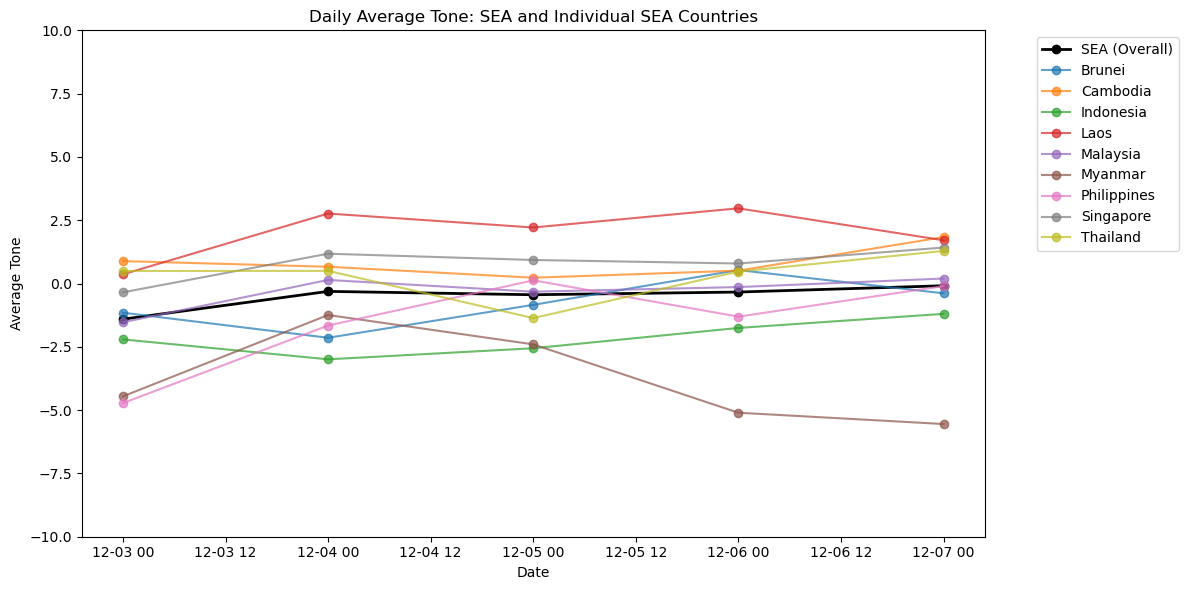

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure DATE is a datetime
analytics_df['DATE'] = pd.to_datetime(analytics_df['DATE'], errors='coerce')
# Drop rows where Tone_Average is not available
df = analytics_df.dropna(subset=['Tone_Average'])
# Convert Tone_Average to numeric if necessary
df['Tone_Average'] = pd.to_numeric(df['Tone_Average'], errors='coerce')

# Create separate dataframes for region1=SEA and region2=SEA
df_sea1 = df[df['region1'] == 'SEA'][['DATE', 'Tone_Average', 'countries1']].rename(columns={'countries1': 'Country'})
df_sea2 = df[df['region2'] == 'SEA'][['DATE', 'Tone_Average', 'countries2']].rename(columns={'countries2': 'Country'})

# Combine the two dataframes
df_combined = pd.concat([df_sea1, df_sea2])

# Drop rows where Country is NaN
df_combined = df_combined.dropna(subset=['Country'])

# Group by DATE and Country to get daily average tone per SEA country
country_daily_tone = df_combined.groupby(['DATE', 'Country'], as_index=False)['Tone_Average'].mean()

# Compute overall daily average tone for SEA (all SEA countries combined)
sea_daily_tone = country_daily_tone.groupby('DATE', as_index=False)['Tone_Average'].mean()

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot SEA overall trend in black
plt.plot(sea_daily_tone['DATE'], sea_daily_tone['Tone_Average'], 
         marker='o', color='black', linewidth=2, label='SEA (Overall)')

# Plot individual SEA countries with transparency for clarity
for country, grp in country_daily_tone.groupby('Country'):
    plt.plot(grp['DATE'], grp['Tone_Average'], marker='o', label=country, alpha=0.7)

plt.title('Daily Average Tone: SEA and Individual SEA Countries')
plt.xlabel('Date')
plt.ylabel('Average Tone')
plt.ylim(-10, 10)  # Set the y-axis limits to -10 and 10
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # List of all regions to analyze
# regions = ['SEA', 'Oceania', 'Africa', 'Americas', 'EU', 'MENA', 'Central Asia', 'South Asia', 'East Asia']

# # Create figure with subplots
# fig, axes = plt.subplots(3, 3, figsize=(20, 20))
# axes = axes.flatten()

# # Process each region
# for idx, region in enumerate(regions):
#     # Create separate dataframes for region1 and region2
#     df_region1 = df[df['region1'] == region][['DATE', 'Tone_Average', 'countries1']].rename(columns={'countries1': 'Country'})
#     df_region2 = df[df['region2'] == region][['DATE', 'Tone_Average', 'countries2']].rename(columns={'countries2': 'Country'})
    
#     # Combine the dataframes
#     df_combined = pd.concat([df_region1, df_region2])
#     df_combined = df_combined.dropna(subset=['Country'])
    
#     # Calculate daily averages
#     country_daily_tone = df_combined.groupby(['DATE', 'Country'], as_index=False)['Tone_Average'].mean()
#     region_daily_tone = country_daily_tone.groupby('DATE', as_index=False)['Tone_Average'].mean()
    
#     # Plot on the corresponding subplot
#     ax = axes[idx]
    
#     # Plot region overall trend in black
#     ax.plot(region_daily_tone['DATE'], region_daily_tone['Tone_Average'], 
#             marker='o', color='black', linewidth=2, label=f'{region} (Overall)')
    
#     # Plot individual countries with transparency
#     for country, grp in country_daily_tone.groupby('Country'):
#         ax.plot(grp['DATE'], grp['Tone_Average'], marker='o', label=country, alpha=0.7)
    
#     # Customize subplot
#     ax.set_title(f'{region} Daily Average Tone')
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Average Tone')
#     ax.set_ylim(-10, 10)
#     ax.tick_params(axis='x', rotation=90)
    
#     # Add legend with smaller font
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

# # Optional: Create individual full-size plots for each region
# for region in regions:
#     # Create separate dataframes for region1 and region2
#     df_region1 = df[df['region1'] == region][['DATE', 'Tone_Average', 'countries1']].rename(columns={'countries1': 'Country'})
#     df_region2 = df[df['region2'] == region][['DATE', 'Tone_Average', 'countries2']].rename(columns={'countries2': 'Country'})
    
#     # Combine the dataframes
#     df_combined = pd.concat([df_region1, df_region2])
#     df_combined = df_combined.dropna(subset=['Country'])
    
#     # Calculate daily averages
#     country_daily_tone = df_combined.groupby(['DATE', 'Country'], as_index=False)['Tone_Average'].mean()
#     region_daily_tone = country_daily_tone.groupby('DATE', as_index=False)['Tone_Average'].mean()
    
#     # Create individual plot
#     plt.figure(figsize=(12, 6))
    
#     # Plot region overall trend in black
#     plt.plot(region_daily_tone['DATE'], region_daily_tone['Tone_Average'], 
#              marker='o', color='black', linewidth=2, label=f'{region} (Overall)')
    
#     # Plot individual countries
#     for country, grp in country_daily_tone.groupby('Country'):
#         plt.plot(grp['DATE'], grp['Tone_Average'], marker='o', label=country, alpha=0.7)
    
#     plt.title(f'{region} Daily Average Tone')
#     plt.xlabel('Date')
#     plt.ylabel('Average Tone')
#     plt.ylim(-10, 10)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()

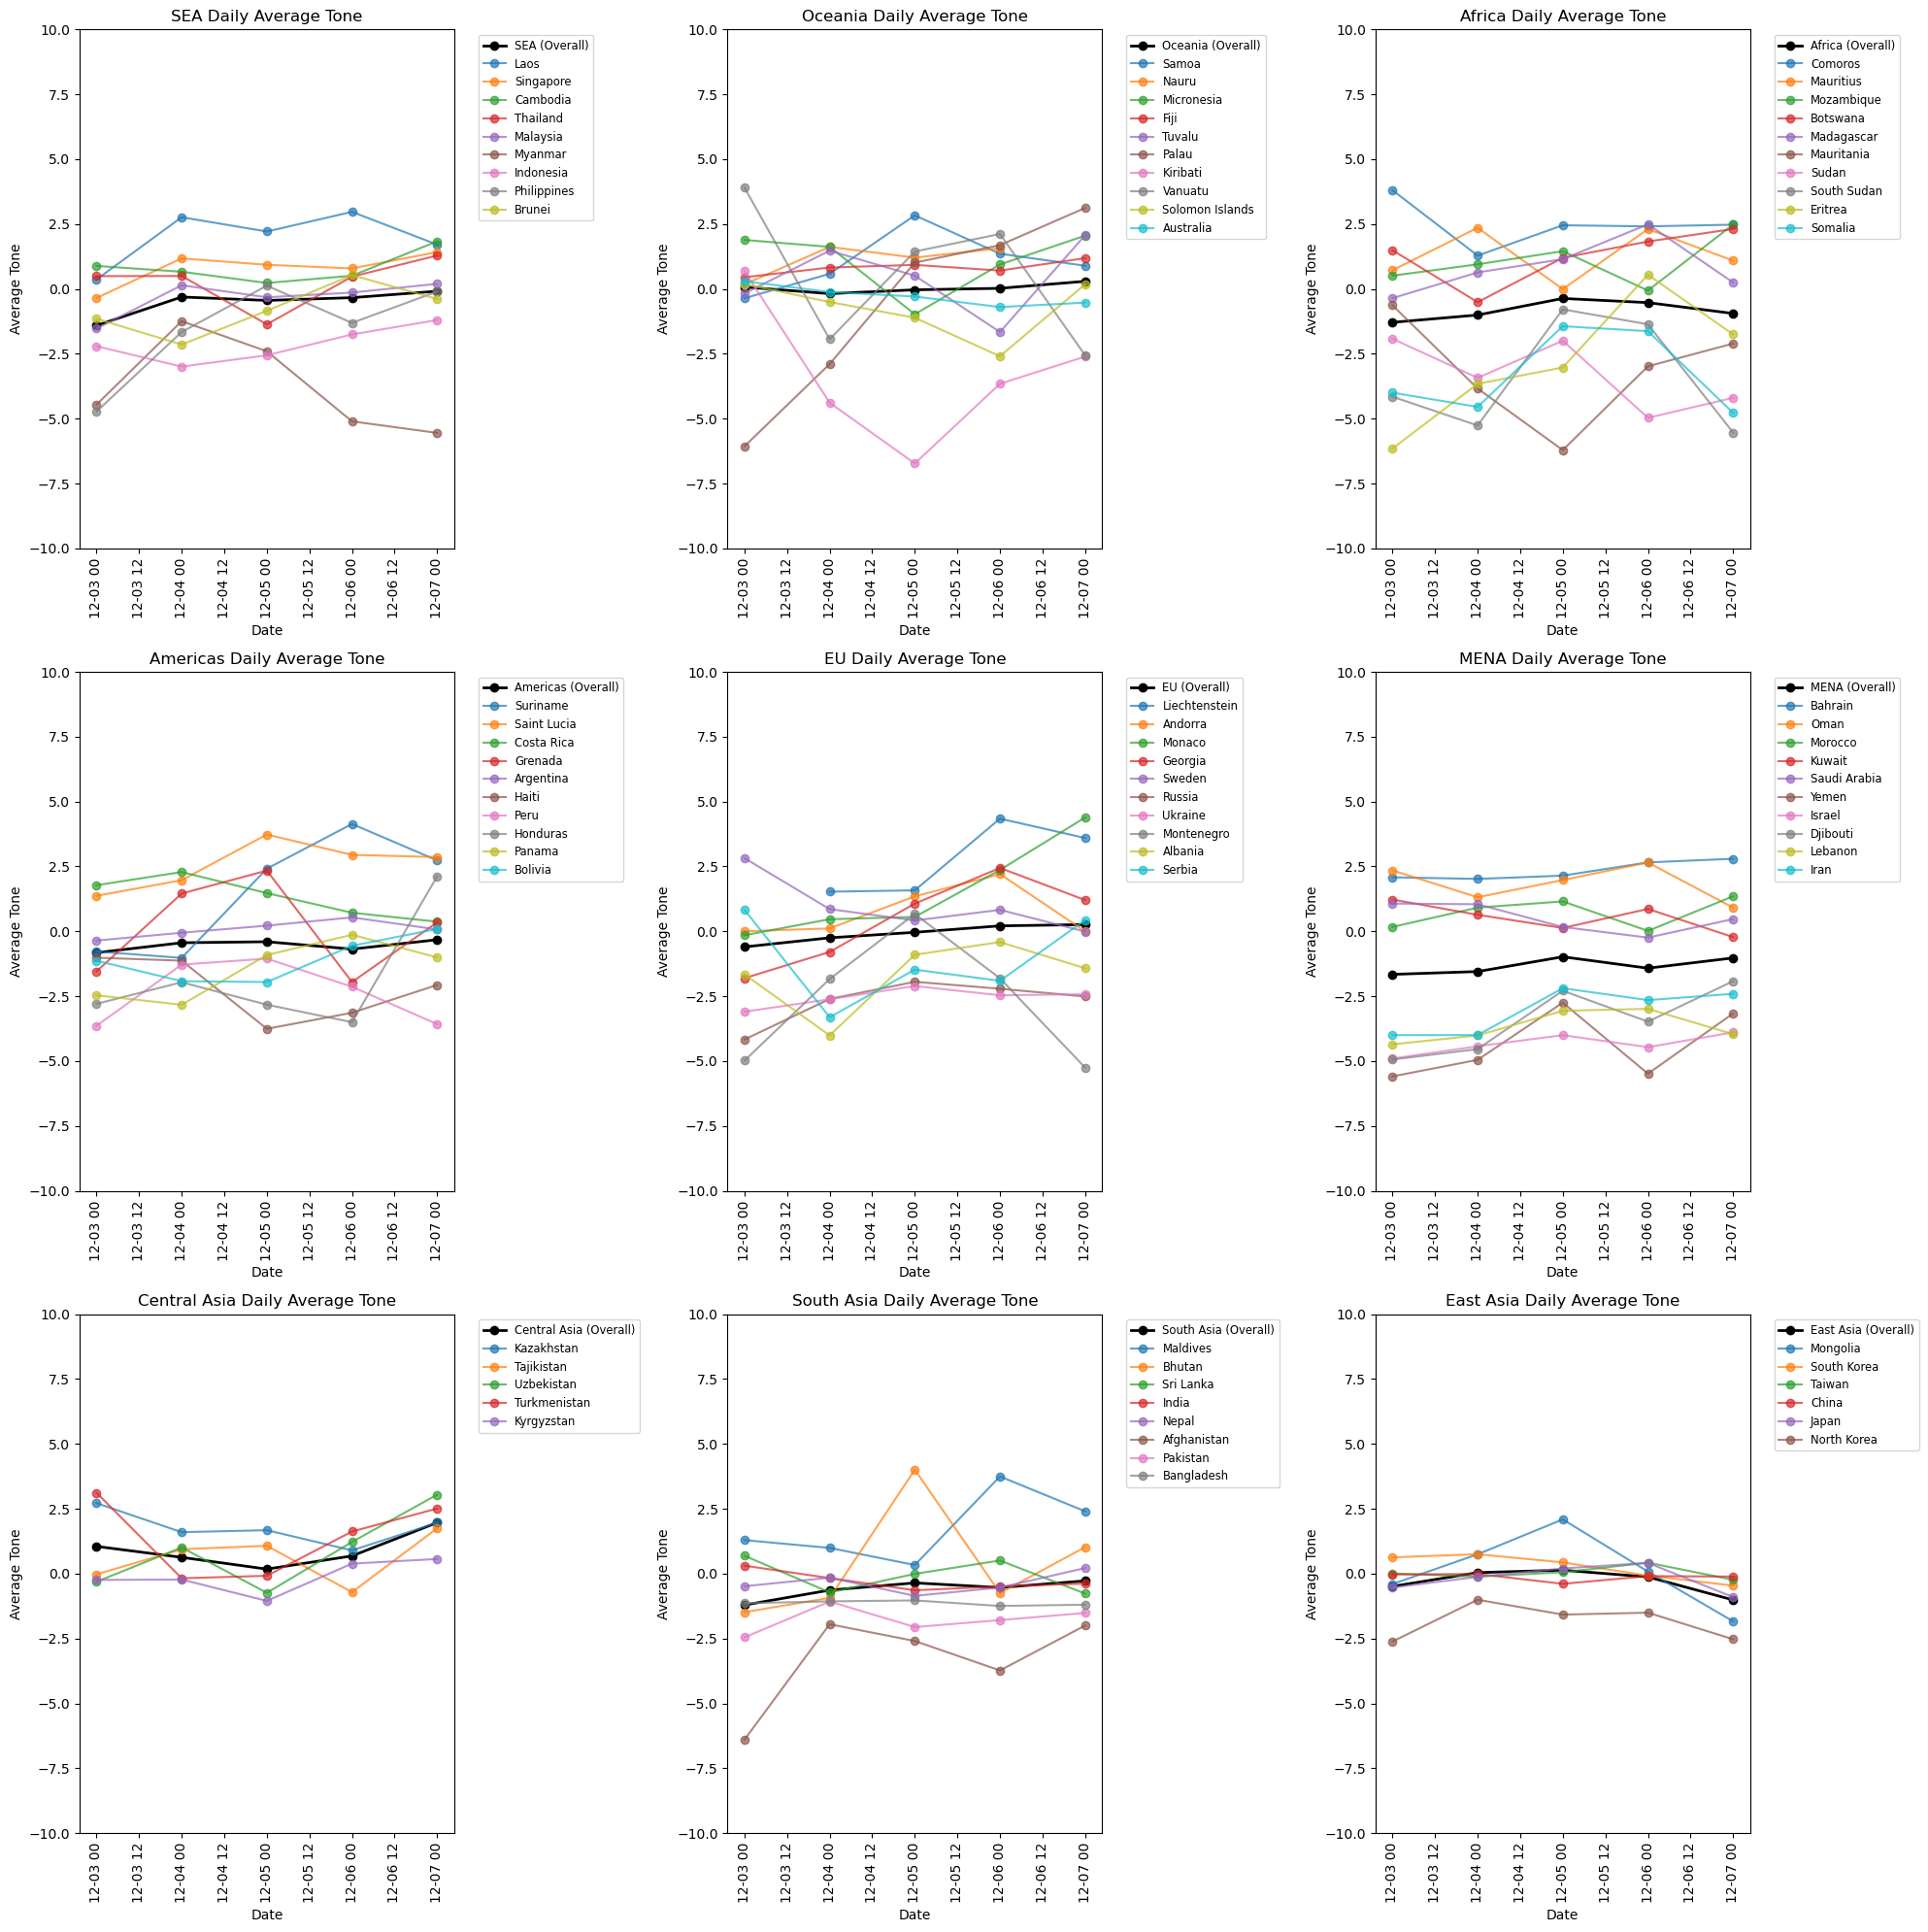


=== SEA Top Contributors ===

Top 5 Positive Contributors:
  Country      mean  count
     Laos  2.299681    461
Singapore  0.943911   2798
 Cambodia  0.766398    996
 Thailand  0.193646   2599
 Malaysia -0.238752   3001

Top 5 Negative Contributors:
    Country      mean  count
    Myanmar -4.590411    879
  Indonesia -2.328911   5626
Philippines -1.964182   8822
     Brunei -1.125820    325
   Malaysia -0.238752   3001

=== Oceania Top Contributors ===

Top 5 Positive Contributors:
   Country     mean  count
     Samoa 1.464269    172
     Nauru 1.225130      6
Micronesia 1.149784     34
      Fiji 0.814905    382
    Tuvalu 0.610297     48

Top 5 Negative Contributors:
        Country      mean  count
          Palau -4.061798    110
       Kiribati -3.878737     14
        Vanuatu -1.718498    164
Solomon Islands -1.282309    255
      Australia -0.325655  41699

=== Africa Top Contributors ===

Top 5 Positive Contributors:
   Country     mean  count
   Comoros 2.155838     25
 Ma

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_regional_tones(df, regions):
    # Create figure with subplots for tone trends
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    axes = axes.flatten()
    
    # Dictionary to store top contributors
    top_contributors = {}
    
    # Process each region
    for idx, region in enumerate(regions):
        # Create separate dataframes for region1 and region2
        df_region1 = df[df['region1'] == region][['DATE', 'Tone_Average', 'countries1']].rename(columns={'countries1': 'Country'})
        df_region2 = df[df['region2'] == region][['DATE', 'Tone_Average', 'countries2']].rename(columns={'countries2': 'Country'})
        
        # Combine the dataframes
        df_combined = pd.concat([df_region1, df_region2])
        df_combined = df_combined.dropna(subset=['Country'])
        
        # Calculate average tone for each country
        country_avg_tone = df_combined.groupby('Country')['Tone_Average'].agg(['mean', 'count']).reset_index()
        country_avg_tone = country_avg_tone[country_avg_tone['count'] >= 5]  # Filter for countries with at least 5 data points
        
        # Get top 5 positive and negative contributors
        top_positive = country_avg_tone.nlargest(5, 'mean')
        top_negative = country_avg_tone.nsmallest(5, 'mean')
        
        top_contributors[region] = {
            'positive': top_positive,
            'negative': top_negative
        }
        
        # Calculate daily averages for plotting
        country_daily_tone = df_combined.groupby(['DATE', 'Country'], as_index=False)['Tone_Average'].mean()
        region_daily_tone = country_daily_tone.groupby('DATE', as_index=False)['Tone_Average'].mean()
        
        # Plot on the corresponding subplot
        ax = axes[idx]
        
        # Plot region overall trend in black
        ax.plot(region_daily_tone['DATE'], region_daily_tone['Tone_Average'], 
                marker='o', color='black', linewidth=2, label=f'{region} (Overall)')
        
        # Plot top contributors with different colors
        top_countries = pd.concat([top_positive, top_negative])['Country'].unique()
        for country in top_countries:
            country_data = country_daily_tone[country_daily_tone['Country'] == country]
            ax.plot(country_data['DATE'], country_data['Tone_Average'], 
                   marker='o', label=country, alpha=0.7)
        
        # Customize subplot
        ax.set_title(f'{region} Daily Average Tone')
        ax.set_xlabel('Date')
        ax.set_ylabel('Average Tone')
        ax.set_ylim(-10, 10)
        ax.tick_params(axis='x', rotation=90)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    
    plt.tight_layout()
    plt.show()
    
    # Print top contributors for each region
    for region in regions:
        print(f"\n=== {region} Top Contributors ===")
        print("\nTop 5 Positive Contributors:")
        print(top_contributors[region]['positive'][['Country', 'mean', 'count']].to_string(index=False))
        print("\nTop 5 Negative Contributors:")
        print(top_contributors[region]['negative'][['Country', 'mean', 'count']].to_string(index=False))
    
    return top_contributors

# List of all regions to analyze
regions = ['SEA', 'Oceania', 'Africa', 'Americas', 'EU', 'MENA', 'Central Asia', 'South Asia', 'East Asia']
# regions = ['SEA']

# Run the analysis
top_contributors = analyze_regional_tones(df, regions)

# Optional: Create detailed plots for top contributors only
def plot_region_details(df, region, top_contributors):
    top_countries = pd.concat([
        top_contributors[region]['positive'],
        top_contributors[region]['negative']
    ])['Country'].unique()
    
    # Filter data for top contributors
    df_region1 = df[df['region1'] == region][['DATE', 'Tone_Average', 'countries1']].rename(columns={'countries1': 'Country'})
    df_region2 = df[df['region2'] == region][['DATE', 'Tone_Average', 'countries2']].rename(columns={'countries2': 'Country'})
    df_combined = pd.concat([df_region1, df_region2])
    df_combined = df_combined[df_combined['Country'].isin(top_countries)]
    
    # Calculate daily averages
    country_daily_tone = df_combined.groupby(['DATE', 'Country'], as_index=False)['Tone_Average'].mean()
    region_daily_tone = country_daily_tone.groupby('DATE', as_index=False)['Tone_Average'].mean()
    
    plt.figure(figsize=(15, 8))
    plt.plot(region_daily_tone['DATE'], region_daily_tone['Tone_Average'],
             marker='o', color='black', linewidth=2, label=f'{region} (Overall)')
    
    for country in top_countries:
        country_data = country_daily_tone[country_daily_tone['Country'] == country]
        plt.plot(country_data['DATE'], country_data['Tone_Average'],
                marker='o', label=country, alpha=0.7, linewidth=2)
    
    plt.title(f'{region} Top Contributors Daily Average Tone')
    plt.xlabel('Date')
    plt.ylabel('Average Tone')
    plt.ylim(-10, 10)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# To create detailed plots for each region:
# for region in regions:
#     plot_region_details(df, region, top_contributors)

In [ ]:
def analyze_country_details(df, country_name):
    """
    Perform detailed analysis of tone data and themes for a specific country
    Only analyzes data from countries1 column
    """
    # Only look at data from countries1 column
    df_country = df[df['countries1'] == country_name].copy()
    
    df_country['DATE'] = pd.to_datetime(df_country['DATE'])
    
    # Process themes and calculate sentiment
    theme_data = []
    theme_pairs = []
    
    for idx, row in df_country.iterrows():
        if isinstance(row['categorized_themes'], str):
            # Split themes for this article
            themes_list = [theme.strip().strip("'").strip('"') 
                         for theme in row['categorized_themes'].strip('[]').split(',')]
            themes_list = [t for t in themes_list if t.lower() != 'none']
            
            # Record each theme with article metrics
            for theme in themes_list:
                theme_data.append({
                    'date': row['DATE'],
                    'theme': theme,
                    'tone': row['Tone_Average'],
                    'positive': row['Positive_Score'],
                    'negative': row['Negative_Score']
                })
            
            # Record theme co-occurrences
            for i in range(len(themes_list)):
                for j in range(i + 1, len(themes_list)):
                    theme_pairs.append(tuple(sorted([themes_list[i], themes_list[j]])))
    
    theme_df = pd.DataFrame(theme_data)
    
    # Calculate theme statistics
    theme_stats = {}
    for theme in theme_df['theme'].unique():
        theme_metrics = theme_df[theme_df['theme'] == theme]
        theme_stats[theme] = {
            'count': len(theme_metrics),
            'avg_tone': theme_metrics['tone'].mean(),
            'avg_positive': theme_metrics['positive'].mean(),
            'avg_negative': theme_metrics['negative'].mean()
        }
    
    # Calculate common theme pairs
    pair_counts = pd.Series(theme_pairs).value_counts()
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Daily average sentiment scores
    daily_avg = theme_df.groupby('date').agg({
        'tone': 'mean',
        'positive': 'mean',
        'negative': 'mean'
    })
    
    # Calculate 7-day moving averages
    rolling_pos = daily_avg['positive'].rolling(window=7, min_periods=1).mean()
    rolling_neg = daily_avg['negative'].rolling(window=7, min_periods=1).mean()
    
    ax1.plot(rolling_pos.index, rolling_pos, 
             label='Positive Score (7-day avg)', color='green')
    ax1.plot(rolling_neg.index, rolling_neg, 
             label='Negative Score (7-day avg)', color='red')
    
    ax1.set_title(f'{country_name} (Primary Country) - Average Sentiment Scores Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Theme sentiment analysis
    min_articles = 50
    significant_themes = {k: v for k, v in theme_stats.items() 
                         if v['count'] >= min_articles}
    
    # Sort themes by average tone
    sorted_themes = dict(sorted(significant_themes.items(), 
                              key=lambda x: x[1]['avg_tone']))
    
    theme_names = list(sorted_themes.keys())
    theme_tones = [sorted_themes[theme]['avg_tone'] for theme in theme_names]
    colors = ['red' if tone < 0 else 'green' for tone in theme_tones]
    
    bars = ax2.barh(range(len(theme_names)), theme_tones, color=colors, alpha=0.6)
    theme_labels = [f"{theme}\n(n={significant_themes[theme]['count']})" 
                   for theme in theme_names]
    
    ax2.set_yticks(range(len(theme_names)))
    ax2.set_yticklabels(theme_labels)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title(f'Average Tone by Theme (min {min_articles} articles)')
    ax2.set_xlabel('Average Tone')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Theme occurrence counts
    theme_counts = theme_df['theme'].value_counts()
    top_themes = theme_counts.head(10)
    
    ax3.bar(range(len(top_themes)), top_themes.values)
    ax3.set_xticks(range(len(top_themes)))
    ax3.set_xticklabels(top_themes.index, rotation=45, ha='right')
    ax3.set_title('Top 10 Most Common Themes')
    ax3.set_ylabel('Number of Articles')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Top theme pairs
    top_pairs = pair_counts.head(10)
    
    ax4.bar(range(len(top_pairs)), top_pairs.values)
    ax4.set_xticks(range(len(top_pairs)))
    ax4.set_xticklabels([f"{pair[0]}\n+ {pair[1]}" for pair in top_pairs.index], 
                        rotation=45, ha='right')
    ax4.set_title('Top 10 Theme Co-occurrences')
    ax4.set_ylabel('Number of Articles')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed theme statistics
    print("\nTheme Statistics (sorted by tone, min 5 articles):")
    print("\nMost Positive Themes:")
    for theme in list(reversed(theme_names))[:5]:
        print(f"{theme:30} Count: {significant_themes[theme]['count']:3d} | "
              f"Avg Tone: {significant_themes[theme]['avg_tone']:6.2f} | "
              f"Pos Score: {significant_themes[theme]['avg_positive']:6.2f} | "
              f"Neg Score: {significant_themes[theme]['avg_negative']:6.2f}")
    
    print("\nMost Negative Themes:")
    for theme in theme_names[:5]:
        print(f"{theme:30} Count: {significant_themes[theme]['count']:3d} | "
              f"Avg Tone: {significant_themes[theme]['avg_tone']:6.2f} | "
              f"Pos Score: {significant_themes[theme]['avg_positive']:6.2f} | "
              f"Neg Score: {significant_themes[theme]['avg_negative']:6.2f}")
    
    print("\nMost Common Theme Co-occurrences:")
    for (theme1, theme2), count in pair_counts.head(10).items():
        print(f"{theme1:30} + {theme2:30} : {count}")
    
    return theme_stats, pair_counts

# Run the analysis
theme_stats, theme_pairs = analyze_country_details(df, "Malaysia")

In [ ]:
def analyze_country_details(df, country_name):
    """
    Perform detailed analysis of tone data and themes for a specific country.
    Only analyzes data from countries1 column.
    """
    # Only look at data from countries1 column
    df_country = df[df['countries1'] == country_name].copy()
    
    df_country['DATE'] = pd.to_datetime(df_country['DATE'])
    
    # Process themes and calculate sentiment
    theme_data = []
    theme_pairs = []
    
    for idx, row in df_country.iterrows():
        if isinstance(row['categorized_themes'], str):
            # Split themes for this article
            themes_list = [theme.strip().strip("'").strip('"') 
                         for theme in row['categorized_themes'].strip('[]').split(',')]
            themes_list = [t for t in themes_list if t.lower() != 'none']
            
            # Record each theme with article metrics
            for theme in themes_list:
                theme_data.append({
                    'date': row['DATE'],
                    'theme': theme,
                    'tone': row['Tone_Average'],
                    'positive': row['Positive_Score'],
                    'negative': row['Negative_Score']
                })
            
            # Record theme co-occurrences
            for i in range(len(themes_list)):
                for j in range(i + 1, len(themes_list)):
                    theme_pairs.append(tuple(sorted([themes_list[i], themes_list[j]])))
    
    theme_df = pd.DataFrame(theme_data)
    
    # Calculate theme statistics
    theme_stats = {}
    for theme in theme_df['theme'].unique():
        theme_metrics = theme_df[theme_df['theme'] == theme]
        theme_stats[theme] = {
            'count': len(theme_metrics),
            'avg_tone': theme_metrics['tone'].mean(),
            'avg_positive': theme_metrics['positive'].mean(),
            'avg_negative': theme_metrics['negative'].mean()
        }
    
    # Calculate common theme pairs
    pair_counts = pd.Series(theme_pairs).value_counts()
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Daily average sentiment scores
    daily_avg = theme_df.groupby('date').agg({
        'tone': 'mean',
        'positive': 'mean',
        'negative': 'mean'
    })
    
    # Calculate 7-day moving averages
    rolling_pos = daily_avg['positive'].rolling(window=7, min_periods=1).mean()
    rolling_neg = daily_avg['negative'].rolling(window=7, min_periods=1).mean()
    
    ax1.plot(rolling_pos.index, rolling_pos, 
             label='Positive Score (7-day avg)', color='green')
    ax1.plot(rolling_neg.index, rolling_neg, 
             label='Negative Score (7-day avg)', color='red')
    
    ax1.set_title(f'{country_name} (Primary Country) - Average Sentiment Scores Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Theme sentiment analysis
    min_articles = 50
    significant_themes = {k: v for k, v in theme_stats.items() 
                         if v['count'] >= min_articles}
    
    # Sort themes by average tone
    sorted_themes = dict(sorted(significant_themes.items(), 
                              key=lambda x: x[1]['avg_tone']))
    
    theme_names = list(sorted_themes.keys())
    theme_tones = [sorted_themes[theme]['avg_tone'] for theme in theme_names]
    colors = ['red' if tone < 0 else 'green' for tone in theme_tones]
    
    bars = ax2.barh(range(len(theme_names)), theme_tones, color=colors, alpha=0.6)
    theme_labels = [f"{theme}\n(n={significant_themes[theme]['count']})" 
                   for theme in theme_names]
    
    ax2.set_yticks(range(len(theme_names)))
    ax2.set_yticklabels(theme_labels)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title(f'Average Tone by Theme (min {min_articles} articles)')
    ax2.set_xlabel('Average Tone')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Theme occurrence counts
    theme_counts = theme_df['theme'].value_counts()
    top_themes = theme_counts.head(10)
    
    ax3.bar(range(len(top_themes)), top_themes.values)
    ax3.set_xticks(range(len(top_themes)))
    ax3.set_xticklabels(top_themes.index, rotation=45, ha='right')
    ax3.set_title('Top 10 Most Common Themes')
    ax3.set_ylabel('Number of Articles')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Top theme pairs
    top_pairs = pair_counts.head(10)
    
    ax4.bar(range(len(top_pairs)), top_pairs.values)
    ax4.set_xticks(range(len(top_pairs)))
    ax4.set_xticklabels([f"{pair[0]}\n+ {pair[1]}" for pair in top_pairs.index], 
                        rotation=45, ha='right')
    ax4.set_title('Top 10 Theme Co-occurrences')
    ax4.set_ylabel('Number of Articles')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed theme statistics
    print("\nTheme Statistics (sorted by tone, min 5 articles):")
    print("\nMost Positive Themes:")
    for theme in list(reversed(theme_names))[:5]:
        print(f"{theme:30} Count: {significant_themes[theme]['count']:3d} | "
              f"Avg Tone: {significant_themes[theme]['avg_tone']:6.2f} | "
              f"Pos Score: {significant_themes[theme]['avg_positive']:6.2f} | "
              f"Neg Score: {significant_themes[theme]['avg_negative']:6.2f}")
    
    print("\nMost Negative Themes:")
    for theme in theme_names[:5]:
        print(f"{theme:30} Count: {significant_themes[theme]['count']:3d} | "
              f"Avg Tone: {significant_themes[theme]['avg_tone']:6.2f} | "
              f"Pos Score: {significant_themes[theme]['avg_positive']:6.2f} | "
              f"Neg Score: {significant_themes[theme]['avg_negative']:6.2f}")
    
    print("\nMost Common Theme Co-occurrences:")
    for (theme1, theme2), count in pair_counts.head(10).items():
        print(f"{theme1:30} + {theme2:30} : {count}")
    
    return theme_stats, pair_counts

# Run the analysis
theme_stats, theme_pairs = analyze_country_details(df, "Malaysia")

In [7]:
def find_malaysia_negative_themes_and_articles(df, min_articles=5):
    """
    Analyze most negative themes and their articles specifically for Malaysia
    Returns a single pandas DataFrame with all the negative articles information
    """
    # Only filter for Malaysia articles from countries1
    malaysia_df = df[df['countries1'] == 'Malaysia'].copy()
    
    # Store the total count for printing
    total_articles = len(malaysia_df)
    
    def combine_first_three_themes(themes_str):
        if isinstance(themes_str, str):
            themes_list = [theme.strip().strip("'").strip('"') 
                         for theme in themes_str.strip('[]').split(',')]
            first_three = themes_list[:3]
            if first_three:
                return ", ".join(first_three)
        return "No themes"
    
    # Create new column with combined themes
    malaysia_df['themes_combined'] = malaysia_df['categorized_themes'].apply(combine_first_three_themes)
    
    # Calculate theme statistics using groupby
    theme_stats = malaysia_df.groupby('themes_combined').agg({
        'Tone_Average': ['mean', 'count']
    }).reset_index()
    
    # Flatten column names
    theme_stats.columns = ['themes_combined', 'avg_tone', 'article_count']
    
    # Filter themes with minimum article count and sort by average tone
    theme_stats = theme_stats[theme_stats['article_count'] >= min_articles].sort_values('avg_tone')
    
    # Create final DataFrame with all negative articles
    negative_articles = []
    
    for theme in theme_stats['themes_combined']:
        theme_articles = malaysia_df[malaysia_df['themes_combined'] == theme]
        avg_tone = theme_stats[theme_stats['themes_combined'] == theme]['avg_tone'].values[0]
        article_count = theme_stats[theme_stats['themes_combined'] == theme]['article_count'].values[0]
        
        # Get top 5 most negative articles for each theme
        top_negative = theme_articles.nsmallest(5, 'Tone_Average')
        
        for _, article in top_negative.iterrows():
            negative_articles.append({
                'theme_combination': theme,
                'theme_avg_tone': avg_tone,
                'theme_article_count': article_count,
                'date': article['DATE'],
                'article_tone': article['Tone_Average'],
                'url': article['SOURCEURLS']
            })
    
    # Create final DataFrame
    results_df = pd.DataFrame(negative_articles)
    
    # Reorder columns for better readability
    results_df = results_df[[
        'theme_combination',
        'theme_avg_tone',
        'theme_article_count',
        'date',
        'article_tone',
        'url'
    ]]
    
    # Sort by theme average tone and then by article tone
    results_df = results_df.sort_values(['theme_avg_tone', 'article_tone'])
    
    print(f"Total Malaysia articles analyzed: {total_articles}")
    print("\nMost negative themes and their articles:")
    
    return results_df

# Run the analysis
results_df = find_malaysia_negative_themes_and_articles(df)
display(results_df)

Total Malaysia articles analyzed: 1681

Most negative themes and their articles:


,theme_combination,theme_avg_tone,theme_article_count,date,article_tone,url
0,"Governance & Roles, Law & Justice, Social & Co...",-8.537236,5,2023-12-05,-13.636364,https://www.thestar.com.my/news/nation/2023/12...
1,"Governance & Roles, Law & Justice, Social & Co...",-8.537236,5,2023-12-06,-10.297483,https://dailyexpress.com.my/news/224803/rm315-...
2,"Governance & Roles, Law & Justice, Social & Co...",-8.537236,5,2023-12-04,-9.635417,https://www.thestar.com.my/news/nation/2023/12...
3,"Governance & Roles, Law & Justice, Social & Co...",-8.537236,5,2023-12-06,-4.797980,https://mothership.sg/2023/12/man-sexually-ass...
4,"Governance & Roles, Law & Justice, Social & Co...",-8.537236,5,2023-12-07,-4.318937,https://dailyexpress.com.my/news/224888/govt-m...
...,...,...,...,...,...,...
345,"Governance & Roles, Science & Technology, Soci...",4.906296,6,2023-12-03,0.304878,https://www.ndtv.com/world-news/maybank-client...
346,"Governance & Roles, Science & Technology, Soci...",4.906296,6,2023-12-07,0.432900,https://www.thestar.com.my/news/nation/2023/12...
347,"Governance & Roles, Science & Technology, Soci...",4.906296,6,2023-12-06,4.318937,https://www.furninfo.com/furniture-industry-ne...
348,"Governance & Roles, Science & Technology, Soci...",4.906296,6,2023-12-04,4.794521,https://www.bernama.com/en/general/news.php?id...


In [22]:
# Get top 3 most negative articles per theme
pivot_df = (results_df.sort_values('article_tone')
            .groupby('theme_combination')
            .head(3)
            .sort_values(['theme_combination', 'article_tone']))

# Select and format columns
pivot_display = pivot_df[['theme_combination', 'article_tone', 'url']]
pivot_display['article_tone'] = pivot_display['article_tone'].round(2)

print("Top 3 Most Negative Articles per Theme:")
display(pivot_display)

Top 3 Most Negative Articles per Theme:


C:\Users\pc\AppData\Local\Temp\ipykernel_27624\571758950.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_display['article_tone'] = pivot_display['article_tone'].round(2)


,theme_combination,article_tone,url
10,"Crisis & Security, Environment & Sustainabilit...",-8.11,https://www.southeastasiapost.com/news/2740538...
11,"Crisis & Security, Environment & Sustainabilit...",-8.11,https://www.bruneinews.net/news/274053889/floo...
12,"Crisis & Security, Environment & Sustainabilit...",-8.04,https://www.bignewsnetwork.com/news/274053889/...
35,"Crisis & Security, Governance & Roles, Culture...",-8.41,https://www.thestar.com.my/news/nation/2021/08...
36,"Crisis & Security, Governance & Roles, Culture...",-5.56,https://www.thestar.com.my/news/nation/2023/12...
...,...,...,...
76,"Health & Medicine, Governance & Roles, Crisis ...",-2.22,https://www.malaymail.com/news/malaysia/2023/1...
77,"Health & Medicine, Governance & Roles, Crisis ...",-1.98,https://www.theborneopost.com/2023/12/07/healt...
295,No themes,-5.23,https://www.thestar.com.my/news/nation/2023/12...
296,No themes,-3.16,https://www.straitstimes.com/business/defi-pla...


In [24]:
# Get top 3 most positive articles per theme, excluding negative values
pivot_df = (results_df[results_df['article_tone'] > 0]  # Filter for positive values only
            .sort_values('article_tone', ascending=False)
            .groupby('theme_combination')
            .head(3)
            .sort_values(['theme_combination', 'article_tone'], ascending=[True, False]))

# Select and format columns
pivot_display = pivot_df[['theme_combination', 'article_tone', 'url']]
pivot_display['article_tone'] = pivot_display['article_tone'].round(2)

print("Top 3 Most Positive Articles per Theme:")
display(pivot_display)

Top 3 Most Positive Articles per Theme:


C:\Users\pc\AppData\Local\Temp\ipykernel_27624\390686477.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_display['article_tone'] = pivot_display['article_tone'].round(2)


,theme_combination,article_tone,url
39,"Crisis & Security, Governance & Roles, Culture...",1.90,https://www.thestar.com.my/news/nation/2023/12...
179,Economics & Finance,1.52,https://www.therakyatpost.com/fun/2023/12/04/i...
294,Education,2.88,https://dailyexpress.com.my/news/224668/univer...
293,Education,2.67,https://www.theborneopost.com/2023/12/03/rm474...
292,Education,2.10,https://dailyexpress.com.my/news/224672/rm474-...
...,...,...,...
84,"Governance & Roles, Wildlife/Vertebrates, Cris...",2.02,https://soyacincau.com/2023/12/06/acer-nitro-v...
138,"Governance & Roles, Wildlife/Vertebrates, Soci...",1.57,https://www.singaporestar.com/news/274055966/x...
139,"Governance & Roles, Wildlife/Vertebrates, Soci...",1.57,https://www.polandsun.com/news/274055966/xinji...
137,"Governance & Roles, Wildlife/Vertebrates, Soci...",1.56,http://www.china.org.cn/china/Off_the_Wire/202...


In [9]:
def find_malaysia_negative_themes_and_articles(df, min_articles=5):
    """
    Analyze most negative themes and their articles specifically for Malaysia
    Creates a combined theme column from first three themes of each row
    """
    # Only filter for Malaysia articles from countries1
    malaysia_df = df[df['countries1'] == 'Malaysia'].copy()
    
    print(f"Total Malaysia articles analyzed (as primary country): {len(malaysia_df)}")
    
    # Function to get first three themes combined
    def combine_first_three_themes(themes_str):
        if isinstance(themes_str, str):
            # Clean and split the themes
            themes_list = [theme.strip().strip("'").strip('"') 
                         for theme in themes_str.strip('[]').split(',')]
            # Get first three themes and combine them
            first_three = themes_list[:3]
            if first_three:
                return ", ".join(first_three)
        return "No themes"
    
    # Create new column with combined themes
    malaysia_df['themes_combined'] = malaysia_df['categorized_themes'].apply(combine_first_three_themes)
    
    # Process themes and calculate average tones
    theme_stats = {}
    
    # Process each row to analyze combined themes
    for _, row in malaysia_df.iterrows():
        theme_combo = row['themes_combined']
        
        if theme_combo not in theme_stats:
            theme_stats[theme_combo] = {
                'articles': [],
                'count': 0,
                'total_tone': 0
            }
        
        theme_stats[theme_combo]['articles'].append({
            'date': row['DATE'],
            'tone': row['Tone_Average'],
            'url': row['SOURCEURLS'],
            'themes': theme_combo
        })
        theme_stats[theme_combo]['count'] += 1
        theme_stats[theme_combo]['total_tone'] += row['Tone_Average']
    
    # Calculate averages and filter by minimum article count
    filtered_themes = {}
    for theme_combo, stats in theme_stats.items():
        if stats['count'] >= min_articles:
            # Sort articles by tone (most negative to most positive)
            sorted_articles = sorted(stats['articles'], key=lambda x: x['tone'])
            filtered_themes[theme_combo] = {
                'avg_tone': stats['total_tone'] / stats['count'],
                'count': stats['count'],
                'articles': sorted_articles
            }
    
    # Find most negative theme combinations
    sorted_themes = dict(sorted(filtered_themes.items(), 
                              key=lambda x: x[1]['avg_tone']))
    top_negative_themes = list(sorted_themes.items())[:5]
    
    print("\nMost Negative Theme Combinations in Malaysia Coverage:")
    print("=" * 80)
    for theme_combo, stats in sorted_themes.items():
        print(f"\n{theme_combo} (n={stats['count']}):")
        print(f"Average Tone: {stats['avg_tone']:.2f}")
        
        # Display most negative articles (first 5 from sorted list)
        print("\nMost Negative Articles:")
        print("-" * 40)
        for article in stats['articles'][:5]:
            print(f"\nDate: {article['date']}")
            print(f"Tone: {article['tone']:.2f}")
            print(f"URL: {article['url']}")
            print(f"Combined Themes: {article['themes']}")
            
        # Filter and display only positive articles
        positive_articles = [article for article in stats['articles'] if article['tone'] > 0]
        
        print("\nMost Positive Articles:")
        print("-" * 40)
        if positive_articles:
            # Take up to 5 most positive articles, in descending order
            for article in sorted(positive_articles, key=lambda x: x['tone'], reverse=True)[:5]:
                print(f"\nDate: {article['date']}")
                print(f"Tone: {article['tone']:.2f}")
                print(f"URL: {article['url']}")
                print(f"Combined Themes: {article['themes']}")
        else:
            print("\nNo articles with positive tone values found for this theme combination.")
    
    return top_negative_themes

# Run the analysis
top_negative_results = find_malaysia_negative_themes_and_articles(df)

Total Malaysia articles analyzed (as primary country): 1681

Most Negative Theme Combinations in Malaysia Coverage:

Governance & Roles, Law & Justice, Social & Community (n=5):
Average Tone: -8.54

Most Negative Articles:
----------------------------------------

Date: 2023-12-05 00:00:00
Tone: -13.64
URL: https://www.thestar.com.my/news/nation/2023/12/05/juvenile-pleads-guilty-to-sexual-assault-against-minor
Combined Themes: Governance & Roles, Law & Justice, Social & Community

Date: 2023-12-06 00:00:00
Tone: -10.30
URL: https://dailyexpress.com.my/news/224803/rm315-600-false-claim-company-owner-charged/
Combined Themes: Governance & Roles, Law & Justice, Social & Community

Date: 2023-12-04 00:00:00
Tone: -9.64
URL: https://www.thestar.com.my/news/nation/2023/12/04/ex-petronas-exec-gets-prison-fine-for-receiving-bribes
Combined Themes: Governance & Roles, Law & Justice, Social & Community

Date: 2023-12-06 00:00:00
Tone: -4.80
URL: https://mothership.sg/2023/12/man-sexually-assault

In [11]:
def find_malaysia_negative_themes_and_articles(df, min_articles=5):
    """
    Analyze most negative themes and their articles specifically for Malaysia
    Creates a combined theme column from first three themes of each row
    """
    import pandas as pd
    from IPython.display import HTML, display

    # Only filter for Malaysia articles from countries1
    malaysia_df = df[df['countries1'] == 'Malaysia'].copy()
    
    print(f"Total Malaysia articles analyzed (as primary country): {len(malaysia_df)}")
    
    # Function to get first three themes combined
    def combine_first_three_themes(themes_str):
        if isinstance(themes_str, str):
            # Clean and split the themes
            themes_list = [theme.strip().strip("'").strip('"') 
                         for theme in themes_str.strip('[]').split(',')]
            # Get first three themes and combine them
            first_three = themes_list[:3]
            if first_three:
                return ", ".join(first_three)
        return "No themes"
    
    # Create new column with combined themes
    malaysia_df['themes_combined'] = malaysia_df['categorized_themes'].apply(combine_first_three_themes)
    
    # Process themes and calculate average tones
    theme_stats = {}
    
    # Process each row to analyze combined themes
    for _, row in malaysia_df.iterrows():
        theme_combo = row['themes_combined']
        
        if theme_combo not in theme_stats:
            theme_stats[theme_combo] = {
                'articles': [],
                'count': 0,
                'total_tone': 0
            }
        
        theme_stats[theme_combo]['articles'].append({
            'date': row['DATE'],
            'tone': row['Tone_Average'],
            'url': row['SOURCEURLS'],
            'themes': theme_combo
        })
        theme_stats[theme_combo]['count'] += 1
        theme_stats[theme_combo]['total_tone'] += row['Tone_Average']
    
    # Calculate averages and filter by minimum article count
    filtered_themes = {}
    for theme_combo, stats in theme_stats.items():
        if stats['count'] >= min_articles:
            # Sort articles by tone (most negative to most positive)
            sorted_articles = sorted(stats['articles'], key=lambda x: x['tone'])
            filtered_themes[theme_combo] = {
                'avg_tone': stats['total_tone'] / stats['count'],
                'count': stats['count'],
                'articles': sorted_articles
            }
    
    # Find most negative theme combinations
    sorted_themes = dict(sorted(filtered_themes.items(), 
                              key=lambda x: x[1]['avg_tone']))
    top_negative_themes = list(sorted_themes.items())[:5]
    
    print("\nMost Negative Theme Combinations in Malaysia Coverage:")
    print("=" * 80)
    for theme_combo, stats in sorted_themes.items():
        print(f"\n{theme_combo} (n={stats['count']}):")
        print(f"Average Tone: {stats['avg_tone']:.2f}")
        
        # Create a dataframe of all articles for this theme combo
        articles_df = pd.DataFrame(stats['articles'])
        
        # Convert URL column to clickable links
        if 'url' in articles_df.columns:
            articles_df['url'] = articles_df['url'].apply(lambda x: f'<a href="{x}" target="_blank">{x}</a>')
        
        # Most negative articles (lowest tone)
        negative_articles_df = articles_df.nsmallest(5, 'tone')
        # Most positive articles (tone > 0, highest tone)
        positive_articles_df = articles_df[articles_df['tone'] > 0].nlargest(5, 'tone')
        
        # Reorder columns so that themes is the first column
        columns_order = ['themes', 'date', 'tone', 'url']
        
        print("\nMost Negative Articles:")
        print("-" * 40)
        if not negative_articles_df.empty:
            display(HTML(negative_articles_df[columns_order].to_html(escape=False, index=False)))
        else:
            print("No negative articles found.")
        
        print("\nMost Positive Articles:")
        print("-" * 40)
        if not positive_articles_df.empty:
            display(HTML(positive_articles_df[columns_order].to_html(escape=False, index=False)))
        else:
            print("No articles with positive tone values found for this theme combination.")
    
    return top_negative_themes

# Run the analysis
top_negative_results = find_malaysia_negative_themes_and_articles(df)


Total Malaysia articles analyzed (as primary country): 1681

Most Negative Theme Combinations in Malaysia Coverage:

Governance & Roles, Law & Justice, Social & Community (n=5):
Average Tone: -8.54

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Law & Justice, Social & Community",2023-12-05,-13.636364,https://www.thestar.com.my/news/nation/2023/12/05/juvenile-pleads-guilty-to-sexual-assault-against-minor
"Governance & Roles, Law & Justice, Social & Community",2023-12-06,-10.297483,https://dailyexpress.com.my/news/224803/rm315-600-false-claim-company-owner-charged/
"Governance & Roles, Law & Justice, Social & Community",2023-12-04,-9.635417,https://www.thestar.com.my/news/nation/2023/12/04/ex-petronas-exec-gets-prison-fine-for-receiving-bribes
"Governance & Roles, Law & Justice, Social & Community",2023-12-06,-4.797980,https://mothership.sg/2023/12/man-sexually-assault-girl-preschool/
"Governance & Roles, Law & Justice, Social & Community",2023-12-07,-4.318937,https://dailyexpress.com.my/news/224888/govt-must-pay-rm51-000-to-superman-hew-over-2019-book-ban/



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Governance & Roles, Law & Justice, Crisis & Security (n=14):
Average Tone: -6.49

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Law & Justice, Crisis & Security",2023-12-04,-10.218978,https://www.thestar.com.my/news/nation/2023/12/04/mechanic-charged-with-drug-trafficking-ordered-to-enter-defence
"Governance & Roles, Law & Justice, Crisis & Security",2023-12-06,-9.677419,https://www.thestar.com.my/news/nation/2023/12/06/tawau-woman-slapped-with-rm10400-fine-for-drink-driving-no-driving-licence
"Governance & Roles, Law & Justice, Crisis & Security",2023-12-03,-7.843137,https://www.thestar.com.my/news/nation/2023/12/03/terengganu-cops-nab-two-seize-over-7kg-of-yaba-pills
"Governance & Roles, Law & Justice, Crisis & Security",2023-12-04,-6.882591,https://thesun.my/local_news/former-lgm-properties-corporation-ceo-faces-another-charge-BK11829800
"Governance & Roles, Law & Justice, Crisis & Security",2023-12-04,-6.827309,https://www.thestar.com.my/news/nation/2023/12/04/former-property-developer-ceo-faces-another-charge



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Crisis & Security, Environment & Sustainability, Governance & Roles (n=9):
Average Tone: -6.38

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Crisis & Security, Environment & Sustainability, Governance & Roles",2023-12-04,-8.108108,https://www.southeastasiapost.com/news/274053889/floods-displace-over-4000-in-northeast-malaysia-state
"Crisis & Security, Environment & Sustainability, Governance & Roles",2023-12-04,-8.108108,"https://www.malaysiasun.com/news/274053889/floods-displace-over-4000-in-northeast-malaysia-state"" target=""_blank"">https://www.bruneinews.net/news/274053889/floods-displace-over-4000-in-northeast-malaysia-statehttps://www.malaysiasun.com/news/274053889/floods-displace-over-4000-in-northeast-malaysia-state"
"Crisis & Security, Environment & Sustainability, Governance & Roles",2023-12-04,-8.035714,https://www.bignewsnetwork.com/news/274053889/floods-displace-over-4000-in-northeast-malaysia-state
"Crisis & Security, Environment & Sustainability, Governance & Roles",2023-12-04,-7.964602,https://english.news.cn/20231204/4d22d8c700124676b3e53c1756000057/c.html
"Crisis & Security, Environment & Sustainability, Governance & Roles",2023-12-05,-7.936508,https://www.thestar.com.my/news/nation/2023/12/05/traffic-cops-clear-traffic-after-unclogging-drains-in-jb



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Governance & Roles, Culture & Arts & Religion, Law & Justice (n=6):
Average Tone: -5.62

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-03,-13.513514,https://www.malaysiakini.com/news/688760
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-05,-8.450704,https://www.thestar.com.my/news/nation/2023/12/05/datuk-on-drug-trafficking-charge
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-05,-7.504363,https://www.thestar.com.my/news/nation/2022/10/28/shafee-freed-of-all-money-laundering-charges
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-04,-7.317073,https://www.malaysiakini.com/news/688883
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-07,1.090909,https://www.malaymail.com/news/malaysia/2023/12/07/former-ag-apandi-ali-files-leave-to-appeal-over-courts-dismissal-of-his-lawsuit-against-kit-siang/106290



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-06,1.980198,https://www.thestar.com.my/news/nation/2023/12/06/samsuri-win-may-bring-down-political-temperature
"Governance & Roles, Culture & Arts & Religion, Law & Justice",2023-12-07,1.090909,https://www.malaymail.com/news/malaysia/2023/12/07/former-ag-apandi-ali-files-leave-to-appeal-over-courts-dismissal-of-his-lawsuit-against-kit-siang/106290



Governance & Roles, Social & Community, Law & Justice (n=5):
Average Tone: -5.20

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Law & Justice",2023-12-07,-11.842105,https://dailyexpress.com.my/news/224859/farmer-denies-raping-his-lover-15/
"Governance & Roles, Social & Community, Law & Justice",2023-12-05,-3.757829,https://www.themalaysianinsight.com/s/474972
"Governance & Roles, Social & Community, Law & Justice",2023-12-05,-3.724928,https://www.theborneopost.com/2023/12/05/agc-drops-appeal-against-lawyer-shafees-money-laundering-charges-acquittal/
"Governance & Roles, Social & Community, Law & Justice",2023-12-05,-3.441683,https://thesun.my/local_news/sulu-case-malaysia-hope-madrid-court-will-sentence-stampa-for-unqualified-professional-practice-BL11831275
"Governance & Roles, Social & Community, Law & Justice",2023-12-05,-3.247863,https://www.thestar.com.my/news/nation/2023/12/05/sulu-case-azalina-hopes-justice-will-prevail-as-stampa-faces-madrid-court



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Governance & Roles, Crisis & Security, Law & Justice (n=36):
Average Tone: -4.23

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-06,-12.371134,https://dailyexpress.com.my/news/224804/man-charged-with-drug-trafficking/
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-03,-10.113780,https://www.philippinetimes.com/news/274053080/beyond-borders-combating-waste-crime-for-climate-resilience-and-circular-prosperity
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-07,-8.827786,https://www.thestar.com.my/news/nation/2023/12/07/kevin-morais-murder-appeal-not-enough-evidence-to-sustain-charge-court-hears
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-04,-8.682171,https://thesun.my/local_news/no-evidence-ex-pathologist-masterminded-dpp-s-murder-appeals-court-told-GK11827724
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-04,-8.641975,https://www.thestar.com.my/news/nation/2023/12/04/no-evidence-ex-pathologist-masterminded-dpp039s-murder-appeals-court-told



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-06,8.510638,https://www.jpost.com/breaking-news/article-776833
"Governance & Roles, Crisis & Security, Law & Justice",2023-12-07,5.747126,https://dailyexpress.com.my/news/224842/no-takers-for-special-loans-consul/



Crisis & Security, Governance & Roles, Social & Community (n=14):
Average Tone: -3.78

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Crisis & Security, Governance & Roles, Social & Community",2023-12-03,-7.185629,https://us.cnn.com/2023/12/02/asia/explosion-sunday-mass-gym-philippines-intl-hnk/
"Crisis & Security, Governance & Roles, Social & Community",2023-12-03,-4.819277,https://www.thestar.com.my/news/nation/2023/12/03/lorry-crashes-into-three-vehicles-killing-two-injuring-three
"Crisis & Security, Governance & Roles, Social & Community",2023-12-04,-4.371585,https://www.thestar.com.my/news/nation/2023/12/04/two-women-killed-in-four-vehicle-accident
"Crisis & Security, Governance & Roles, Social & Community",2023-12-04,-4.225352,https://www.mymotherlode.com/news/asia/3272834/china-says-a-us-navy-ship-illegally-intruded-into-waters-in-the-south-china-sea.html
"Crisis & Security, Governance & Roles, Social & Community",2023-12-03,-4.123711,https://www.thestar.com.my/news/nation/2023/12/03/body-of-baby-girl-found-on-penang-beach



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Crisis & Security, Governance & Roles, Culture & Arts & Religion (n=5):
Average Tone: -3.39

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Crisis & Security, Governance & Roles, Culture & Arts & Religion",2023-12-03,-8.411215,https://www.thestar.com.my/news/nation/2021/08/02/sg-kim-kim-residents-on-edge
"Crisis & Security, Governance & Roles, Culture & Arts & Religion",2023-12-05,-5.555556,https://www.thestar.com.my/news/nation/2023/12/05/cement-truck-operator-killed-during-accident-in-tawau
"Crisis & Security, Governance & Roles, Culture & Arts & Religion",2023-12-04,-2.898551,https://www.aljazeera.com/news/2023/12/4/us-navy-ship-illegally-intruded-in-south-china-sea-territory-says-china
"Crisis & Security, Governance & Roles, Culture & Arts & Religion",2023-12-07,-1.980198,https://www.theborneopost.com/2023/12/07/kapit-on-flood-watch-operation-room-activated/
"Crisis & Security, Governance & Roles, Culture & Arts & Religion",2023-12-04,1.904762,https://www.thestar.com.my/news/nation/2023/12/04/foreign-missions-invited-to-see-security-level-in-sabahs-east-coast



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Crisis & Security, Governance & Roles, Culture & Arts & Religion",2023-12-04,1.904762,https://www.thestar.com.my/news/nation/2023/12/04/foreign-missions-invited-to-see-security-level-in-sabahs-east-coast



Governance & Roles, Crisis & Security, Wildlife/Vertebrates (n=18):
Average Tone: -3.21

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Wildlife/Vertebrates",2023-12-07,-8.284024,https://guardian.ng/news/malaysia-trapping-tigers-after-three-people-killed/
"Governance & Roles, Crisis & Security, Wildlife/Vertebrates",2023-12-07,-7.936508,https://www.straitstimes.com/asia/se-asia/malaysia-trapping-tigers-after-three-people-killed
"Governance & Roles, Crisis & Security, Wildlife/Vertebrates",2023-12-07,-7.704160,https://www.abc.net.au/news/2023-12-07/malaysia-trapping-tigers-three-people-killed-two-months/103204180
"Governance & Roles, Crisis & Security, Wildlife/Vertebrates",2023-12-06,-4.875283,https://asianews.network/beware-of-ai-driven-crimes-experts/
"Governance & Roles, Crisis & Security, Wildlife/Vertebrates",2023-12-07,-4.582210,https://dailyexpress.com.my/news/224844/117-crocodiles-shot-dead-since-2019/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Wildlife/Vertebrates",2023-12-05,1.906412,https://www.thewhig.com/newsfile/189862-oppo-and-fashion-pioneer-ambushr-launch-exclusive-new-accessory-for-the-oppo-find-n3-flip



Governance & Roles, Crisis & Security, Health & Medicine (n=78):
Average Tone: -3.15

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-06,-9.677419,https://www.thestar.com.my/news/nation/2023/12/06/economy-rice-seller-dies-in-penang-after-being-stabbed-27-times
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-05,-9.045226,https://www.theborneopost.com/2023/12/05/elderly-woman-dies-seven-injured-in-papar-accident/
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-06,-8.744395,https://dailyexpress.com.my/news/224824/court-commutes-death-sentences-of-9-traffickers-to-30-years-jail/
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-06,-8.474576,https://dailyexpress.com.my/news/224810/senior-citizen-stabbed-27-times-at-penang-apartment-car-park/
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-07,-8.243728,https://www.thestar.com.my/news/nation/2023/12/07/three-friends-of-jelutong-murder-victim-remanded



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-07,9.578544,https://www.malaymail.com/news/money/2023/12/07/sidec-leads-malaysian-innovation-charge-at-meet-taipei-2023-with-top-selangor-accelerator-programme-2023-winners/106363
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-04,8.216433,https://dailyexpress.com.my/news/224701/better-medical-facilities-specialists-needed/
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-07,6.358382,https://www.malaymail.com/news/money/2023/12/07/indonesias-bakri-pipeline-appoints-straits-oil-tools-as-exclusive-steel-distributor-in-malaysia/106313
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-06,4.985337,https://dailyexpress.com.my/news/224829/when-one-pint-saves-three-lives/
"Governance & Roles, Crisis & Security, Health & Medicine",2023-12-04,4.298643,https://english.vov.vn/en/politics/malaysia-vietnam-sign-mou-on-bilateral-defence-cooperation-post1063325.vov



Governance & Roles, Crisis & Security, Infrastructure & Development (n=21):
Average Tone: -2.91

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-06,-9.615385,https://www.malaysiakini.com/news/689075
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-04,-8.755760,https://paultan.org/2023/12/04/no-pdrm-roadblocks-on-dangerous-stretches-bends/
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-06,-4.983389,https://www.thestar.com.my/news/nation/2023/12/06/maintenance-work-at-bsi-complex-causes-power-outage-disrupts-m039sia-s039pore-travel
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-06,-3.832753,https://www.asiaone.com/singapore/long-queues-jb-checkpoint-after-power-outage-woodlands-checkpoint-sees-heavy-traffic
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-06,-3.806228,https://www.asiaone.com/singapore/long-queues-johor-bahru-checkpoint-ciq-after-power-outage-woodlands-checkpoint-sees-heavy-traffic



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-07,2.343750,https://www.wapcar.my/news/23-million-active-vehicles-on-the-road-in-malaysia-total-number-of-vehicles-outnumber-population-76109
"Governance & Roles, Crisis & Security, Infrastructure & Development",2023-12-04,0.350877,https://dailyexpress.com.my/news/224682/no-to-the-sandakan-utc-is-regretted-yb-/



Governance & Roles, Crisis & Security, Education (n=11):
Average Tone: -2.86

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Education",2023-12-06,-7.978723,https://www.malaymail.com/news/malaysia/2023/12/06/sarawak-police-woman-teacher-loses-rm150000-to-phone-scam/106127
"Governance & Roles, Crisis & Security, Education",2023-12-06,-7.142857,https://www.themalaysianinsight.com/s/475174
"Governance & Roles, Crisis & Security, Education",2023-12-06,-6.976744,https://www.theborneopost.com/2023/12/06/saratok-teacher-scammed-of-rm150000-followed-orders-to-transfer-funds-and-leave-cash-in-bushes/
"Governance & Roles, Crisis & Security, Education",2023-12-07,-3.260870,https://www.thestar.com.my/news/nation/2023/12/07/perak-council-officers-to-be-equipped-with-body-cameras-to-ensure-integrity-says-exco
"Governance & Roles, Crisis & Security, Education",2023-12-07,-3.003337,https://www.woodtv.com/news/nexstar-media-wire/unlv-active-shooter-was-former-college-professor-sources-say/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Education",2023-12-05,3.846154,https://www.malaysiakini.com/news/688921



Governance & Roles, Crisis & Security, Social & Community (n=137):
Average Tone: -2.61

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Social & Community",2023-12-07,-11.585366,https://journal.com.ph/five-filipina-trafficking-victims-return-home-after-detention-in-malaysia/
"Governance & Roles, Crisis & Security, Social & Community",2023-12-07,-10.909091,https://manilastandard.net/news/national/314397056/five-pinay-victims-of-human-trafficking-back-home-after-3-month-detention-in-malaysia.html
"Governance & Roles, Crisis & Security, Social & Community",2023-12-03,-9.956710,https://www.thestar.com.my/news/nation/2023/12/03/teen-arrested-after-attempting-to-molest-11-year-old-girl
"Governance & Roles, Crisis & Security, Social & Community",2023-12-07,-9.935897,https://www.forbes.com/sites/zacharyfolk/2023/12/07/what-we-know-about-las-vegas-shooting-suspect-a-professor-recently-rejected-for-job/
"Governance & Roles, Crisis & Security, Social & Community",2023-12-07,-9.433962,https://www.thestar.com.my/tech/tech-news/2023/12/07/cybersecurity-msia-warns-of-impersonation-scam-activities-on-whatsapp



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Social & Community",2023-12-05,6.870229,https://thesun.my/style-life/epic-anime-showcase-CL11832572
"Governance & Roles, Crisis & Security, Social & Community",2023-12-04,5.150215,https://www.bernama.com/en/general/news.php?id=2250931
"Governance & Roles, Crisis & Security, Social & Community",2023-12-07,4.801097,https://www.traveldailymedia.com/rewards-beyond-borders-utu-and-enrich-the-loyalty-programme-of-malaysia-airlines-enable-enrich-members-to-earn-enrich-points-through-vat-refunds/
"Governance & Roles, Crisis & Security, Social & Community",2023-12-06,4.719764,https://www.prnewswire.co.uk/news-releases/rewards-beyond-borders-utu-and-enrich-the-loyalty-programme-of-malaysia-airlines-enable-enrich-members-to-earn-enrich-points-through-vat-refunds-302007655.html
"Governance & Roles, Crisis & Security, Social & Community",2023-12-05,4.666667,https://thesun.my/style-life/nas-t-to-play-keluang-man-KL11831319



Governance & Roles, Crisis & Security, Environment & Sustainability (n=65):
Average Tone: -2.45

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-06,-7.716049,https://dailyexpress.com.my/news/224805/sexually-harassing-minor-jail-and-caning-for-man-68/
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-03,-7.226891,https://economictimes.indiatimes.com/news/international/world-news/strong-earthquake-that-sparked-a-tsunami-warning-leaves-1-dead-amid-widespread-panic-in-philippines/articleshow/105698157.cms
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-03,-7.095710,https://abcnews.go.com/Technology/wireStory/strong-earthquake-sparked-tsunami-warning-leaves-1-dead-105337885
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-03,-7.072368,https://www.wboc.com/news/international/strong-earthquake-that-sparked-a-tsunami-warning-leaves-1-dead-amid-widespread-panic-in-philippines/article_ff176d39-6576-5f6c-8d16-49ed05727a84.html
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-03,-7.037643,"http://www.morningsun.net/stories/strong-earthquake-that-sparked-a-tsunami-warning-leaves-1-dead-amid-widespread-panic-in-philippines,103457"



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-06,6.887755,https://www.thestar.com.my/news/nation/2023/12/06/bewithyou-campaign-spreading-joy-and-festive-cheer
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-05,6.802721,https://www.theborneopost.com/2023/12/05/sarawakian-craftsmaker-among-national-winners-for-shell-livewire-2023/
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-04,4.736842,https://www.malaymail.com/news/showbiz/2023/12/04/taylor-swift-becomes-first-living-artist-to-have-five-albums-in-billboard-200-top-10-simultaneously/105725
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-04,3.956044,https://paultan.org/2023/12/04/bmw-mini-classic-service-auto-bavaria/
"Governance & Roles, Crisis & Security, Environment & Sustainability",2023-12-03,3.787879,https://thesun.my/local_news/ecerdc-records-realised-investment-of-rm109-billion-in-kelantan-GK11822675



Governance & Roles, Crisis & Security, Culture & Arts & Religion (n=109):
Average Tone: -1.85

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-05,-10.476190,https://www.theborneopost.com/2023/12/05/woman-jailed-five-years-fined-rm20000-for-dangerous-driving/
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-05,-9.452736,https://www.theborneopost.com/2023/12/05/man-in-kuching-jailed-two-months-for-stealing-lpg-cylinder/
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-05,-8.994709,https://www.thestar.com.my/news/nation/2023/12/05/woman-in-fatal-accident-gets-five-year-jail-rm20000-fine
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-07,-8.835341,https://www.thestar.com.my/news/nation/2023/12/07/govt-to-meet-with-meta-over-whatsapp-account-hijackings
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-05,-8.743169,https://www.thestar.com.my/news/nation/2023/12/05/filipino-teen-accuses-m039sian-stepfather-of-rape-in-jb



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-07,7.000000,https://www.thestar.com.my/business/business-news/2023/12/08/maybank-is-best-bank-in-asia-pacific
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-06,6.239737,https://dailyexpress.com.my/news/224798/a-gravity-water-filter-system-dcm-praises-tambunan-local-s-innovation/
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-07,5.890411,https://sg.style.yahoo.com/year-in-review-2023-yahoo-singapore-readers-top-10-travel-related-searches-071444249.html
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-07,5.684755,https://autobuzz.my/2023/12/07/smart-1-receives-1000-bookings-in-malaysia-almost-doubled-since-launch/
"Governance & Roles, Crisis & Security, Culture & Arts & Religion",2023-12-04,5.585106,https://www.malaymail.com/news/malaysia/2023/12/04/mindef-malaysia-vietnam-strengthen-bilateral-ties-on-defence-cooperation-renew-mou/105772



Health & Medicine, Governance & Roles, Crisis & Security (n=5):
Average Tone: -1.48

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Health & Medicine, Governance & Roles, Crisis & Security",2023-12-07,-2.258065,https://thesun.my/local_news/dr-zaliha-covid-19-situation-in-malaysia-still-under-control-not-burdening-health-facilities-BM11843367
"Health & Medicine, Governance & Roles, Crisis & Security",2023-12-07,-2.222222,https://www.malaymail.com/news/malaysia/2023/12/07/dr-zaliha-covid-19-situation-in-malaysia-still-under-control-not-burdening-health-facilities/106394
"Health & Medicine, Governance & Roles, Crisis & Security",2023-12-07,-1.977401,https://www.theborneopost.com/2023/12/07/health-minister-covid-19-situation-in-msia-under-control-not-burdening-health-facilities/
"Health & Medicine, Governance & Roles, Crisis & Security",2023-12-04,-1.639344,https://www.thestar.com.my/news/nation/2023/12/04/over-57-increase-in-covid-19-cases-says-ministry
"Health & Medicine, Governance & Roles, Crisis & Security",2023-12-05,0.699301,https://thesun.my/local_news/fight-against-tb-demands-comprehensive-multi-faceted-approach-expert-HL11835310



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Health & Medicine, Governance & Roles, Crisis & Security",2023-12-05,0.699301,https://thesun.my/local_news/fight-against-tb-demands-comprehensive-multi-faceted-approach-expert-HL11835310



Governance & Roles, Wildlife/Vertebrates, Crisis & Security (n=6):
Average Tone: -1.35

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-07,-7.526882,https://www.channelnewsasia.com/asia/malaysia-trapping-tigers-after-three-people-killed-3972496
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-04,-4.324324,https://www.bernama.com/en/crime_courts/news.php?id=2250851
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-03,-3.307393,https://www.thestar.com.my/news/nation/2023/12/03/some-sneak-in-puffs-others-blatantly-light-up
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-04,-3.225806,https://www.thestar.com.my/news/nation/2023/12/04/sabah-cops-seize-9000kg-of-turtle-meat-in-trawler-raid-near-pulau-banggi
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-06,2.015113,https://soyacincau.com/2023/12/06/acer-nitro-v-15-budget-friendly-gaming-laptop-with-up-to-rtx-4050-starting-at-rm3099/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-04,8.277405,https://www.thestar.com.my/business/business-news/2023/12/04/grey-malaysia-named-agency-of-the-year-at-kancil-awards-2023
"Governance & Roles, Wildlife/Vertebrates, Crisis & Security",2023-12-06,2.015113,https://soyacincau.com/2023/12/06/acer-nitro-v-15-budget-friendly-gaming-laptop-with-up-to-rtx-4050-starting-at-rm3099/



Economics & Finance, Governance & Roles, Social & Community (n=12):
Average Tone: -1.06

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Economics & Finance, Governance & Roles, Social & Community",2023-12-06,-2.347418,https://www.marketscreener.com/quote/commodity/WTI-2355639/news/ICE-Canola-Midday-Prices-Weaker-as-Funds-Farmers-Sell-45514971/
"Economics & Finance, Governance & Roles, Social & Community",2023-12-06,-1.479290,https://www.marketscreener.com/quote/commodity/WTI-2355639/news/ICE-Review-Heavy-Pressure-on-Canola-as-Selloff-Continues-45515840/
"Economics & Finance, Governance & Roles, Social & Community",2023-12-04,-0.931966,https://www.caribbeanherald.com/news/274054608/us-stocks-start-week-in-divided-territory-dollar-jumps
"Economics & Finance, Governance & Roles, Social & Community",2023-12-04,-0.931966,https://www.malaysiasun.com/news/274054608/us-stocks-start-week-in-divided-territory-dollar-jumps
"Economics & Finance, Governance & Roles, Social & Community",2023-12-04,-0.931966,https://www.russiaherald.com/news/274054608/us-stocks-start-week-in-divided-territory-dollar-jumps



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Economics & Finance, Social & Community, Culture & Arts & Religion (n=6):
Average Tone: -0.93

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Economics & Finance, Social & Community, Culture & Arts & Religion",2023-12-05,-0.933786,https://www.argentinastar.com/news/274055724/tech-stocks-outperform-tuesday-nasdaq-composite-gains
"Economics & Finance, Social & Community, Culture & Arts & Religion",2023-12-05,-0.933786,https://www.torontotelegraph.com/news/274055724/tech-stocks-outperform-tuesday-nasdaq-composite-gains
"Economics & Finance, Social & Community, Culture & Arts & Religion",2023-12-05,-0.933786,https://www.batonrougepost.com/news/274055724/tech-stocks-outperform-tuesday-nasdaq-composite-gains
"Economics & Finance, Social & Community, Culture & Arts & Religion",2023-12-06,-0.933786,https://www.bruneinews.net/news/274055724/us-stocks-end-tuesday-mixed-technology-sector-does-best
"Economics & Finance, Social & Community, Culture & Arts & Religion",2023-12-06,-0.933786,https://www.northkoreatimes.com/news/274055724/tech-stocks-outperform-tuesday-nasdaq-composite-gains



Most Positive Articles:
----------------------------------------
No articles with positive tone values found for this theme combination.

Governance & Roles, Economics & Finance, Social & Community (n=23):
Average Tone: -0.80

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Social & Community",2023-12-05,-3.159851,https://www.rttnews.com/story.aspx?Id=3409379
"Governance & Roles, Economics & Finance, Social & Community",2023-12-05,-3.159851,https://www.rttnews.com/3409379/asian-markets-a-sea-of-red.aspx
"Governance & Roles, Economics & Finance, Social & Community",2023-12-03,-3.012048,https://malaya.com.ph/news_business/asian-fx-closes-lower-stocks-steady/
"Governance & Roles, Economics & Finance, Social & Community",2023-12-07,-1.940178,https://www.baltimorestar.com/news/274056867/wall-street-loses-ground-wednesday-ud-dollar-gains
"Governance & Roles, Economics & Finance, Social & Community",2023-12-07,-1.940178,https://www.northernirelandnews.com/news/274056867/wall-street-loses-ground-wednesday-ud-dollar-gains



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Social & Community",2023-12-07,3.104213,https://www.malaymail.com/news/money/2023/12/07/bursa-malaysia-derivatives-to-launch-its-first-currency-futures-on-dec-11/106364
"Governance & Roles, Economics & Finance, Social & Community",2023-12-05,2.366864,https://www.straitstimes.com/asia/china-says-visa-free-travel-policy-has-boosted-tourism
"Governance & Roles, Economics & Finance, Social & Community",2023-12-07,1.502504,https://www.dealstreetasia.com/stories/malaysia-vc-government-support-374255
"Governance & Roles, Economics & Finance, Social & Community",2023-12-03,1.402465,https://www.thailand-business-news.com/en/investment-climate-in-thailand
"Governance & Roles, Economics & Finance, Social & Community",2023-12-04,1.388889,"https://www.wapcar.my/news/2023-toyota-land-cruiser-70-confirmed-for-japan-ready-for-malaysias-recond-market-too-at-circa-rm-320k-76023"" target=""_blank"">https://www.wapcar.my/news/japans-singer-porsche-2023-toyota-land-cruiser-70-launched-for-japan-ready-for-malaysias-recond-market-too-at-circa-rm-300k-76023https://www.wapcar.my/news/2023-toyota-land-cruiser-70-confirmed-for-japan-ready-for-malaysias-recond-market-too-at-circa-rm-320k-76023"



Governance & Roles, Health & Medicine (n=6):
Average Tone: -0.77

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine",2023-12-04,-9.756098,https://www.thestar.com.my/lifestyle/health/2023/09/21/futureproofing-cancer-centres-with-talent-and-technology
"Governance & Roles, Health & Medicine",2023-12-04,-0.533333,https://dailyexpress.com.my/news/224704/foreign-investors-remain-net-buyers-for-5-weeks-with-rm246-million-inflow/
"Governance & Roles, Health & Medicine",2023-12-06,0.000000,https://www.malaysiakini.com/news/689079
"Governance & Roles, Health & Medicine",2023-12-03,1.204819,https://www.malaysiakini.com/news/688741
"Governance & Roles, Health & Medicine",2023-12-04,1.520913,https://www.thestar.com.my/lifestyle/family/2023/12/04/why-adult-example-is-the-gold-standard-to-inculcate-good-habits-in-teens



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine",2023-12-06,2.950820,https://sbr.com.sg/news/grab-singtel-backed-gxbank-launches-full-operations-in-malaysia
"Governance & Roles, Health & Medicine",2023-12-04,1.520913,https://www.thestar.com.my/lifestyle/family/2023/12/04/why-adult-example-is-the-gold-standard-to-inculcate-good-habits-in-teens
"Governance & Roles, Health & Medicine",2023-12-03,1.204819,https://www.malaysiakini.com/news/688741



Governance & Roles, Social & Community, Health & Medicine (n=19):
Average Tone: -0.58

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Health & Medicine",2023-12-06,-3.661972,https://thesun.my/local_news/blackout-at-ciq-bsi-due-to-generator-breakdown-exco-OL11838723
"Governance & Roles, Social & Community, Health & Medicine",2023-12-04,-3.143713,https://www.koreaherald.com/view.php?ud=20231205000011
"Governance & Roles, Social & Community, Health & Medicine",2023-12-05,-2.487562,https://www.kdks.fm/syndicated-article/?id=1538340
"Governance & Roles, Social & Community, Health & Medicine",2023-12-05,-2.487562,https://www.kbtt.fm/syndicated-article/?id=1538340
"Governance & Roles, Social & Community, Health & Medicine",2023-12-05,-2.487562,https://www.amazingmadison.com/syndicated-article/?id=1538340



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Health & Medicine",2023-12-03,3.819444,https://www.thestar.com.my/news/education/2023/12/03/new-plant-based-culinary-diploma
"Governance & Roles, Social & Community, Health & Medicine",2023-12-05,1.272727,https://www.wdrb.com/news/national/chinas-government-cant-take-a-joke-so-comedians-living-abroad-censor-themselves/article_02a33d82-442d-55c8-bbe0-0ff973c31bcb.html
"Governance & Roles, Social & Community, Health & Medicine",2023-12-06,1.272727,https://www.foxnews.com/world/chinese-comedians-living-abroad-are-winning-fans-but-some-topics-are-off-limits
"Governance & Roles, Social & Community, Health & Medicine",2023-12-05,1.266968,https://www.coastreporter.net/the-mix/chinas-government-cant-take-a-joke-so-comedians-living-abroad-censor-themselves-7924777
"Governance & Roles, Social & Community, Health & Medicine",2023-12-06,1.264679,https://www.airdriecityview.com/lifestyle/chinese-comedians-living-abroad-are-winning-fans-but-some-topics-are-off-limits-7924762



Governance & Roles, Social & Community, Crisis & Security (n=61):
Average Tone: -0.52

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Crisis & Security",2023-12-04,-11.764706,https://www.thestar.com.my/news/nation/2023/12/04/petrol-station-owner-gets-dnaa-on-cheating-and-forgery-charges
"Governance & Roles, Social & Community, Crisis & Security",2023-12-06,-9.027778,https://www.thestar.com.my/news/nation/2023/12/06/sirul-may-find-himself-behind-bars-again-soon
"Governance & Roles, Social & Community, Crisis & Security",2023-12-06,-8.118812,https://dailyexpress.com.my/news/224823/sirul-in-limbo-as-australia-races-to-pass-preventive-detention-laws/
"Governance & Roles, Social & Community, Crisis & Security",2023-12-06,-8.098160,https://www.khmertimeskh.com/501403140/why-are-rohingya-refugees-fleeing-to-indonesia/
"Governance & Roles, Social & Community, Crisis & Security",2023-12-06,-7.986111,https://www.theborneopost.com/2023/12/06/kuching-court-orders-indonesian-charged-with-infanticide-to-undergo-mental-observation/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Crisis & Security",2023-12-03,10.526316,https://www.albawaba.com/editors-choice/babies-born-exactly-uae-national-day-abu-dhabi-1543869
"Governance & Roles, Social & Community, Crisis & Security",2023-12-07,9.448819,https://www.carsifu.my/news/smart-1-bookings-hit-more-1000-units
"Governance & Roles, Social & Community, Crisis & Security",2023-12-06,9.268293,https://www.therakyatpost.com/fun/2023/12/06/pavilion-damansara-heights-presents-a-starry-starry-christmas-celebration/
"Governance & Roles, Social & Community, Crisis & Security",2023-12-05,8.436725,https://www.routesonline.com/awards/113/routes-asia-awards/
"Governance & Roles, Social & Community, Crisis & Security",2023-12-04,6.868867,https://www.forbes.com/sites/malaysia-digital-economy-corporation/2023/12/04/driving-malaysias-digital-opportunities-forward/



Governance & Roles, Economics & Finance, Education (n=9):
Average Tone: -0.34

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Education",2023-12-05,-4.117647,https://markets.businessinsider.com/news/stocks/malaysia-stock-market-may-extend-monday-s-losses-1032872144
"Governance & Roles, Economics & Finance, Education",2023-12-05,-4.101562,https://www.rttnews.com/story.aspx?Id=3409335
"Governance & Roles, Economics & Finance, Education",2023-12-05,-4.101562,https://www.rttnews.com/3409335/malaysia-stock-market-may-extend-monday-s-losses.aspx
"Governance & Roles, Economics & Finance, Education",2023-12-05,-3.969754,https://www.nasdaq.com/articles/malaysia-stock-market-may-extend-mondays-losses-0
"Governance & Roles, Economics & Finance, Education",2023-12-07,-2.325581,https://www.malaymail.com/news/money/2023/12/07/bursa-makes-soft-opening-tracking-wall-st-retreat-overnight/106264



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Education",2023-12-04,6.507937,https://dailyexpress.com.my/news/224684/helping-110-sabahans-earn-rm1-6-million-/
"Governance & Roles, Economics & Finance, Education",2023-12-05,5.729167,https://www.thestar.com.my/news/nation/2023/12/05/malaysia-on-track-towards-continued-progress-says-pm-anwar
"Governance & Roles, Economics & Finance, Education",2023-12-07,1.820250,https://www.thestar.com.my/news/nation/2023/11/25/pm-has-shown-commitment-to-ma63-say-pundits
"Governance & Roles, Economics & Finance, Education",2023-12-03,1.525424,https://www.thestar.com.my/news/nation/2023/12/03/hr-ministry-set-to-lead-talks



Governance & Roles, Economics & Finance, Culture & Arts & Religion (n=7):
Average Tone: -0.33

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Culture & Arts & Religion",2023-12-06,-1.055409,https://propakistani.pk/2023/12/06/fbr-fixes-new-customs-value-on-import-of-pvc-stabilizer/
"Governance & Roles, Economics & Finance, Culture & Arts & Religion",2023-12-06,-0.862813,https://www.theborneopost.com/2023/12/06/lpg-distribution-mygaz-dealers-distributors-call-for-dialogue-with-swak-govt/
"Governance & Roles, Economics & Finance, Culture & Arts & Religion",2023-12-05,-0.529101,https://businessmirror.com.ph/2023/12/06/world-bank-keeps-phl-5-6-gdp-growth-projection-in-2023/
"Governance & Roles, Economics & Finance, Culture & Arts & Religion",2023-12-05,-0.483092,https://www.asiabulletin.com/news/274055016/world-bank-lowers-philippines-gdp-forecast-for-2023
"Governance & Roles, Economics & Finance, Culture & Arts & Religion",2023-12-05,-0.299850,https://soyacincau.com/2023/12/05/tony-fernandes-high-fares-peak-season-have-a-heart-for-us/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Culture & Arts & Religion",2023-12-07,1.230769,https://www.malaymail.com/news/money/2023/12/07/rehda-institute-johor-singapore-special-economic-zone-to-create-conducive-business-environment/106280



Governance & Roles, Health & Medicine, Crisis & Security (n=27):
Average Tone: -0.32

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-07,-12.000000,https://www.malaysiakini.com/news/689262
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-05,-6.376812,https://bioprepwatch.com/inside-malaysias-chinese-built-ghost-city-bio-prep-watch/
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-04,-3.091398,https://www.thestar.com.my/news/nation/2023/12/04/have-affordable-treatment
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-07,-2.333333,https://www.thestar.com.my/news/nation/2023/12/07/interactive-deadly-habit-of-malaysian-teens
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-06,-2.331606,https://www.marketscreener.com/news/latest/World-animal-health-body-warns-of-swine-fever-vaccine-risks-as-Vietnam-readies-exports-45510541/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-04,3.391685,https://www.thestar.com.my/opinion/columnists/search-scholar-series/2023/12/04/chinas-gdi-elevating-foreign-aid-for-malaysia
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-06,2.777778,https://www.theborneopost.com/2023/12/06/dbku-warns-of-strict-action-against-eateries-operating-without-licence/
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-04,2.590674,https://www.qsrmagazine.com/news/long-john-silvers-prioritizes-international-growth/
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-05,2.531646,https://www.thestar.com.my/news/nation/2023/12/05/civil-servants-govt-pensioners-set-to-get-good-news
"Governance & Roles, Health & Medicine, Crisis & Security",2023-12-04,1.967800,https://www.bernama.com/en/general/news.php?id=2250815



Governance & Roles, Health & Medicine, Economics & Finance (n=10):
Average Tone: 0.02

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-06,-9.375000,https://thesun.my/tag/-/meta/farah-natasya
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-04,-4.416404,https://dailyexpress.com.my/news/224675/flotsam-regularly-cleaned-up-says-frankie/
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-04,-2.314815,https://www.humanresourcesonline.net/59-of-apac-insurers-surveyed-expect-higher-healthcare-costs-over-the-next-3-years
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-07,-0.435730,https://www.just-auto.com/analyst-comment/thailand-set-to-be-relegated-to-3rd-place-in-the-asean-lv-market-in-2023/
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-06,-0.316456,https://dailyexpress.com.my/news/224832/malaysia-aims-to-top-pre-pandemic-tourist-arrivals-in-2024/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-04,9.876543,https://www.crowdfundinsider.com/2023/12/217421-online-banking-gxbank-malaysias-first-digital-bank-officially-opens/
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-03,2.072539,https://www.thestar.com.my/news/nation/2023/12/03/payung-rahmah-shines-during-madani-government039s-first-year-says-fuziah
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-03,2.005013,https://www.malaymail.com/news/malaysia/2023/12/03/payung-rahmah-initiative-shines-in-the-madani-govts-first-year/105550
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-04,1.923077,https://www.wkrb13.com/2023/12/04/tdcx-nysetdcx-price-target-cut-to-12-40.html
"Governance & Roles, Health & Medicine, Economics & Finance",2023-12-06,1.170569,https://www.asiainsurancereview.com/News/View-NewsLetter-Article?id=86588&Type=eDaily



Governance & Roles, Wildlife/Vertebrates, Social & Community (n=5):
Average Tone: 0.05

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,-2.504817,https://timesofindia.indiatimes.com/travel/destinations/forest-city-the-100-billion-dollar-future-city-of-malaysia-that-is-now-a-ghost-city/articleshow/105779847.cms
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,-1.937046,https://eng.obozrevatel.com/section-news/news-what-does-the-ghost-town-in-malaysia-built-by-the-chinese-look-like-and-why-no-one-wants-to-buy-a-house-there-06-12-2023.html
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,1.562500,http://www.china.org.cn/china/Off_the_Wire/2023-12/06/content_116861482.htm
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,1.568627,https://www.singaporestar.com/news/274055966/xinjiang-aquatic-products-ascend-to-worlds-dinner-table
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,1.568627,https://www.polandsun.com/news/274055966/xinjiang-aquatic-products-ascend-to-worlds-dinner-table



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,1.568627,https://www.singaporestar.com/news/274055966/xinjiang-aquatic-products-ascend-to-worlds-dinner-table
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,1.568627,https://www.polandsun.com/news/274055966/xinjiang-aquatic-products-ascend-to-worlds-dinner-table
"Governance & Roles, Wildlife/Vertebrates, Social & Community",2023-12-06,1.562500,http://www.china.org.cn/china/Off_the_Wire/2023-12/06/content_116861482.htm



Governance & Roles, Economics & Finance, Science & Technology (n=8):
Average Tone: 0.08

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-07,-0.961538,https://www.thestar.com.my/business/business-news/2023/12/07/govt-to-launch-electric-motorcycle-use-scheme-tomorrow---tengku-zafrul
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-07,-0.956938,https://thesun.my/local_news/govt-to-launch-electric-motorcycle-use-scheme-tomorrow-tengku-zafrul-EM11840150
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-07,-0.930233,https://www.malaymail.com/news/malaysia/2023/12/07/tengku-zafrul-govt-to-launch-electric-motorcycle-use-scheme-tomorrow/106293
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-07,-0.823045,https://www.theborneopost.com/2023/12/07/tengku-zafrul-malaysia-to-launch-electric-motorcycle-use-scheme-tomorrow/
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-03,0.000000,https://www.malaysiakini.com/news/688783



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-05,2.201258,https://thesun.my/business/emadani-provision-will-not-increase-inflation-ahmad-maslan-EL11834541
"Governance & Roles, Economics & Finance, Science & Technology",2023-12-05,2.140673,https://thesun.my/local_news/emadani-provision-will-not-raise-inflation-in-malaysia-ahmad-maslan-OL11831852



Governance & Roles, Environment & Sustainability, Crisis & Security (n=17):
Average Tone: 0.11

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-05,-5.102881,https://www.benarnews.org/english/news/malaysian/asia-malaysia-climate-change-farming-impacts-12042023232218.html
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-03,-4.907975,https://www.daytondailynews.com/nation-world/76-magnitude-earthquake-strikes-off-the-southern-philippines-and-tsunami-warnings-are-issued/53HXPH6ORJHZLLJOSPTEXQCS64/
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-04,-4.793388,https://thesun.my/home_news/malaysia-s-environmental-crossroads-HL11830337
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-04,-3.260870,https://dailyexpress.com.my/news/224664/tabin-mud-volcano-erupts-again/
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-05,-2.904564,https://www.thestar.com.my/news/nation/2023/12/05/smes-affected-by-floods-allowed-to-defer-payments-for-up-to-three-months-says-ewon



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-05,6.935123,https://www.thestar.com.my/news/nation/2023/12/05/make-a-difference-by-participating-in-three-day-charity-event
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-06,6.530612,https://www.dnaindia.com/lifestyle/report-world-s-most-expensive-yacht-made-with-10000-kg-of-gold-it-s-price-and-who-owns-it-history-supreme-yacht-3070775
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-07,4.174573,https://www.marketscreener.com/quote/stock/AMS-OSRAM-AG-17053455/news/A-clear-path-towards-sustainable-manufacturing-ams-OSRAM-nears-completion-of-a-new-opto-semiconduct-45520848/
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-05,2.195122,https://thesun.my/local_news/govt-to-spend-us-3mln-gcf-grant-on-climate-change-national-adaptation-plan-nik-nazmi-BL11833626
"Governance & Roles, Environment & Sustainability, Crisis & Security",2023-12-05,2.179177,https://www.malaymail.com/news/malaysia/2023/12/05/nik-nazmi-govt-to-spend-us3m-green-climate-fund-grant-on-climate-change-national-adaptation-plan/105939



Governance & Roles, Health & Medicine, Social & Community (n=22):
Average Tone: 0.50

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Social & Community",2023-12-07,-7.407407,https://dailyexpress.com.my/news/224863/masturbating-in-car-man-guilty/
"Governance & Roles, Health & Medicine, Social & Community",2023-12-05,-3.781513,https://thesun.my/style-life/going-viral/m-sian-seller-charged-for-selling-poisonous-skin-cream-in-singapore-FL11834515
"Governance & Roles, Health & Medicine, Social & Community",2023-12-03,-3.374233,https://www.thestar.com.my/news/nation/2023/12/02/covid-19-quarantine-days-now-five-not-seven
"Governance & Roles, Health & Medicine, Social & Community",2023-12-04,-2.830189,https://borneobulletin.com.bn/malaysias-covid-19-case-spike-false-moh/
"Governance & Roles, Health & Medicine, Social & Community",2023-12-04,-1.522843,https://thesun.my/local_news/saifuddin-nasution-ros-must-ensure-ngos-comply-with-reporting-requiremments-IK11829331



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Social & Community",2023-12-04,6.794872,https://www.newswit.com/en/ificl7m89lsxzd869ngdzj6jv84hkvho
"Governance & Roles, Health & Medicine, Social & Community",2023-12-06,6.470588,https://www.thestar.com.my/lifestyle/people/2023/12/06/malaysian-chef-wins-asia039s-best-vegan-chef-award-in-tamil-nadu-india
"Governance & Roles, Health & Medicine, Social & Community",2023-12-07,5.214153,https://www.nzherald.co.nz/business/nzs-best-hotels-revealed-cordis-managing-director-recognised-for-service-to-industry/HMWVPIGKARET7CMBNELGOJZSUA/
"Governance & Roles, Health & Medicine, Social & Community",2023-12-03,3.196347,https://www.thestar.com.my/news/nation/2023/12/03/hotel-industry-hopes-to-recover-from-visa-free-move
"Governance & Roles, Health & Medicine, Social & Community",2023-12-05,2.097902,https://dailyexpress.com.my/news/224723/alarming-rise-in-sabah-s-hiv-aids-cases-sabah-health-department/



Governance & Roles, Economics & Finance, Health & Medicine (n=16):
Average Tone: 0.56

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-03,-1.160862,https://www.channelnewsasia.com/singapore/singaporeans-malaysia-ringgit-rising-costs-spending-big-read-3961036
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-04,-0.616333,https://www.thestar.com.my/business/business-news/2023/12/04/malaysian-banks-will-deliver-resilient-operating-performance-in-2024-says-sp-global-ratings
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-03,-0.484262,https://www.thestar.com.my/news/nation/2023/12/02/looking-for-covid-19-test-kits-just-like-a-treasure-hunt
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-04,-0.261780,https://www.bernama.com/en/business/news.php?id=2250757
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-05,0.000000,https://dailyexpress.com.my/news/224761/allowing-import-of-small-engine-cbu-cars-will-hurt-local-industry-says-miti/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-03,3.039514,https://theenterpriseleader.com/2023/12/03/xinyuan-real-estate-nysexin-receives-new-coverage-from-analysts-at-stocknews-com.html
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-05,1.438849,https://www.fool.com.au/2023/12/05/goldman-sachs-says-these-asx-200-shares-are-the-best-buys-in-the-asia-pacific-region/
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-03,1.342282,https://www.wkrb13.com/2023/12/03/hotchkis-wiley-capital-management-llc-boosts-stake-in-hess-co-nysehes.html
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-06,1.234568,https://finance.yahoo.com/news/investors-undervaluing-malaysia-airports-holdings-232302955.html
"Governance & Roles, Economics & Finance, Health & Medicine",2023-12-04,1.228501,https://www.thestar.com.my/business/business-news/2023/12/04/bursa-malaysia-lower-at-midday-klci-down-025



Governance & Roles, Social & Community, Culture & Arts & Religion (n=77):
Average Tone: 0.59

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-06,-6.569343,https://www.malaysia-today.net/2023/12/06/court-rules-businessman-cannot-intervene-in-maria-chins-shariah-contempt-order-challenge/
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-03,-6.276151,https://www.elliotlakestandard.ca:443/opinion/columnists/goldstein-im-done-with-having-to-explain-myself-to-jew-haters/wcm/3d220c82-6448-4fc6-8591-1c6651241af5
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-03,-6.276151,https://www.saultthisweek.com:443/opinion/columnists/goldstein-im-done-with-having-to-explain-myself-to-jew-haters/wcm/3d220c82-6448-4fc6-8591-1c6651241af5
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-03,-6.276151,https://www.saultstar.com:443/opinion/columnists/goldstein-im-done-with-having-to-explain-myself-to-jew-haters/wcm/3d220c82-6448-4fc6-8591-1c6651241af5
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-07,-4.615385,https://www.malaysiakini.com/news/689186



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-03,10.000000,https://www.therakyatpost.com/news/malaysia/2023/12/03/watch-elderly-chinese-voter-in-kemaman-praises-pas-for-looking-after-his-community/
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-04,9.627329,https://malaya.com.ph/news_special_feature/lg-ph-marks-a-milestone-lifes-good-day-2023/
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-06,6.469761,https://gulfnews.com/going-out/uae-travel-these-countries-grant-visa-free-for-indian-tourists-1.1701093722150
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-06,6.185567,https://opinion.inquirer.net/168802/women-working-together-and-why-it-matters
"Governance & Roles, Social & Community, Culture & Arts & Religion",2023-12-07,5.844156,https://www.sinchew.com.my/news/20231207/mysinchew/5180306



Governance & Roles, Economics & Finance, Law & Justice (n=6):
Average Tone: 0.61

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-05,-2.783726,https://www.thestar.com.my/news/nation/2023/12/05/prosecution-withdraws-appeal-shafee039s-acquittal-stands
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-05,-2.783726,https://thesun.my/local_news/prosecution-withdraws-appeal-shafee-s-acquittal-stands-BL11833200
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-07,-0.661157,https://paultan.org/2023/12/07/2024-mazda-cx-5-facelift-details-leaked-for-malaysia-2-0-and-2-5-petrol-2-2d-2-5t-engines-rm149k-197k/
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-05,0.599700,https://www.thestar.com.my/news/nation/2023/12/05/legislation-in-2024-to-be-people-centric-says-azalina
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-05,0.601504,https://thesun.my/local_news/legislation-in-2024-to-be-people-centric-with-focus-on-bankruptcy-issues-legal-aid-and-scammers-azalina-AL11835104



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-04,8.661417,https://thesun.my/home_news/michelin-s-arrival-culinary-catalyst-for-local-flavours-and-tourism-boost-AL11830374
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-05,0.601504,https://thesun.my/local_news/legislation-in-2024-to-be-people-centric-with-focus-on-bankruptcy-issues-legal-aid-and-scammers-azalina-AL11835104
"Governance & Roles, Economics & Finance, Law & Justice",2023-12-05,0.599700,https://www.thestar.com.my/news/nation/2023/12/05/legislation-in-2024-to-be-people-centric-says-azalina



Governance & Roles, Economics & Finance, Environment & Sustainability (n=29):
Average Tone: 0.68

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-04,-2.832861,https://www.malaymail.com/news/money/2023/12/04/shell-malaysia-setting-up-first-360kw-high-performance-ev-charging-hub-in-malaysia/105782
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-06,-2.505695,https://www.dailystar.co.uk/news/world-news/luxury-100bn-resort-now-ghost-31608866
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-05,-2.358491,https://dailyexpress.com.my/news/224760/malaysia-s-domestic-demand-to-drive-economic-growth/
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-03,-2.232855,https://timesofindia.indiatimes.com/blogs/kembai-speaks/the-economy-picks-up-a-durable-pace/
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-05,-2.127660,https://www.malaysiakini.com/news/688992



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-05,7.333333,https://www.zawya.com/en/world/middle-east/saudi-arabia-malaysia-sign-cooperation-agreement-h4lkj69w
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-04,5.956113,https://www.thailand-business-news.com/en/investment/115624-malaysias-economic-corridors-an-informative-resource-for-foreign-investors
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-06,4.379562,https://borneobulletin.com.bn/malaysia-records-myr225b-approved-investments-from-january-to-september/
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-06,2.843602,https://www.thestar.com.my/news/nation/2023/12/06/pahang-sets-up-state-economic-advisory-panel
"Governance & Roles, Economics & Finance, Environment & Sustainability",2023-12-07,2.784223,https://thesun.my/business/attracting-more-fdi-can-lead-to-higher-wages-liew-PM11843408



Economics & Finance (n=7):
Average Tone: 0.68

Most Negative Articles:
----------------------------------------


themes,date,tone,url
Economics & Finance,2023-12-06,-1.716738,https://propakistani.pk/2023/12/06/fbr-revises-customs-values-on-import-of-hot-melt-adhesive-glue/
Economics & Finance,2023-12-06,-1.418440,https://www.thestar.com.my/business/business-news/2023/12/06/tropicana-sells-w-kl-hotel-to-ioi-pfcc-flora-development-for-rm270mil
Economics & Finance,2023-12-06,-1.388889,https://www.malaymail.com/news/money/2023/12/06/tropicana-sells-w-kl-hotel-to-ioi-pfcc-flora-development-for-rm270m/106180
Economics & Finance,2023-12-03,-1.221805,https://www.philstar.com/business/2023/12/04/2316194/connectivity-cost-philippines-weigh-consumer-pockets-first-two-parts
Economics & Finance,2023-12-04,1.515152,https://www.therakyatpost.com/fun/2023/12/04/is-teslas-cyberstruck-coming-to-malaysia/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
Economics & Finance,2023-12-04,6.418919,https://thesun.my/business/tiktok-shop-mall-launch-boon-for-malaysian-consumers-smes-KL11830192
Economics & Finance,2023-12-06,2.580645,https://www.thestar.com.my/business/business-news/2023/12/07/sime-to-acquire-remaining--stake-in-umw
Economics & Finance,2023-12-04,1.515152,https://www.therakyatpost.com/fun/2023/12/04/is-teslas-cyberstruck-coming-to-malaysia/



Governance & Roles, Crisis & Security, Economics & Finance (n=38):
Average Tone: 0.76

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-04,-6.315789,https://www.thestar.com.my/news/nation/2023/02/23/lhdn-objects-to-shafee039s-application-to-file-counterclaim-over-income-tax
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-05,-4.904632,https://dailyexpress.com.my/news/224758/prosecution-withdraws-appeal-against-shafee-s-money-laundering-acquittal/
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-04,-3.988604,https://www.thestar.com.my/news/nation/2023/12/04/shafee-lhdn-to-settle-rm941mil-income-tax-suit
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-04,-3.981265,https://dailyexpress.com.my/news/224712/bar-seeks-judicial-review-over-zahid-s-conditional-discharge/
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-05,-2.341137,https://www.malaymail.com/news/money/2023/12/05/bursa-malaysia-in-the-red-at-mid-morning/105886



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-05,9.016393,https://www.theborneopost.com/2023/12/05/pr-campaign-for-rwmf-bags-campaign-of-the-year-four-gold-awards-at-mpra-2023/
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-04,8.653846,https://www.thestar.com.my/business/business-news/2023/12/04/maybank-supports-distribution-of-rm100-emadani-credit
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-07,4.854369,https://www.marketscreener.com/quote/stock/CIMB-GROUP-HOLDINGS-6491205/news/CIMB-Bank-offers-Account-2-Support-Facility-for-EPF-members-via-Cash-Plus-Personal-Loan-through-se-45517824/
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-07,4.675325,https://www.malaymail.com/news/malaysia/2023/12/07/fuziah-domestic-trade-ministry-to-boost-local-entrepreneurship-with-rm12m-allocation-in-2024/106312
"Governance & Roles, Crisis & Security, Economics & Finance",2023-12-04,2.962963,https://en.acnnewswire.com/press-release/english/87870/kjts-group-berhad-inks-underwriting-agreement-with-hong-leong-investment-bank



Governance & Roles, Social & Community, Education (n=11):
Average Tone: 0.91

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Education",2023-12-07,-2.370203,https://reliefweb.int/report/bangladesh/global-refugee-forum-2023-joint-statement-rohingya-situation-ngo-community-bangladesh
"Governance & Roles, Social & Community, Education",2023-12-07,-1.826484,https://www.malaymail.com/news/malaysia/2023/12/07/issue-temporary-papers-so-stateless-kids-can-go-to-school-first-suhakam-commissioner-tells-putrajaya/106295
"Governance & Roles, Social & Community, Education",2023-12-07,-1.818182,https://dailyexpress.com.my/news/224902/putrajaya-told-to-build-more-alternative-schools-so-undocumented-kids-have-brighter-future/
"Governance & Roles, Social & Community, Education",2023-12-06,-0.767754,https://dailyexpress.com.my/news/224825/agong-malaysia-rejects-all-forms-of-violence-against-innocent-civilians/
"Governance & Roles, Social & Community, Education",2023-12-06,-0.474496,https://dailyexpress.com.my/news/224789/kian-kok-first-chinese-school-in-sabah-to-introduce-international-general-certificate-of-secondary-education/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Education",2023-12-03,7.500000,https://www.thestar.com.my/news/nation/2023/12/03/um-students-come-on-stage-dancing-at-graduation-as-part-of-faculty-tradition
"Governance & Roles, Social & Community, Education",2023-12-03,5.693950,https://www.theborneopost.com/2023/12/03/call-made-on-sm-sains-miri-alumni-to-give-back-to-alma-mater/
"Governance & Roles, Social & Community, Education",2023-12-07,4.113924,https://www.thestar.com.my/lifestyle/culture/2023/12/07/unesco-names-kedah039s-mek-mulung-traditional-theatre-to-intangible-heritage-list
"Governance & Roles, Social & Community, Education",2023-12-06,0.433839,https://www.thestar.com.my/news/nation/2023/12/06/m039sia-rejects-all-violence-against-innocent-civilians-says-king



Environment & Sustainability, Governance & Roles (n=6):
Average Tone: 1.06

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Environment & Sustainability, Governance & Roles",2023-12-07,-1.639344,https://www.marketscreener.com/news/latest/Malaysia-launches-national-biomass-plan-45517533/
"Environment & Sustainability, Governance & Roles",2023-12-07,0.000000,https://borneobulletin.com.bn/malaysia-can-save-myr7b-by-using-biomass-pellets-as-energy-source-says-deputy-pm/
"Environment & Sustainability, Governance & Roles",2023-12-07,0.240385,https://www.theborneopost.com/2023/12/07/fadillah-msia-can-save-rm7-bln-by-using-biomass-pellets-as-energy-source/
"Environment & Sustainability, Governance & Roles",2023-12-07,0.643777,https://dailyexpress.com.my/news/224900/fadillah-says-malaysia-can-save-rm7b-by-using-biomass-pellets-as-energy-source-/
"Environment & Sustainability, Governance & Roles",2023-12-04,1.056106,https://www.eco-business.com/news/malaysias-energy-transition-catalyst-projects-to-accelerate-nations-shift-to-renewables/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Environment & Sustainability, Governance & Roles",2023-12-04,6.060606,https://blog.limkitsiang.com/2023/12/04/
"Environment & Sustainability, Governance & Roles",2023-12-04,1.056106,https://www.eco-business.com/news/malaysias-energy-transition-catalyst-projects-to-accelerate-nations-shift-to-renewables/
"Environment & Sustainability, Governance & Roles",2023-12-07,0.643777,https://dailyexpress.com.my/news/224900/fadillah-says-malaysia-can-save-rm7b-by-using-biomass-pellets-as-energy-source-/
"Environment & Sustainability, Governance & Roles",2023-12-07,0.240385,https://www.theborneopost.com/2023/12/07/fadillah-msia-can-save-rm7-bln-by-using-biomass-pellets-as-energy-source/



Governance & Roles, Education, Health & Medicine (n=9):
Average Tone: 1.13

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education, Health & Medicine",2023-12-06,-3.947368,https://thesun.my/local_news/fuming-over-vaping-scourge-EL11835890
"Governance & Roles, Education, Health & Medicine",2023-12-07,-1.276360,https://www.bernama.com/en/bfokus/news.php?id=2251790
"Governance & Roles, Education, Health & Medicine",2023-12-04,0.559701,https://dailyexpress.com.my/news/224698/gunning-for-78-borneo-reps-in-parliament/
"Governance & Roles, Education, Health & Medicine",2023-12-07,1.411765,https://www.bernama.com/en/general/news.php?id=2251946
"Governance & Roles, Education, Health & Medicine",2023-12-07,1.483680,https://www.malaymail.com/news/malaysia/2023/12/07/dpm-zahid-kemas-to-add-more-early-childhood-education-classes-starting-march-next-year/106342



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education, Health & Medicine",2023-12-05,4.597701,https://www.theborneopost.com/2023/12/05/dr-sim-pays-tribute-to-chua-jui-meng-for-setting-up-cardiac-service-at-sgh/
"Governance & Roles, Education, Health & Medicine",2023-12-04,3.621730,https://brudirect.com/news.php?id=180997
"Governance & Roles, Education, Health & Medicine",2023-12-03,2.187500,https://www.thestar.com.my/news/education/2023/12/03/better-diagnosis-with-ai
"Governance & Roles, Education, Health & Medicine",2023-12-07,1.510574,https://thesun.my/local_news/zahid-kemas-to-add-more-early-childhood-education-classes-starting-march-next-year-BM11842065
"Governance & Roles, Education, Health & Medicine",2023-12-07,1.483680,https://www.malaymail.com/news/malaysia/2023/12/07/dpm-zahid-kemas-to-add-more-early-childhood-education-classes-starting-march-next-year/106342



Governance & Roles, Economics & Finance, Crisis & Security (n=19):
Average Tone: 1.16

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-07,-6.048387,https://www.malaymail.com/news/malaysia/2023/12/07/in-kl-salon-owner-who-charged-tourist-rm120-for-haircut-fined-rm5000-for-failure-to-display-prices/106346
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-05,-4.399323,https://paultan.org/2023/12/05/highway-toll-concessionaires-in-malaysia-protest-direct-awarding-of-mlff-project-to-private-company/
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-04,-3.117506,https://ijr.com/bank-accidentally-deposits-86-million-unsuspecting-woman/
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-04,-0.493827,https://www.malaymail.com/news/money/2023/12/04/bursa-malaysia-opens-easier-on-profit-taking/105665
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-06,0.204918,https://www.malaymail.com/news/money/2023/12/06/buying-support-pulls-bursa-malaysia-higher-in-early-trade/106055



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-06,6.165703,https://thesun.my/business/sc-to-debut-streamlined-transfer-mechanism-to-main-market-JL11837482
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-06,4.581901,https://www.fool.com/investing/2023/12/06/this-unstoppable-artificial-intelligence-ai-stock/?source=iedfolrf0000001
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-06,4.581901,https://www.fool.com/investing/2023/12/06/this-unstoppable-artificial-intelligence-ai-stock/
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-05,4.093567,https://dailyexpress.com.my/news/224762/consider-labuan-as-start-up-innovation-cluster-anifah/
"Governance & Roles, Economics & Finance, Crisis & Security",2023-12-04,3.934426,https://www.theborneopost.com/2023/12/04/govt-urged-to-recognise-labuan-as-startup-and-innovation-cluster-to-create-easy-access-to-entrepreneurs/



Governance & Roles, Social & Community, Wildlife/Vertebrates (n=9):
Average Tone: 1.16

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-05,-1.544944,https://variety.com/2023/film/global/my-endless-numbered-days-urban-alienation-singapore-film-festival-1235818568/
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-07,0.432900,https://www.themalaysianinsight.com/s/475317
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-07,0.438596,https://www.malaymail.com/news/malaysia/2023/12/07/hr-minister-freeze-on-foreign-workers-quota-still-active/106373
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-07,0.444444,https://www.thestar.com.my/news/nation/2023/12/07/freeze-on-foreign-workers039-quota-still-active-says-sivakumar
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-07,0.448430,https://thesun.my/local_news/sivakumar-freeze-on-foreign-workers-quota-still-active-EM11842868



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-06,5.607477,https://www.thestar.com.my/lifestyle/entertainment/2023/12/06/malaysian-film-039abang-adik039-a-hit-in-taiwan-more-showtimes-added-to-cater-to-high-demand
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-05,2.153846,https://indonesiatribune.com/da-nang-aspires-to-collaborate-with-malaysia-in-high-quality-workforce-training/
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-06,1.972686,https://www.prestigeonline.com/id/wine-dine/dining/first-look-malaysias-debut-cafe-kitsune-outlet-at-trx-with-prices/
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-06,0.505051,https://www.malaymail.com/news/malaysia/2023/12/06/hr-minister-proposal-by-malaysian-indian-restaurant-operators-group-on-replacement-foreign-workers-to-be-discussed-with-home-ministry/106204
"Governance & Roles, Social & Community, Wildlife/Vertebrates",2023-12-07,0.448430,https://thesun.my/local_news/sivakumar-freeze-on-foreign-workers-quota-still-active-EM11842868



Governance & Roles, Crisis & Security, Science & Technology (n=14):
Average Tone: 1.38

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-06,-4.710633,https://www.malaymail.com/news/malaysia/2023/12/06/report-ccid-chief-warns-of-rise-in-ai-powered-crime-in-malaysia/106053
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,-4.117647,https://thesun.my/home_news/senior-citizen-loses-more-than-rm200000-to-scammer-FM11841859
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,-4.046243,https://www.themalaysianinsight.com/s/475290
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,-3.977273,https://www.malaymail.com/news/malaysia/2023/12/07/nilai-police-senior-citizen-loses-more-than-rm200000-to-phone-scammer/106338
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-05,1.395349,https://www.theborneopost.com/2023/12/05/fahmi-dont-be-duped-by-scammers-providing-emadani-cash-out/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,7.547170,https://dailyexpress.com.my/news/224849/final-match-to-be-like-cup-final/
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-05,7.185629,https://www.therakyatpost.com/living/2023/12/05/beyond-home-and-horizons-by-bon-estates-a-resounding-success-in-elevating-lifestyle-and-enriching-experiences/
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,5.108359,https://www.tmcnet.com/usubmit/2023/12/07/9929964.htm
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,4.201681,https://paultan.org/2023/12/07/bmw-group-malaysia-appoints-benjamin-nagel-as-new-managing-director-and-ceo-effective-january-2024/
"Governance & Roles, Crisis & Security, Science & Technology",2023-12-07,3.947368,https://autobuzz.my/2023/12/07/bmw-group-malaysia-appoints-benjamin-nagel-as-new-managing-director-and-ceo/



Governance & Roles, Economics & Finance (n=20):
Average Tone: 1.43

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance",2023-12-06,-5.633803,https://www.marketwatch.com/data-news/malaysia-s-klci-index-declines-for-third-session-61db2aba-da8ff23dd2d3
"Governance & Roles, Economics & Finance",2023-12-05,-3.180212,"https://www.malaysiasun.com/news/274055415/fitch-affirms-malaysias-long-term-foreign-currency-idr-at-bbb+"" target=""_blank"">https://www.bruneinews.net/news/274055415/fitch-affirms-malaysias-long-term-foreign-currency-idr-at-bbb+https://www.malaysiasun.com/news/274055415/fitch-affirms-malaysias-long-term-foreign-currency-idr-at-bbb+"
"Governance & Roles, Economics & Finance",2023-12-05,-3.157895,https://english.news.cn/20231205/1bcd42fd91794df9942cdd3c65433a9d/c.html
"Governance & Roles, Economics & Finance",2023-12-06,-1.515152,https://www.bloomberg.com/news/articles/2023-12-06/malaysia-aims-to-top-pre-pandemic-tourist-arrivals-in-2024
"Governance & Roles, Economics & Finance",2023-12-07,-1.244813,https://www.thestar.com.my/business/business-news/2023/12/08/ringgit-lower-against-dollar-for-third-straight-day



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Economics & Finance",2023-12-05,6.375839,https://www.thestar.com.my/news/nation/2023/12/05/m40-is-not-forgotten-in-government-financial-aid-initiatives-says-pm
"Governance & Roles, Economics & Finance",2023-12-04,6.072874,https://ftnnews.com/2023/12/04/malaysia-revives-tourism-with-visa-free-entry-program-new-digital-arrival-card-requirement/
"Governance & Roles, Economics & Finance",2023-12-06,4.932735,https://www.malaysiasun.com/news/274056367/malaysia-attracts-482-bln-usd-investments-in-first-9-months
"Governance & Roles, Economics & Finance",2023-12-06,4.910714,https://www.bignewsnetwork.com/news/274056367/malaysia-attracts-482-bln-usd-investments-in-first-9-months
"Governance & Roles, Economics & Finance",2023-12-06,4.888889,http://www.chinaview.cn/20231206/97ebfc3bb6a3405c90b4ff771dc6a88a/c.html



Governance & Roles, Culture & Arts & Religion (n=11):
Average Tone: 1.45

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion",2023-12-04,-1.162791,https://paultan.org/2023/12/04/chery-opens-4s-centre-in-kuantan-first-in-east-coast/
"Governance & Roles, Culture & Arts & Religion",2023-12-05,0.289855,https://www.thestar.com.my/news/nation/2023/12/05/parti-kdm-keeping-options-open-on-alliances-for-sabah-polls
"Governance & Roles, Culture & Arts & Religion",2023-12-06,0.485437,https://thesun.my/local_news/mvv-industrial-park-project-in-negeri-sembilan-poised-to-achieve-rm28-billion-gdv-NL11838234
"Governance & Roles, Culture & Arts & Religion",2023-12-06,0.507614,https://paultan.org/2023/12/06/puspakoms-dec-2023-schedule-for-mobile-inspection-truck-unit-off-site-tests-for-sabah-and-sarawak/
"Governance & Roles, Culture & Arts & Religion",2023-12-04,1.069519,https://www.wapcar.my/news/chery-opens-flagship-4s-centre-in-kuantan-body-and-paint-capabilities-beyond-sales-and-service-76016



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion",2023-12-04,3.470032,https://www.thestar.com.my/business/business-news/2023/12/04/kwap-inks-deal-with-singapore-based-workers039-accommodation-operator-for-rm227mil
"Governance & Roles, Culture & Arts & Religion",2023-12-03,3.010033,https://www.thestar.com.my/news/nation/2023/12/03/kemaman-polls-larger-majority-proves-perikatan-support-momentum-says-takiyuddin
"Governance & Roles, Culture & Arts & Religion",2023-12-05,2.419355,https://sbr.com.sg/commercial-property/news/centurion-disposes-2-worker-accommodation-assets-in-malaysia-651m
"Governance & Roles, Culture & Arts & Religion",2023-12-07,2.380952,https://www.theborneopost.com/2023/12/07/gm-sma-planning-initiatives-to-boost-miris-telco-sector/
"Governance & Roles, Culture & Arts & Religion",2023-12-05,1.732673,https://www.malaysia-today.net/2023/12/05/umno-leaders-snub-call-to-review-position-in-govt-after-kemaman-loss/



Governance & Roles (n=58):
Average Tone: 1.46

Most Negative Articles:
----------------------------------------


themes,date,tone,url
Governance & Roles,2023-12-06,-8.877928,https://www.crikey.com.au/2023/12/06/high-court-indefinite-detention-illegal-labor-albanese/
Governance & Roles,2023-12-06,-4.213483,https://coconuts.co/kl/news/water-feature-at-trx-kuala-lumpur-ruined-after-a-week/
Governance & Roles,2023-12-07,-2.685950,https://thesun.my/local_news/pm-priority-on-resolving-basic-issues-not-building-labuan-sabah-bridge-JM11843318
Governance & Roles,2023-12-07,-2.680412,https://www.thestar.com.my/news/nation/2023/12/07/priority-on-resolving-basic-issues-not-building-labuan-sabah-bridge-says-pm
Governance & Roles,2023-12-07,-2.308802,https://www.themalaysianinsight.com/s/475227



Most Positive Articles:
----------------------------------------


themes,date,tone,url
Governance & Roles,2023-12-04,8.823529,https://www.malaysiakini.com/news/688892
Governance & Roles,2023-12-06,7.361963,https://www.malaymail.com/news/malaysia/2023/12/06/ahead-of-govts-first-anniversary-umno-vows-its-mps-and-state-assemblymen-will-remain-behind-pm-anwar/106200
Governance & Roles,2023-12-03,6.172840,https://www.theborneopost.com/2023/12/03/airasia-sweeps-three-awards-at-world-travel-grand-final-2023/
Governance & Roles,2023-12-07,5.655527,https://www.tech-critter.com/uem-edgenta-kaizen-group-acquisition-tech-partnerships/
Governance & Roles,2023-12-06,5.333333,https://www.ft.lk/it-telecom-tech/IFINITY-with-Temenos-and-Bahwan-Cyber-Tech-transform-banks-to-secure-cloud-world/50-755983



Governance & Roles, Crisis & Security (n=18):
Average Tone: 1.46

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security",2023-12-04,-4.046243,https://dailyexpress.com.my/news/224674/kota-belud-dorm-destroyed-in-fire/
"Governance & Roles, Crisis & Security",2023-12-04,-3.225806,https://www.nepalnational.com/news/274053771/sampoorna-nuts-unveils-culinary-marvel-al-khulus-at-world-food-india-expo-with-prime-minister-modi
"Governance & Roles, Crisis & Security",2023-12-03,-2.781845,https://www.malaysia-today.net/2023/12/03/anwar-is-trying-to-destroy-bersatu-before-ge16/
"Governance & Roles, Crisis & Security",2023-12-07,-2.702703,https://www.tvguide.co.uk/schedule/71df2eb8-9de1-588e-9267-311bde326348/air-crash-investigation
"Governance & Roles, Crisis & Security",2023-12-07,-1.470588,https://newsmakers.pk/pia-finally-retrieves-plane-stuck-in-indonesia-due-to-lease-dispute/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Crisis & Security",2023-12-06,6.315789,https://www.tatlerasia.com/newsletters/dining-the-exchange-trx-dining
"Governance & Roles, Crisis & Security",2023-12-06,5.517241,https://borneobulletin.com.bn/proton-sustains-momentum-with-strong-november-sales/
"Governance & Roles, Crisis & Security",2023-12-05,4.950495,http://koreabizwire.com/the-yacht-club-de-monaco-and-the-royal-selangor-yacht-club-strengthen-relations-with-the-signing-of-an-mou/266982
"Governance & Roles, Crisis & Security",2023-12-07,3.986711,https://www.asiaasset.com/post/27919-kwapcenturion-gte-1207
"Governance & Roles, Crisis & Security",2023-12-05,3.584229,https://totaltele.com/malaysias-mobile-players-finally-take-stake-in-national-5g-operator-dnb/



Governance & Roles, Social & Community, Environment & Sustainability (n=10):
Average Tone: 1.51

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-04,-3.930818,https://www.malaysia-today.net/2023/12/04/pas-youth-slammed-over-remarks-on-sale-of-liquor/
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-07,-1.242236,https://www.theborneopost.com/2023/12/07/last-obstacle-to-complete-iconic-lawas-bridge-removed/
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-03,0.000000,https://www.thestar.com.my/news/nation/2023/12/03/revenue-rights-ex-sabah-lawmaker-urges-putrajaya-to-actively-work-towards-fulfilling-ma63
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-07,1.515152,https://vir.com.vn/malaysia-plans-new-wage-scheme-for-low-income-workers-107461.html
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-04,2.127660,https://thesun.my/business/malaysia-eyeing-two-year-timeline-for-autonomous-vehicles-cyberview-ceo-HK11824322



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-05,3.744493,https://www.asiaone.com/business/lendela-secures-aud-78m-series-round-level-playing-field-australian-borrowers
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-04,3.562341,https://www.stattimes.com/logistics/maersk-to-invest-500mn-for-integrated-supply-chain-in-southeast-asia-1350599
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-07,3.270565,https://www.miragenews.com/research-forest-fires-risk-higher-in-thai-1139199/
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-07,3.174603,https://indiantelevision.com/mam/media-and-advertising/ad-agencies/45th-iaa-world-congress-to-take-place-on-6-8-march-2024-in-penang-231207
"Governance & Roles, Social & Community, Environment & Sustainability",2023-12-05,2.849741,https://en.portnews.ru/news/357082/



Governance & Roles, Culture & Arts & Religion, Social & Community (n=84):
Average Tone: 1.80

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-06,-5.460751,https://dailyexpress.com.my/news/224837/cambodian-woman-son-to-be-charged-tomorrow-over-lazy-malays-remarks/
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-03,-4.626335,https://news.yahoo.com/philippines-accuses-china-swarming-reef-104941826.html
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-06,-4.306220,https://www.malaymail.com/news/malaysia/2023/12/06/cambodian-woman-son-to-be-charged-in-melaka-court-tomorrow-over-offensive-lazy-malays-remarks/106115
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-06,-3.809524,https://www.thestar.com.my/news/nation/2023/12/06/cambodian-woman-son-to-be-charged-on-dec-7-over-offensive-remarks
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-06,-3.278689,https://biztoc.com/x/865e7a4e942d20a9



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-06,12.608696,https://www.theborneopost.com/2023/12/06/emart-tabuan-jaya-kicks-off-month-long-christmas-celebration/
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-06,9.615385,https://malaya.com.ph/news_living/sophisticated-styles-that-bring-life-into-your-wardrobe/
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-04,8.415842,https://orissadiary.com/social-innovators-from-india-win-accolades-at-the-4th-edition-of-asean-india-grassroots-innovation-forum-aigif-in-malaysia/
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-05,7.440476,https://www.theborneopost.com/2023/12/05/institute-fosters-passion-for-architecture-among-students-through-innovative-programme/
"Governance & Roles, Culture & Arts & Religion, Social & Community",2023-12-07,7.051282,https://www.lifestyleasia.com/hk/whats-on/news-whats-on/louis-vuitton-opens-largest-store-in-malaysia-at-the-exchange-trx/



Governance & Roles, Culture & Arts & Religion, Infrastructure & Development (n=9):
Average Tone: 1.83

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-05,-1.629630,https://www.mirror.co.uk/news/world-news/inside-malaysias-chinese-built-ghost-31603529
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-06,1.086957,https://thesun.my/local_news/prasarana-offering-25-discount-to-bukit-jalil-lrt-for-madani-govt-s-first-anniversary-celebrations-FL11838287
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-04,1.485149,https://dailyexpress.com.my/news/224662/ball-is-in-madius-court-armizan-warisan-s-meagre-rm53-million-was-rejected-by-hajiji-which-explains-much-higher-current-rm300-million/
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-04,1.960784,https://www.malaymail.com/news/malaysia/2023/12/04/mohd-zuki-102-govt-services-available-at-madani-one-year-anniversary-programme-at-bukit-jalil-from-dec-8-to-10/105680
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-04,1.975309,https://thesun.my/local_news/102-gov-t-services-available-at-madani-one-year-anniversary-programme-at-bukit-jalil-DK11826104



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-07,3.309353,https://www.prestigeonline.com/hk/lifestyle/culture-plus-entertainment/how-to-get-to-the-exchange-trx-and-parking-rates/
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-05,3.191489,https://www.theborneopost.com/2023/12/05/murum-rep-graces-tau-kelimpun-ladung-biu-leto-2023-ceremony/
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-04,2.772964,https://www.theborneopost.com/2023/12/04/uggah-officially-opens-new-house-of-epiphany-in-kuching/
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-04,2.309469,https://www.thestar.com.my/news/nation/2023/12/04/102-govt-services-available-at-madani-one-year-anniversary-programme-at-bukit-jalil
"Governance & Roles, Culture & Arts & Religion, Infrastructure & Development",2023-12-04,1.975309,https://thesun.my/local_news/102-gov-t-services-available-at-madani-one-year-anniversary-programme-at-bukit-jalil-DK11826104



Governance & Roles, Culture & Arts & Religion, Crisis & Security (n=34):
Average Tone: 1.88

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-04,-8.580858,https://www.thestar.com.my/news/nation/2023/12/04/five-men-slapped-with-three-drug-charges-in-pasir-gudang
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-03,-5.714286,https://blog.limkitsiang.com/2023/12/03/congrats-to-samsuri-for-winning-kemaman-by-election-will-hadi-step-down-as-pas-president-to-allow-samsuri-to-lead-a-pas-which-is-more-moderate-and-open-minded/
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-04,-4.411765,https://www.malaysiakini.com/news/688905
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-03,-3.896104,https://www.thestar.com.my/opinion/letters/2022/05/14/lets-not-have-another-sungai-kim-kim-incident
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-06,-3.816794,https://www.malaysiakini.com/newsletter/689035



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-05,7.575758,https://www.heraldmalaysia.com/news/kuching-city-christmas-parade-2023-over-5000-usher-in-festive-cheer-led-by-archbishop-simon-poh/73939/1
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-05,7.575758,https://www.heraldmalaysia.com/news/kuching-city-christmas-parade-2023-over-5000-usher-in-festive-cheer-led-by-archbishop-simon-poh/73939/5
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-04,7.427056,https://en.apa.az/official-news/president-ilham-aliyev-accepted-credentials-of-incoming-ambassador-of-malaysia-to-azerbaijan-updated-417919
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-05,7.387863,https://azertag.az/en/xeber/2840147
"Governance & Roles, Culture & Arts & Religion, Crisis & Security",2023-12-04,7.107843,https://dailyexpress.com.my/news/224671/kota-kinabalu-christmas-do-december-12-15/



Governance & Roles, Health & Medicine, Culture & Arts & Religion (n=15):
Average Tone: 1.91

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-04,-3.496503,https://dailyexpress.com.my/news/224709/hiv-aids-among-sabah-youths-alarming-asits/
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-04,-3.492063,https://her.ie/health/mum-gets-unjustified-hate-sharing-photo-stretch-marks-four-kids-394687
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-04,0.645161,https://paultan.org/2021/06/28/lrt-kelana-jaya-line-gets-27-new-train-sets-worth-rm1-7b-two-of-the-klav27-four-car-units-now-running/
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-06,0.666667,https://paultan.org/2023/12/06/mylesen-programme-to-help-more-b40-households-in-sabah-obtain-b2-motorcycle-licenses-next-year/
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-06,1.333333,https://dailyexpress.com.my/news/224806/media-s-key-role-in-goal-to-end-aids-in-malaysia-by-2030-/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-06,6.437768,https://dailyexpress.com.my/news/224800/sandakan-christmas-festival-makes-comeback-/
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-06,3.655914,https://dailyexpress.com.my/news/224808/new-duchess-of-kent-building-planned-yb-/
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-07,3.333333,https://www.thestar.com.my/news/nation/2023/12/07/wee-pays-tribute-to-mentor-chua
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-06,3.296703,https://www.thestar.com.my/news/nation/2023/12/06/chua-jui-meng-was-a-close-friend-mentor-says-dr-wee
"Governance & Roles, Health & Medicine, Culture & Arts & Religion",2023-12-06,3.254438,https://dailyexpress.com.my/news/224785/mylesen-expands-mobility-job-opportunities-hajiji/



Governance & Roles, Environment & Sustainability, Health & Medicine (n=10):
Average Tone: 1.92

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-05,-1.906780,https://www.crash.net/motogp/news/1042537/1/bastianini-without-injury-i-could-have-fought-title
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-07,-1.773533,https://businessmirror.com.ph/2023/12/08/report-more-than-3-m-pinoys-still-practice-open-defecation/
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-03,-1.224490,https://www.theborneopost.com/2023/12/03/high-time-for-malaysia-to-implement-e-voting-process-says-don/
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-07,0.000000,https://www.thestar.com.my/news/nation/2023/12/07/no-significant-rise-in-covid-19-cases-in-johor-says-state-health-committee-chairman
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-07,2.249489,https://www.theborneopost.com/2023/12/07/ulu-padas-hydroelectric-project-will-solve-power-problem-cm/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-05,6.490385,http://tradearabia.com/news/OGN_416462.html
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-05,6.490385,http://tradearabia.com/news/TTN_416462.html
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-06,4.176904,https://thesun.my/business/umw-bags-rm50m-deal-to-service-ioi-unit-s-jenbacher-biogas-engines-NL11838885
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-05,2.340426,https://www.thenationalnews.com/business/energy/2023/12/05/masdar-and-spains-iberdrola-sign-16bn-partnership-for-wind-and-hydrogen-projects/
"Governance & Roles, Environment & Sustainability, Health & Medicine",2023-12-07,2.322097,https://www.themalaysianinsight.com/s/475236



Governance & Roles, Social & Community, Economics & Finance (n=16):
Average Tone: 2.11

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Economics & Finance",2023-12-07,-5.416667,https://www.channelnewsasia.com/commentary/malaysia-smoking-vaping-ban-generation-legal-vape-3972256
"Governance & Roles, Social & Community, Economics & Finance",2023-12-06,0.546448,https://www.bnnbloomberg.ca/malaysia-aims-to-top-pre-pandemic-tourist-arrivals-in-2024-1.2007856
"Governance & Roles, Social & Community, Economics & Finance",2023-12-05,0.776531,https://www.speedcafe.com/2023/12/06/rolands-view-theres-a-big-wide-world-of-learning-out-there/
"Governance & Roles, Social & Community, Economics & Finance",2023-12-07,1.126761,https://www.haitisun.com/news/274057278/india-an-alternative-destination-to-china-for-supply-chain-diversification-fitch
"Governance & Roles, Social & Community, Economics & Finance",2023-12-07,1.126761,https://www.japanherald.com/news/274057278/india-an-alternative-destination-to-china-for-supply-chain-diversification-fitch



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Economics & Finance",2023-12-06,10.801394,https://www.zawya.com/en/business/aviation/abu-dhabi-airports-crowned-worlds-leading-airport-operator-of-2023-d877l34w
"Governance & Roles, Social & Community, Economics & Finance",2023-12-05,7.177814,https://thesun.my/business/sdec-records-up-to-rm80m-in-potential-transaction-value-HL11835002
"Governance & Roles, Social & Community, Economics & Finance",2023-12-05,3.821656,https://nextshark.com/yang-hsiu-hui-michelle-yeoh
"Governance & Roles, Social & Community, Economics & Finance",2023-12-04,3.544776,https://dailyexpress.com.my/news/224690/greater-pkr-autonomy-in-east-malaysia-will-raise-support-/
"Governance & Roles, Social & Community, Economics & Finance",2023-12-07,2.576687,http://europe.chinadaily.com.cn/a/202312/07/WS65712367a31090682a5f1e1f.html



Governance & Roles, Social & Community, Agriculture & Food Security (n=6):
Average Tone: 2.26

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-05,0.115607,https://www.nola.com/entertainment_life/eat-drink/latest-on-st-roch-market-food-hall-vendors-in-new-orleans/article_ffd96a52-8ecc-11ee-9996-5b054a014124.html
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-06,1.428571,"https://www.lansingcitypulse.com/stories/a-rice-dish-with-a-rich-history,80242"
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-07,1.744186,https://www.theborneopost.com/2023/12/07/anwar-govt-will-consider-subsidies-for-chicken-rice-in-sabah-sarawak/
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-04,3.180212,https://www.freshplaza.com/africa/article/9582727/our-shipping-service-brings-speed-and-reliability-to-transpacific-cold-chain/
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-04,3.180212,https://www.freshplaza.com/north-america/article/9582727/our-shipping-service-brings-speed-and-reliability-to-transpacific-cold-chain/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-05,3.887884,https://sg.style.yahoo.com/temple-tree-resort-langkawi-review-experience-authentic-kampung-life-with-warm-hospitality-043331776.html
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-04,3.180212,https://www.freshplaza.com/africa/article/9582727/our-shipping-service-brings-speed-and-reliability-to-transpacific-cold-chain/
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-04,3.180212,https://www.freshplaza.com/north-america/article/9582727/our-shipping-service-brings-speed-and-reliability-to-transpacific-cold-chain/
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-07,1.744186,https://www.theborneopost.com/2023/12/07/anwar-govt-will-consider-subsidies-for-chicken-rice-in-sabah-sarawak/
"Governance & Roles, Social & Community, Agriculture & Food Security",2023-12-06,1.428571,"https://www.lansingcitypulse.com/stories/a-rice-dish-with-a-rich-history,80242"



Governance & Roles, Culture & Arts & Religion, Environment & Sustainability (n=13):
Average Tone: 2.29

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-03,-7.894737,https://www.malaysiakini.com/news/688732
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-03,0.593472,https://www.thestar.com.my/news/nation/2023/12/03/man-does-his-civic-duty-while-on-work-duty
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-03,0.702576,https://business.inquirer.net/435004/ph-digital-economy-on-track-to-hit-24b-in-2023
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-05,1.015228,https://www.pymnts.com/supply-chain/2023/maersk-invests-500-million-in-southeast-asian-supply-chain-infrastructure/
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-05,1.826484,https://www.rcrwireless.com/20231205/5g/malaysian-telcos-acquire-majority-stake-dnb



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-03,6.811989,https://www.malaymail.com/news/malaysia/2023/12/03/dpm-zahid-congratulates-melaka-on-selection-as-world-tourism-day-2025-host/105567
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-06,6.739130,https://www.khmertimeskh.com/501402418/maybank-bags-coveted-awards-at-the-bankers-bank-of-the-year-awards-2023/
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-05,5.577689,https://www.theborneopost.com/2023/12/05/parti-kdm-defers-making-decisions-on-cooperation-ahead-coffeeshop-talks-of-snap-state-elections/
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-07,4.181185,https://www.thestar.com.my/news/nation/2023/12/07/selangor-sultan-wants-all-mosques-surau-to-prepare-audited-financial-statements
"Governance & Roles, Culture & Arts & Religion, Environment & Sustainability",2023-12-05,3.225806,https://www.malaysiakini.com/news/688936



Governance & Roles, Health & Medicine, Education (n=10):
Average Tone: 2.38

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Education",2023-12-05,-2.142857,https://www.thestar.com.my/news/nation/2023/12/05/malaysian-students-pisa-scores-drop-in-2022
"Governance & Roles, Health & Medicine, Education",2023-12-06,-1.711027,https://www.thestar.com.my/news/nation/2023/12/06/time-to-address-low-reading-literacy-scores-says-page
"Governance & Roles, Health & Medicine, Education",2023-12-07,0.401070,https://aliran.com/web-specials/untying-the-knotty-problem-of-single-women
"Governance & Roles, Health & Medicine, Education",2023-12-06,1.992754,https://dailyexpress.com.my/news/224822/back-to-office-orders-causing-talent-retention-problems-says-bosses-group/
"Governance & Roles, Health & Medicine, Education",2023-12-07,2.247191,https://www.moldpres.md/en/news/2023/12/07/23009956



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Health & Medicine, Education",2023-12-06,5.095541,https://thesun.my/local_news/ifiter-programme-records-9031-clients-losing-weight-moh-HL11837033
"Governance & Roles, Health & Medicine, Education",2023-12-04,4.971591,https://www.therakyatpost.com/press-release/2023/12/04/71-of-malaysian-employees-expect-up-to-10-pay-rises-due-to-higher-cost-of-living/
"Governance & Roles, Health & Medicine, Education",2023-12-03,4.861111,https://www.thestar.com.my/news/nation/2023/12/03/sabah-youth-development-gets-rm169mil-boost-in-24
"Governance & Roles, Health & Medicine, Education",2023-12-03,4.304161,https://www.thestar.com.my/news/education/2023/12/03/all-schools-must-have-infra-for-digitalisation
"Governance & Roles, Health & Medicine, Education",2023-12-07,3.733333,https://thesun.my/opinion_news/digital-lifeline-for-food-industry-JL11839617



Governance & Roles, Environment & Sustainability, Science & Technology (n=6):
Average Tone: 2.44

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,0.742115,https://www.miningweekly.com/article/caa-mining-actively-drilling-for-lithium-in-spodumene-in-ghana-research-firm-2023-12-06
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,2.163462,https://www.theborneopost.com/2023/12/06/fahmi-less-than-four-pct-left-to-achieve-national-5g-network-coverage-target/
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,2.301790,https://thesun.my/local_news/less-than-four-left-to-achieve-5g-network-coverage-target-fahmi-JL11838670
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,2.420857,https://www.themalaysianinsight.com/index.php/s/474975
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-05,2.587800,https://thesun.my/local_news/unity-govt-focused-on-increasing-people-s-income-in-second-year-of-administration-fahmi-DL11831637



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-05,4.402516,https://www.thestar.com.my/news/nation/2023/12/05/unity-govt-focused-on-increasing-people039s-income-in-its-second-year-says-fahmi
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-05,2.587800,https://thesun.my/local_news/unity-govt-focused-on-increasing-people-s-income-in-second-year-of-administration-fahmi-DL11831637
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,2.420857,https://www.themalaysianinsight.com/index.php/s/474975
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,2.301790,https://thesun.my/local_news/less-than-four-left-to-achieve-5g-network-coverage-target-fahmi-JL11838670
"Governance & Roles, Environment & Sustainability, Science & Technology",2023-12-06,2.163462,https://www.theborneopost.com/2023/12/06/fahmi-less-than-four-pct-left-to-achieve-national-5g-network-coverage-target/



Education (n=6):
Average Tone: 2.48

Most Negative Articles:
----------------------------------------


themes,date,tone,url
Education,2023-12-03,-1.052632,https://www.thestar.com.my/news/nation/2023/12/03/moe-ready-to-follow-guidelines-if-flood-situation-worsens-says-fadhlina
Education,2023-12-03,2.016129,https://www.thestar.com.my/news/nation/2023/12/03/human-capital-development-a-priority-for-sabah-says-hajiji
Education,2023-12-04,2.102804,https://dailyexpress.com.my/news/224672/rm474-million-committed-for-human-capital-growth-/
Education,2023-12-03,2.669903,https://www.theborneopost.com/2023/12/03/rm474-55-million-for-human-capital-development-in-sabah-next-year/
Education,2023-12-04,2.881844,https://dailyexpress.com.my/news/224668/university-college-sabah-foundation-bag-overall-title/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
Education,2023-12-07,6.250000,https://dailyexpress.com.my/news/224796/alesyah-named-sabah-youth-icon/
Education,2023-12-04,2.881844,https://dailyexpress.com.my/news/224668/university-college-sabah-foundation-bag-overall-title/
Education,2023-12-03,2.669903,https://www.theborneopost.com/2023/12/03/rm474-55-million-for-human-capital-development-in-sabah-next-year/
Education,2023-12-04,2.102804,https://dailyexpress.com.my/news/224672/rm474-million-committed-for-human-capital-growth-/
Education,2023-12-03,2.016129,https://www.thestar.com.my/news/nation/2023/12/03/human-capital-development-a-priority-for-sabah-says-hajiji



No themes (n=92):
Average Tone: 2.62

Most Negative Articles:
----------------------------------------


themes,date,tone,url
No themes,2023-12-05,-5.228758,https://www.thestar.com.my/news/nation/2023/12/06/police-gearing-up-to-combat-ai-based-crime
No themes,2023-12-07,-3.160271,https://www.straitstimes.com/business/defi-platform-cake-group-s-co-founder-files-court-application-to-wind-up-company
No themes,2023-12-06,-3.087886,https://www.dailydot.com/debug/ian-miles-cheong-elon-musk-grand-theft-auto/
No themes,2023-12-06,-2.651515,https://www.thestar.com.my/news/nation/2023/12/06/relocate-security-bases-from-wst-to-east-sabah-to-boost-international-confidence-urges-warisan-rep
No themes,2023-12-06,-2.185090,https://www.myleaderpaper.com/news/national/southeast-asia-banks-on-aviation-boom/article_51051607-9f81-5dcb-bcb8-51e166955737.html



Most Positive Articles:
----------------------------------------


themes,date,tone,url
No themes,2023-12-06,10.316369,https://www.japanherald.com/news/274056371/6-citi-credit-cards-for-ultimate-rewards-and-cash-back
No themes,2023-12-06,10.316369,https://www.northkoreatimes.com/news/274056371/6-citi-credit-cards-for-ultimate-rewards-and-cash-back
No themes,2023-12-06,10.316369,https://www.indiagazette.com/news/274056371/6-citi-credit-cards-for-ultimate-rewards-and-cash-back
No themes,2023-12-06,9.016393,https://paultan.org/2023/12/06/elevate-your-driving-experience-with-the-wheelcorp-premium-year-end-sales-extravaganza/
No themes,2023-12-07,7.608696,http://www.itnewsonline.com/news/IAmCasting-Revolutionizes-Media-Industry-with-Launch-of-New-Casting-App-at-10th-Singapore-Media-Festival/19857



Governance & Roles, Culture & Arts & Religion, Health & Medicine (n=7):
Average Tone: 2.62

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-07,0.467290,https://dailyexpress.com.my/news/224843/rm320-million-insufficient-says-bung/
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-07,0.922509,https://www.theborneopost.com/2023/12/07/federal-fund-not-enough-to-resolve-water-problem-in-sabah-bung/
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-07,2.203857,https://www.thestar.com.my/news/nation/2023/12/07/sabah-to-get-immediate-rm3mil-allocation-says-anwar
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-04,2.576490,https://www.thestar.com.my/news/nation/2023/12/04/ex-minister-chua-jui-meng-passes-away
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-04,3.475936,https://www.thestar.com.my/business/business-news/2023/12/04/bioalpha-to-develop-an-8-acre-agro-park-in-langkawi



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-04,4.672897,https://www.theborneopost.com/2023/12/04/family-honoured-plane-dedicated-to-late-mother/
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-03,4.032258,https://www.thestar.com.my/news/nation/2023/12/03/chua-once-helped-save-my-daughter039s-life-says-dr-wee
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-04,3.475936,https://www.thestar.com.my/business/business-news/2023/12/04/bioalpha-to-develop-an-8-acre-agro-park-in-langkawi
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-04,2.576490,https://www.thestar.com.my/news/nation/2023/12/04/ex-minister-chua-jui-meng-passes-away
"Governance & Roles, Culture & Arts & Religion, Health & Medicine",2023-12-07,2.203857,https://www.thestar.com.my/news/nation/2023/12/07/sabah-to-get-immediate-rm3mil-allocation-says-anwar



Governance & Roles, Culture & Arts & Religion, Education (n=12):
Average Tone: 2.64

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-05,0.301205,https://myrepublica.nagariknetwork.com/news/rsp-warns-of-public-outcry-if-attempts-made-to-settle-ncell-case/
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-06,1.117318,https://thesun.my/local_news/unity-government-focuses-on-accelerating-economy-pm-HL11836045
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-06,1.454545,https://www.thestar.com.my/news/nation/2023/12/06/more-poor-sabahans-to-benefit-from-mylesen-scheme
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.189493,https://www.bignewsnetwork.com/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.195489,https://www.bruneinews.net/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.195489,https://www.bruneinews.net/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.195489,https://www.kualalumpurtimes.com/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.195489,https://www.middleeaststar.com/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.195489,https://www.calcuttanews.net/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership
"Governance & Roles, Culture & Arts & Religion, Education",2023-12-04,3.195489,https://www.indiagazette.com/news/274054430/mos-rajkumar-ranjan-singh-visit-bolsters-india-malaysia-ties-advances-strategic-partnership



Governance & Roles, Environment & Sustainability (n=12):
Average Tone: 2.66

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability",2023-12-05,-2.941176,https://www.thestar.com.my/news/nation/2023/12/05/perak-govt-set-to-draft-measures-to-stop-illegal-rare-earth-exports
"Governance & Roles, Environment & Sustainability",2023-12-05,-2.500000,https://www.firstpost.com/explainers/firstup-cyclone-michaung-landfall-malaysias-1st-t20-what-to-expect-today-13464192.html
"Governance & Roles, Environment & Sustainability",2023-12-04,0.628931,https://www.theborneopost.com/2023/12/04/abg-johari-attributes-pan-borneo-highway-to-tok-nan-najib/
"Governance & Roles, Environment & Sustainability",2023-12-04,1.020408,https://dailyexpress.com.my/news/224702/blue-economy-next-growth-engine/
"Governance & Roles, Environment & Sustainability",2023-12-07,1.265823,https://www.article19.org/resources/international-day-for-universal-access-to-information-a19-cij-bheuu/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability",2023-12-07,7.979275,http://www.itnewsonline.com/PRNewswire/CUBs-Singapore-Branch-Recognizes-Four-Key-Aspects-of-Employee-Well-being-Wins-Three-2023-HR-Asia-Best-Companies-to-Work-for-in-Asia-Awards/961194
"Governance & Roles, Environment & Sustainability",2023-12-04,6.993007,https://www.thestar.com.my/news/nation/2023/12/04/pahang-civil-servants-to-get-one-and-a-half-months039-salary-aid
"Governance & Roles, Environment & Sustainability",2023-12-07,6.329114,https://www.tatlerasia.com/homes/home-tours/home-tour-modern-glam-long-island-functional-chic
"Governance & Roles, Environment & Sustainability",2023-12-04,5.504587,https://www.digitimes.com/biz/news.asp?feed=3774
"Governance & Roles, Environment & Sustainability",2023-12-06,3.468208,https://paultan.org/2023/12/06/gentari-plans-to-work-with-mercedes-benz-malaysia-to-develop-ev-charger-network-subscription-plans/



Governance & Roles, Social & Community (n=7):
Average Tone: 2.75

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community",2023-12-07,-10.958904,https://www.malaysiakini.com/news/689187
"Governance & Roles, Social & Community",2023-12-04,-6.153846,https://biztoc.com/x/bbbb716df91aa170
"Governance & Roles, Social & Community",2023-12-07,1.746725,https://www.thestar.com.my/news/nation/2023/12/07/039i-was-removed-from-the-whatsapp-group-chat039-says-isham-on-umno-supreme-council-sacking
"Governance & Roles, Social & Community",2023-12-06,1.913876,https://www.tmcnet.com/usubmit/2023/12/06/9929475.htm
"Governance & Roles, Social & Community",2023-12-04,4.871060,https://www.thestar.com.my/news/nation/2023/12/04/eligible-malaysians-can-redeem-emadani-credit-from-monday



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Social & Community",2023-12-05,14.750000,https://www.tmcnet.com/usubmit/2023/12/04/9927697.htm
"Governance & Roles, Social & Community",2023-12-05,13.103448,https://thesun.my/style-life/artbox-triumph-EL11832655
"Governance & Roles, Social & Community",2023-12-04,4.871060,https://www.thestar.com.my/news/nation/2023/12/04/eligible-malaysians-can-redeem-emadani-credit-from-monday
"Governance & Roles, Social & Community",2023-12-06,1.913876,https://www.tmcnet.com/usubmit/2023/12/06/9929475.htm
"Governance & Roles, Social & Community",2023-12-07,1.746725,https://www.thestar.com.my/news/nation/2023/12/07/039i-was-removed-from-the-whatsapp-group-chat039-says-isham-on-umno-supreme-council-sacking



Governance & Roles, Education, Social & Community (n=15):
Average Tone: 3.10

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education, Social & Community",2023-12-07,-1.694915,https://biztoc.com/x/27cc2e3861645576
"Governance & Roles, Education, Social & Community",2023-12-07,-1.538462,"https://asia.nikkei.com/Economy/Malaysia-plans-new-wage-scheme-for-low-income-workers"" target=""_blank"">https://asia.nikkei.com/cms/Economy/Malaysia-plans-new-wage-scheme-for-low-income-workershttps://asia.nikkei.com/Economy/Malaysia-plans-new-wage-scheme-for-low-income-workers"
"Governance & Roles, Education, Social & Community",2023-12-07,-1.459854,https://www.malaymail.com/news/malaysia/2023/12/07/build-more-alternative-schools-so-undocumented-kids-have-brighter-futures-putrajaya-told/106298
"Governance & Roles, Education, Social & Community",2023-12-04,0.919118,https://infotechlead.com/devices/hardcopy-peripherals-market-in-asia-pacific-drops-15-2-idc-reports-81885
"Governance & Roles, Education, Social & Community",2023-12-06,1.305483,https://www.theborneopost.com/2023/12/06/save-early-for-childrens-education-rep-tells-rural-parents/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education, Social & Community",2023-12-03,10.116732,https://www.bernama.com/en/business/news.php?id=2250660
"Governance & Roles, Education, Social & Community",2023-12-05,8.844765,https://www.therakyatpost.com/press-release/2023/12/05/join-the-party-hennessy-artistry-2023-stars-korean-hip-hop-sensation-ph-1/
"Governance & Roles, Education, Social & Community",2023-12-03,5.054945,https://www.theborneopost.com/2023/12/03/yayasan-petronas-elevate-stem-teachers-through-program-duta-guru-2/
"Governance & Roles, Education, Social & Community",2023-12-03,5.054945,https://www.theborneopost.com/2023/12/03/yayasan-petronas-elevate-stem-teachers-through-program-duta-guru-3/
"Governance & Roles, Education, Social & Community",2023-12-04,5.054945,https://www.theborneopost.com/2023/12/04/yayasan-petronas-elevate-stem-teachers-through-program-duta-guru-5/



Governance & Roles, Education (n=6):
Average Tone: 3.35

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education",2023-12-07,-3.181818,https://www.malaysia-today.net/2023/12/07/ahmad-said-dropped-as-terengganu-umno-chief/
"Governance & Roles, Education",2023-12-05,0.961538,https://www.bernama.com/en/business/news.php?id=2251377
"Governance & Roles, Education",2023-12-04,5.188945,https://portal.sina.com.hk/finance/finance-mediaoutreach/media-outreach/2023/12/04/655535/google-in-partnership-with-hkcss-fortifies-online-safeguards-for-children-and-families-in-hong-kong/
"Governance & Roles, Education",2023-12-04,5.190103,https://menafn.com/1107530187/Google-In-Partnership-With-HKCSS-Fortifies-Online-Safeguards-For-Children-And-Families-In-Hong-Kong
"Governance & Roles, Education",2023-12-07,5.841924,https://www.theborneopost.com/2023/12/07/in-kuching-over-150-take-part-in-cosplay-skit-competition/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education",2023-12-06,6.106870,https://dailyexpress.com.my/news/224831/carnivals-can-nurture-active-high-thinking-students-/
"Governance & Roles, Education",2023-12-07,5.841924,https://www.theborneopost.com/2023/12/07/in-kuching-over-150-take-part-in-cosplay-skit-competition/
"Governance & Roles, Education",2023-12-04,5.190103,https://menafn.com/1107530187/Google-In-Partnership-With-HKCSS-Fortifies-Online-Safeguards-For-Children-And-Families-In-Hong-Kong
"Governance & Roles, Education",2023-12-04,5.188945,https://portal.sina.com.hk/finance/finance-mediaoutreach/media-outreach/2023/12/04/655535/google-in-partnership-with-hkcss-fortifies-online-safeguards-for-children-and-families-in-hong-kong/
"Governance & Roles, Education",2023-12-05,0.961538,https://www.bernama.com/en/business/news.php?id=2251377



Governance & Roles, Culture & Arts & Religion, Economics & Finance (n=13):
Average Tone: 3.48

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-03,-1.602564,https://www.sierraleonetimes.com/news/274053065/russian-chocolate-going-global-data
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-03,-1.449275,https://www.thestar.com.my/news/nation/2023/12/03/johor-govt-gives-30-rebate-for-assessment-tax-in-five-local-councils-next-year
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-05,-1.276596,https://myrepublica.nagariknetwork.com/news/axiata-s-alleged-move-suspected-of-preventing-ownership-transfer-of-ncell-to-state/
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-06,-0.390625,https://www.asiaasset.com/post/27916-vpsellmy-gte-1206
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-07,0.747943,https://seekingalpha.com/article/4656614-exxon-mobil-suriname-just-became-significant-to-the-future



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-06,16.949153,https://www.theborneopost.com/2023/12/06/bintulus-majestic-shades-dancer-wins-borneo-ethnic-creative-dance-festival-2023/
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-03,7.673267,https://www.theborneopost.com/2023/12/03/tiong-motac-committed-to-empowering-arts-culture-and-heritage-for-visit-malaysia-year-2026/
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-05,7.569721,https://www.ttgasia.com/2023/12/05/perodua-tourism-malaysia-to-co-promote-and-boost-tourism-in-malaysia/
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-04,6.870229,https://dailyexpress.com.my/news/224683/keningau-resort-receives-award/
"Governance & Roles, Culture & Arts & Religion, Economics & Finance",2023-12-03,4.797980,https://www.theborneopost.com/2023/12/03/president-stu-able-to-better-care-for-members-because-of-good-ties-with-other-unions/



Governance & Roles, Environment & Sustainability, Social & Community (n=8):
Average Tone: 3.67

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-06,-1.764706,https://paultan.org/2012/10/18/honda-cr-v-limited-leather-navi-modulo-rm154k/
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-04,2.575107,https://thesun.my/business/malakoff-abu-dhabi-s-masdar-join-forces-for-1000mw-solar-project-ML11830149
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-03,2.799097,https://artdaily.com/?date=12/03/2023
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-07,3.359173,https://www.theborneopost.com/2023/12/07/len-talif-environmental-sustainability-integral-part-of-swaks-devt-agenda/
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-06,3.836317,https://www.thestar.com.my/news/nation/2023/12/06/public-engagement-and-more-at-madani-one-year-bash



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-06,7.792208,https://www.malaysiakini.com/news/689044
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-04,6.095238,https://www.waterpowermagazine.com:443/news/newsbursa-carbon-exchange-signs-collaboration-deal-at-cop28-paving-the-way-for-renewable-energy-certificates-11344723
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-04,4.653568,https://www.newswit.com/en/ificl7m9eqojsotvepnompvkgr8z4ryt
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-06,3.836317,https://www.thestar.com.my/news/nation/2023/12/06/public-engagement-and-more-at-madani-one-year-bash
"Governance & Roles, Environment & Sustainability, Social & Community",2023-12-07,3.359173,https://www.theborneopost.com/2023/12/07/len-talif-environmental-sustainability-integral-part-of-swaks-devt-agenda/



Governance & Roles, Education, Environment & Sustainability (n=8):
Average Tone: 3.89

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education, Environment & Sustainability",2023-12-05,1.531729,https://www.bernama.com/en/general/news.php?id=2251097
"Governance & Roles, Education, Environment & Sustainability",2023-12-03,2.570694,https://www.thestar.com.my/news/nation/2023/12/03/camping-safely-a-priority
"Governance & Roles, Education, Environment & Sustainability",2023-12-05,2.672956,https://thesun.my/local_news/cooperation-of-stakeholders-vital-for-sustainability-of-agricommodity-sector-fadillah-EL11833412
"Governance & Roles, Education, Environment & Sustainability",2023-12-05,2.847571,https://thesun.my/business/step-up-efforts-to-ensure-sustainability-of-agricommodity-sector-dpm-KL11834358
"Governance & Roles, Education, Environment & Sustainability",2023-12-04,3.104787,https://dailyexpress.com.my/interest/2058/beyond-securing-jobs-the-lasting-value-of-higher-education/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Education, Environment & Sustainability",2023-12-06,8.450704,https://www.malaysiakini.com/news/689046
"Governance & Roles, Education, Environment & Sustainability",2023-12-04,5.609284,https://www.bernama.com/en/general/news.php?id=2250978
"Governance & Roles, Education, Environment & Sustainability",2023-12-05,4.347826,https://thesun.my/local_news/over-600-programmes-held-to-foster-unity-among-malaysians-aaron-IL11832596
"Governance & Roles, Education, Environment & Sustainability",2023-12-04,3.104787,https://dailyexpress.com.my/interest/2058/beyond-securing-jobs-the-lasting-value-of-higher-education/
"Governance & Roles, Education, Environment & Sustainability",2023-12-05,2.847571,https://thesun.my/business/step-up-efforts-to-ensure-sustainability-of-agricommodity-sector-dpm-KL11834358



Governance & Roles, Science & Technology, Social & Community (n=6):
Average Tone: 4.91

Most Negative Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Science & Technology, Social & Community",2023-12-03,0.304878,https://www.ndtv.com/world-news/maybank-client-finds-above-86-million-mysteriously-added-in-bank-balance-4628628
"Governance & Roles, Science & Technology, Social & Community",2023-12-07,0.432900,https://www.thestar.com.my/news/nation/2023/12/07/government-looking-into-all-aspects-of-mlff-says-works-minister
"Governance & Roles, Science & Technology, Social & Community",2023-12-06,4.318937,https://www.furninfo.com/furniture-industry-news/22111
"Governance & Roles, Science & Technology, Social & Community",2023-12-04,4.794521,https://www.bernama.com/en/general/news.php?id=2250756
"Governance & Roles, Science & Technology, Social & Community",2023-12-04,9.485531,https://www.therakyatpost.com/fun/2023/12/04/homegrown-fashion-powerhouses-recognised-at-2023-klfa/



Most Positive Articles:
----------------------------------------


themes,date,tone,url
"Governance & Roles, Science & Technology, Social & Community",2023-12-06,10.101010,https://lipstiq.com/222205/homegrown-fashion-powerhouses-recognised-at-kuala-lumpur-fashion-awards-2023/
"Governance & Roles, Science & Technology, Social & Community",2023-12-04,9.485531,https://www.therakyatpost.com/fun/2023/12/04/homegrown-fashion-powerhouses-recognised-at-2023-klfa/
"Governance & Roles, Science & Technology, Social & Community",2023-12-04,4.794521,https://www.bernama.com/en/general/news.php?id=2250756
"Governance & Roles, Science & Technology, Social & Community",2023-12-06,4.318937,https://www.furninfo.com/furniture-industry-news/22111
"Governance & Roles, Science & Technology, Social & Community",2023-12-07,0.432900,https://www.thestar.com.my/news/nation/2023/12/07/government-looking-into-all-aspects-of-mlff-says-works-minister


In [39]:
# Create the filter conditions for both URLs
filter_condition = (
    analytics_df['SOURCEURLS'].str.contains('https://us.cnn.com/2023/12/02/asia/explosion-sunday-mass-gym-philippines-intl-hnk/', na=False) )

# Apply the filter
filtered_df = analytics_df[filter_condition]
filtered_df
# # Display the results
# print(f"Found {len(filtered_df)} matching rows")
# print("\nMatching URLs:")
# for url in filtered_df['SOURCEURLS']:
#     print(url)

,DATE,PERSONS,ORGANIZATIONS,SOURCES,SOURCEURLS,Tone_Average,Positive_Score,Negative_Score,Polarity,Activity_Reference,location1_name,location2_name,categorized_themes,countries1,countries2,region1,region2
24315,2023-12-03,mamintal adiong jr;abu sayyaf,cnn;mindanao state university,cnn.com,https://us.cnn.com/2023/12/02/asia/explosion-s...,-7.185629,0.598802,7.784431,8.383234,14.97006,Malaysia,Philippines,"Crisis & Security, Governance & Roles, Social ...",Malaysia,Philippines,SEA,SEA
